# Projet Machine Learning : Prédiction de l'émission de CO2

In [73]:
library(ggplot2)
library(reshape2)
library(gridExtra)
library(corrplot)
library(FactoMineR)
library(factoextra)
library(ggpubr)
library(crosstable)
library(GGally)
library(glmnet)
library(e1071)
library(rpart) 
library(randomForest)
library(DescTools)


Attachement du package : ‘DescTools’


L'objet suivant est masqué depuis ‘package:crosstable’:

    N




In [2]:
energy = read.csv("global-data-on-sustainable-energy (1).csv")

In [3]:
head(energy)

Entity      Year Access.to.electricity....of.population.
1 Afghanistan 2000  1.613591                              
2 Afghanistan 2001  4.074574                              
3 Afghanistan 2002  9.409158                              
4 Afghanistan 2003 14.738506                              
5 Afghanistan 2004 20.064968                              
6 Afghanistan 2005 25.390894                              
  Access.to.clean.fuels.for.cooking
1  6.2                             
2  7.2                             
3  8.2                             
4  9.5                             
5 10.9                             
6 12.2                             
  Renewable.electricity.generating.capacity.per.capita
1 9.22                                                
2 8.86                                                
3 8.47                                                
4 8.09                                                
5 7.75                                                
6 7.51                                                
  Financial.flows.to.developing.countries..US...
1    20000                                      
2   130000                                      
3  3950000                                      
4 25970000                                      
5       NA                                      
6  9830000                                      
  Renewable.energy.share.in.the.total.final.energy.consumption....
1 44.99                                                           
2 45.60                                                           
3 37.83                                                           
4 36.66                                                           
5 44.24                                                           
6 33.88                                                           
  Electricity.from.fossil.fuels..TWh. Electricity.from.nuclear..TWh.
1 0.16                                0                             
2 0.09                                0                             
3 0.13                                0                             
4 0.31                                0                             
5 0.33                                0                             
6 0.34                                0                             
  Electricity.from.renewables..TWh. ⋯
1 0.31                              ⋯
2 0.50                              ⋯
3 0.56                              ⋯
4 0.63                              ⋯
5 0.56                              ⋯
6 0.59                              ⋯
  Primary.energy.consumption.per.capita..kWh.person.
1 302.5948                                          
2 236.8919                                          
3 210.8622                                          
4 229.9682                                          
5 204.2312                                          
6 252.0691                                          
  Energy.intensity.level.of.primary.energy..MJ..2017.PPP.GDP.
1 1.64                                                       
2 1.74                                                       
3 1.40                                                       
4 1.40                                                       
5 1.20                                                       
6 1.41                                                       
  Value_co2_emissions_kt_by_country Renewables....equivalent.primary.energy.
1  760                              NA                                      
2  730                              NA                                      
3 1030                              NA                                      
4 1220                              NA                                      
5 1030                              NA                                      
6 1550                              NA                                      
  gdp_growth gdp_per_capita Density.n.P.Km2. La

# Analyse exploratoire

## Question 1 

### Nature des différentes variables

In [4]:
str(energy)

'data.frame':	3649 obs. of  21 variables:
 $ Entity                                                          : chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ Year                                                            : int  2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
 $ Access.to.electricity....of.population.                         : num  1.61 4.07 9.41 14.74 20.06 ...
 $ Access.to.clean.fuels.for.cooking                               : num  6.2 7.2 8.2 9.5 10.9 ...
 $ Renewable.electricity.generating.capacity.per.capita            : num  9.22 8.86 8.47 8.09 7.75 7.51 7.4 7.25 7.49 7.5 ...
 $ Financial.flows.to.developing.countries..US...                  : num  20000 130000 3950000 25970000 NA ...
 $ Renewable.energy.share.in.the.total.final.energy.consumption....: num  45 45.6 37.8 36.7 44.2 ...
 $ Electricity.from.fossil.fuels..TWh.                             : num  0.16 0.09 0.13 0.31 0.33 0.34 0.2 0.2 0.19 0.16 ...
 $ Electricity.from.nuclear.

Nous pouvons voir ici que toutes les variables sont quantitatives à l'exception de "Entity" et "Density". Cette dernière devrait être plutôt être une variable quanitative

### Convertir Year en une variable qualitative

In [5]:
energy$Year = as.factor(energy$Year)

### Convertir Density en une variable numérique

In [6]:
energy$Density.n.P.Km2. = as.numeric(gsub(",","",energy$Density.n.P.Km2.))

In [7]:
str(energy)

'data.frame':	3649 obs. of  21 variables:
 $ Entity                                                          : chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ Year                                                            : Factor w/ 21 levels "2000","2001",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Access.to.electricity....of.population.                         : num  1.61 4.07 9.41 14.74 20.06 ...
 $ Access.to.clean.fuels.for.cooking                               : num  6.2 7.2 8.2 9.5 10.9 ...
 $ Renewable.electricity.generating.capacity.per.capita            : num  9.22 8.86 8.47 8.09 7.75 7.51 7.4 7.25 7.49 7.5 ...
 $ Financial.flows.to.developing.countries..US...                  : num  20000 130000 3950000 25970000 NA ...
 $ Renewable.energy.share.in.the.total.final.energy.consumption....: num  45 45.6 37.8 36.7 44.2 ...
 $ Electricity.from.fossil.fuels..TWh.                             : num  0.16 0.09 0.13 0.31 0.33 0.34 0.2 0.2 0.19 0.16 ...
 $ Electricity.from.nucl

## Question 2

### Taux de valeurs manquantes

In [8]:
sum(is.na(energy))*100/(21*3649)

[1] 9.106213

### Taux de valeurs manquantes par colonne

In [9]:
#tx = colMeans(is.na(energy))*100
missing = sort(colSums(is.na(energy)),decreasing = TRUE )
tx = missing*100/(3649) 
print(missing)
print(tx)

                        Renewables....equivalent.primary.energy. 
                                                            2137 
                  Financial.flows.to.developing.countries..US... 
                                                            2089 
            Renewable.electricity.generating.capacity.per.capita 
                                                             931 
                               Value_co2_emissions_kt_by_country 
                                                             428 
                                                      gdp_growth 
                                                             317 
                                                  gdp_per_capita 
                                                             282 
     Energy.intensity.level.of.primary.energy..MJ..2017.PPP.GDP. 
                                                             207 
Renewable.energy.share.in.the.total.final.energy.consumption.... 
          

### Suppression des variables corrompues

In [10]:
energy$Renewable.electricity.generating.capacity.per.capita = NULL
energy$Financial.flows.to.developing.countries..US...= NULL
energy$Renewables....equivalent.primary.energy. = NULL

## Question 3 

### Suppression des individus ayant des valeurs manquantes

In [11]:
complete_energy = na.omit(energy)

In [12]:
str(complete_energy)

'data.frame':	2868 obs. of  18 variables:
 $ Entity                                                          : chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ Year                                                            : Factor w/ 21 levels "2000","2001",..: 4 5 6 7 8 9 10 11 12 13 ...
 $ Access.to.electricity....of.population.                         : num  14.7 20.1 25.4 30.7 36.1 ...
 $ Access.to.clean.fuels.for.cooking                               : num  9.5 10.9 12.2 13.8 15.3 ...
 $ Renewable.energy.share.in.the.total.final.energy.consumption....: num  36.7 44.2 33.9 31.9 28.8 ...
 $ Electricity.from.fossil.fuels..TWh.                             : num  0.31 0.33 0.34 0.2 0.2 0.19 0.16 0.19 0.18 0.14 ...
 $ Electricity.from.nuclear..TWh.                                  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Electricity.from.renewables..TWh.                               : num  0.63 0.56 0.59 0.64 0.75 0.54 0.78 0.75 0.6 0.74 ...
 $ Low.carbon.electricity....e

Il y a bien 2868 observations.

In [13]:
sum(is.na(complete_energy))*100/(21*3649)

[1] 0

On retrouve bien un taux de valeurs manquantes nul. 

## Question 4

### Analyse descriptive unidimensionnelle

#### Variables qualitatives : Year et Entity 


2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 
 137  138  140  141  141  141  141  144  144  144  145  145  144  145  147  147 
2016 2017 2018 2019 2020 
 146  146  146  146    0 


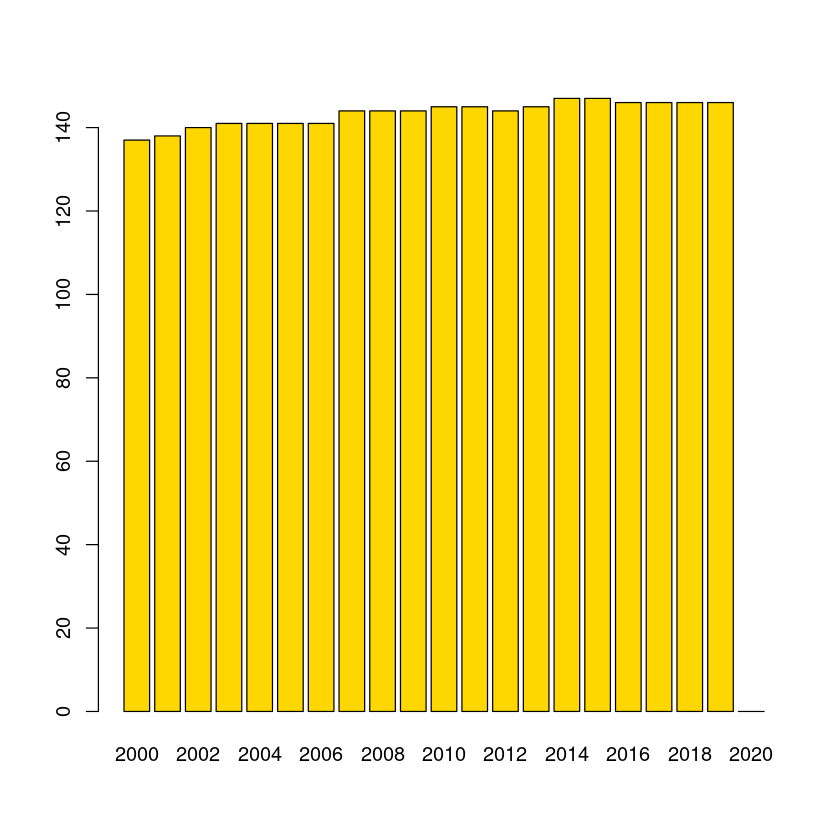

In [14]:
occ_y = table(complete_energy$Year)
print(occ_y)
barplot(occ_y, col="gold")

Chaque année n'a pas le même nombre d'observations.

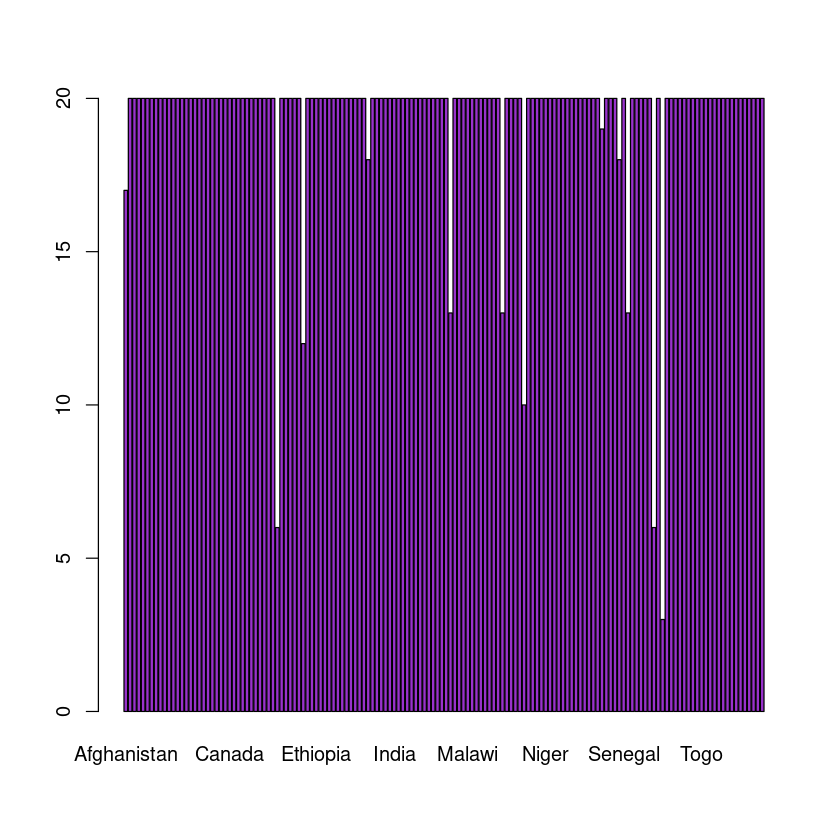

In [15]:
occ_e = table(complete_energy$Entity)
#print(occ_e)
barplot(occ_e,col = "darkorchid")


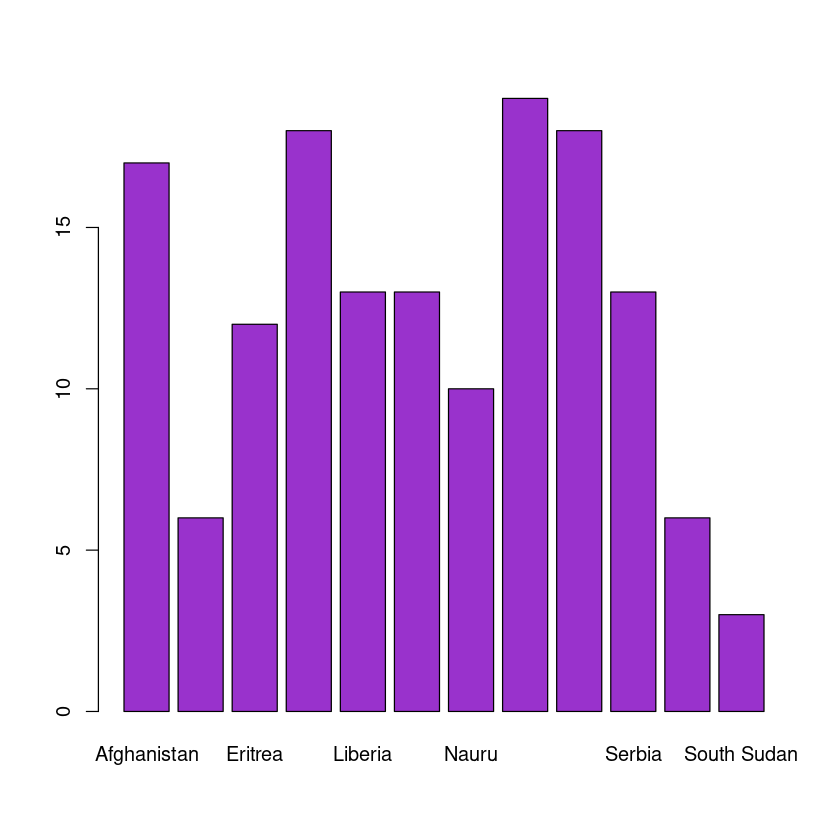

In [16]:
occ_e20 = occ_e[occ_e<20]
barplot(occ_e20,col = "darkorchid")

Chaque pays n'a pas le même nombre d'observations. Il y en a 12 qui n'ont pas été observés durant les 20 années de l'étude

#### Pour les variables quantitatives

In [17]:
summary(complete_energy)

    Entity               Year      Access.to.electricity....of.population.
 Length:2868        2014   : 147   Min.   :  1.252                        
 Class :character   2015   : 147   1st Qu.: 53.238                        
 Mode  :character   2016   : 146   Median : 97.000                        
                    2017   : 146   Mean   : 76.585                        
                    2018   : 146   3rd Qu.:100.000                        
                    2019   : 146   Max.   :100.000                        
                    (Other):1990                                          
 Access.to.clean.fuels.for.cooking
 Min.   :  0.00                   
 1st Qu.: 22.07                   
 Median : 81.55                   
 Mean   : 62.17                   
 3rd Qu.:100.00                   
 Max.   :100.00                   
                                  
 Renewable.energy.share.in.the.total.final.energy.consumption....
 Min.   : 0.000                                       

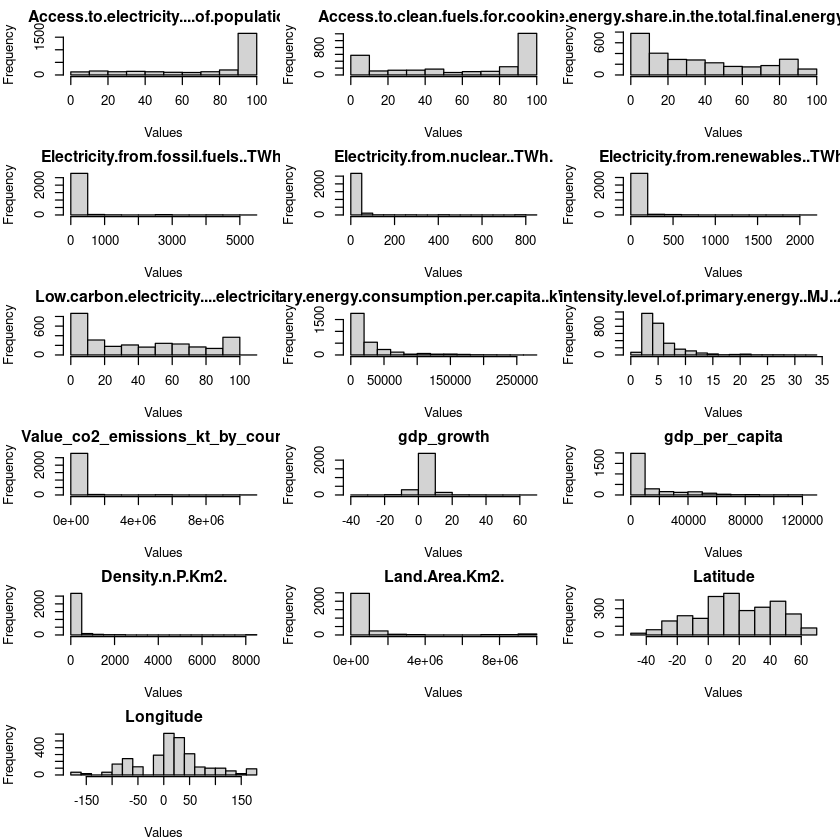

In [18]:
par(mfrow = c(6,3) , mar = c(4,4,2,1))

for (i in 3:length(names(complete_energy))) {
    dfi = complete_energy[,c(i)]
    hist(dfi, main=names(complete_energy)[i],xlab='Values')
}

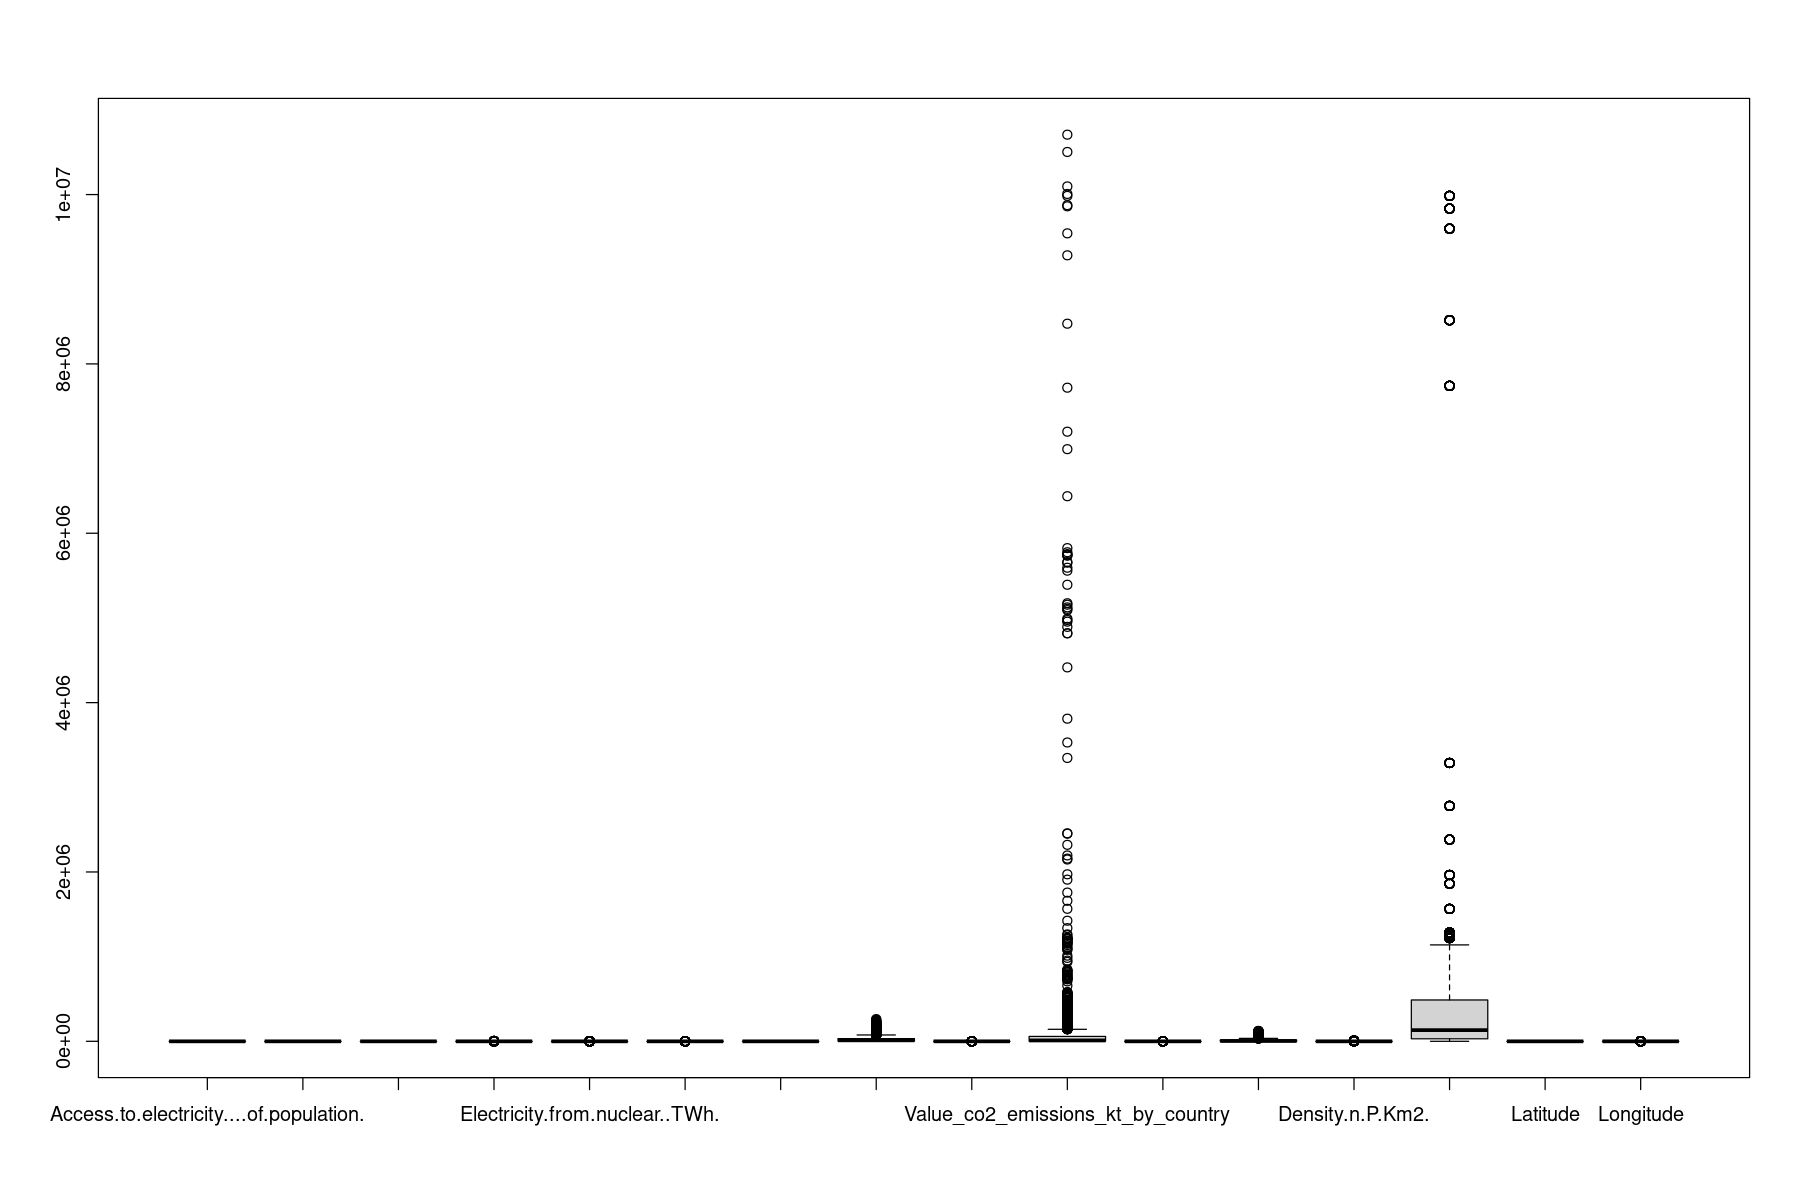

In [19]:
options(repr.plot.width = 15, repr.plot.height = 10)

df = complete_energy[,-c(1,2)]
boxplot(df)

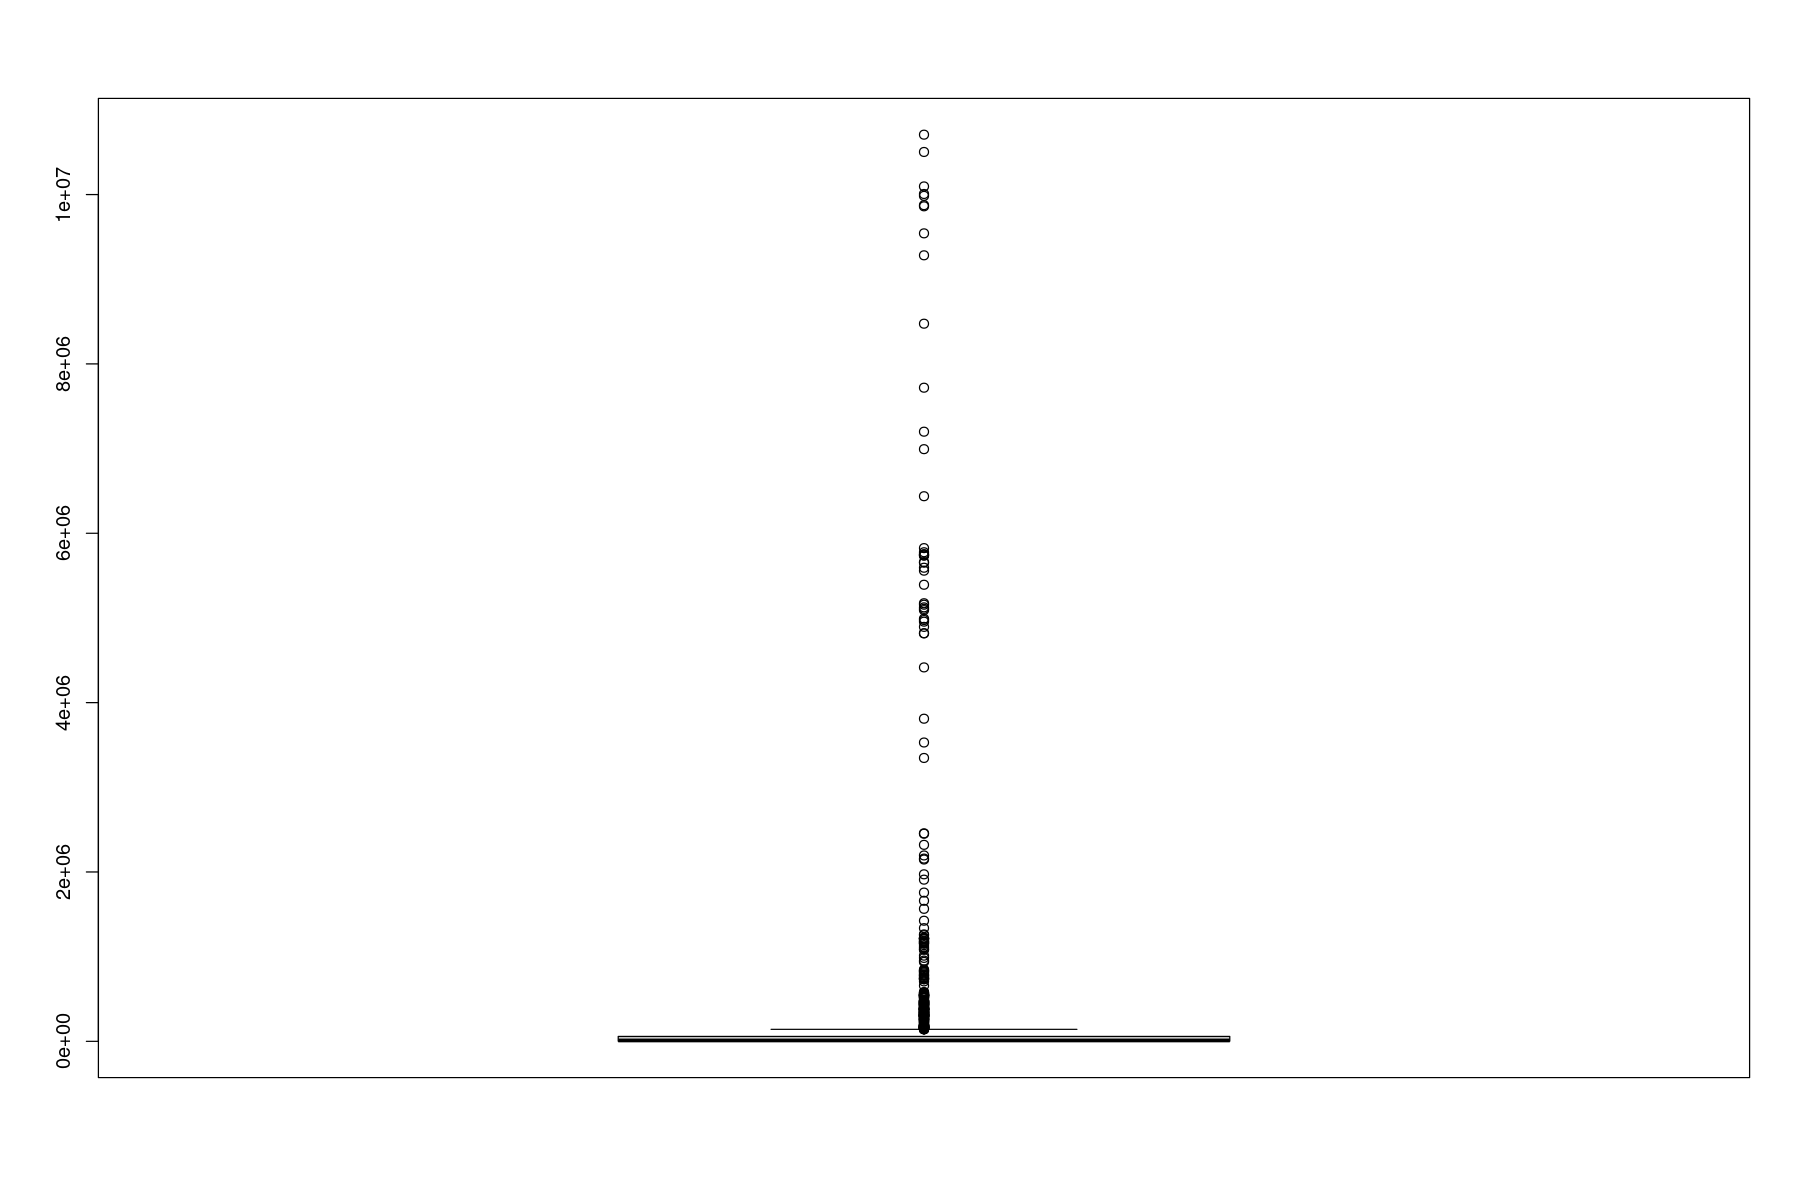

In [20]:
boxplot(df$Value_co2_emissions_kt_by_country)

Les échelles de valeurs sont très différentes en fonction des variables que nous regardons dans notre energyset, nos avons choisi de nous focaliser sur Value_CO2 et nous voyons que celle-ci est composée de beaucoup d'outliers. Donc l'observation en boxplot n'est pas forcément pertinente.

##### Transformation des variables

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


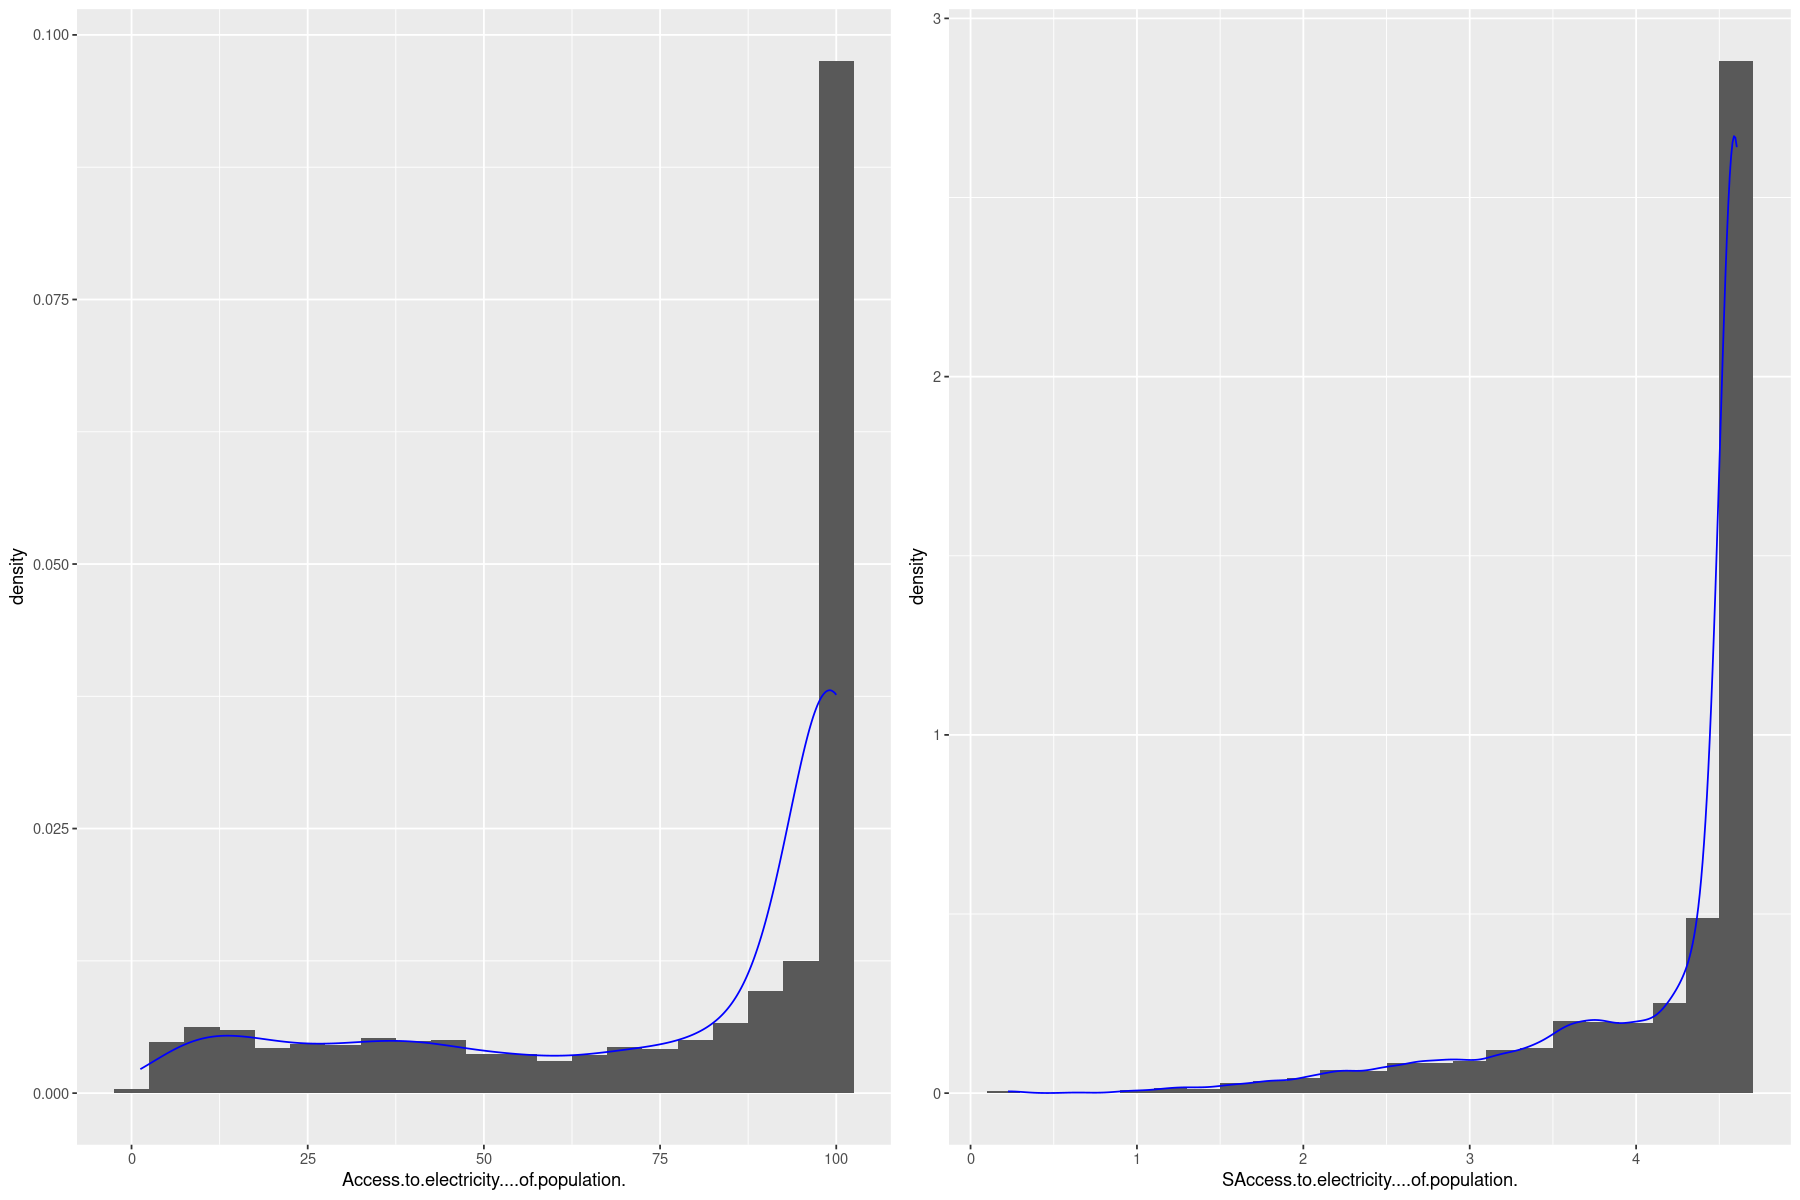

In [21]:
complete_energy[, "SAccess.to.electricity....of.population."] = log(complete_energy[, "Access.to.electricity....of.population."])

g1 = ggplot(complete_energy,aes(x=Access.to.electricity....of.population.))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SAccess.to.electricity....of.population.))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

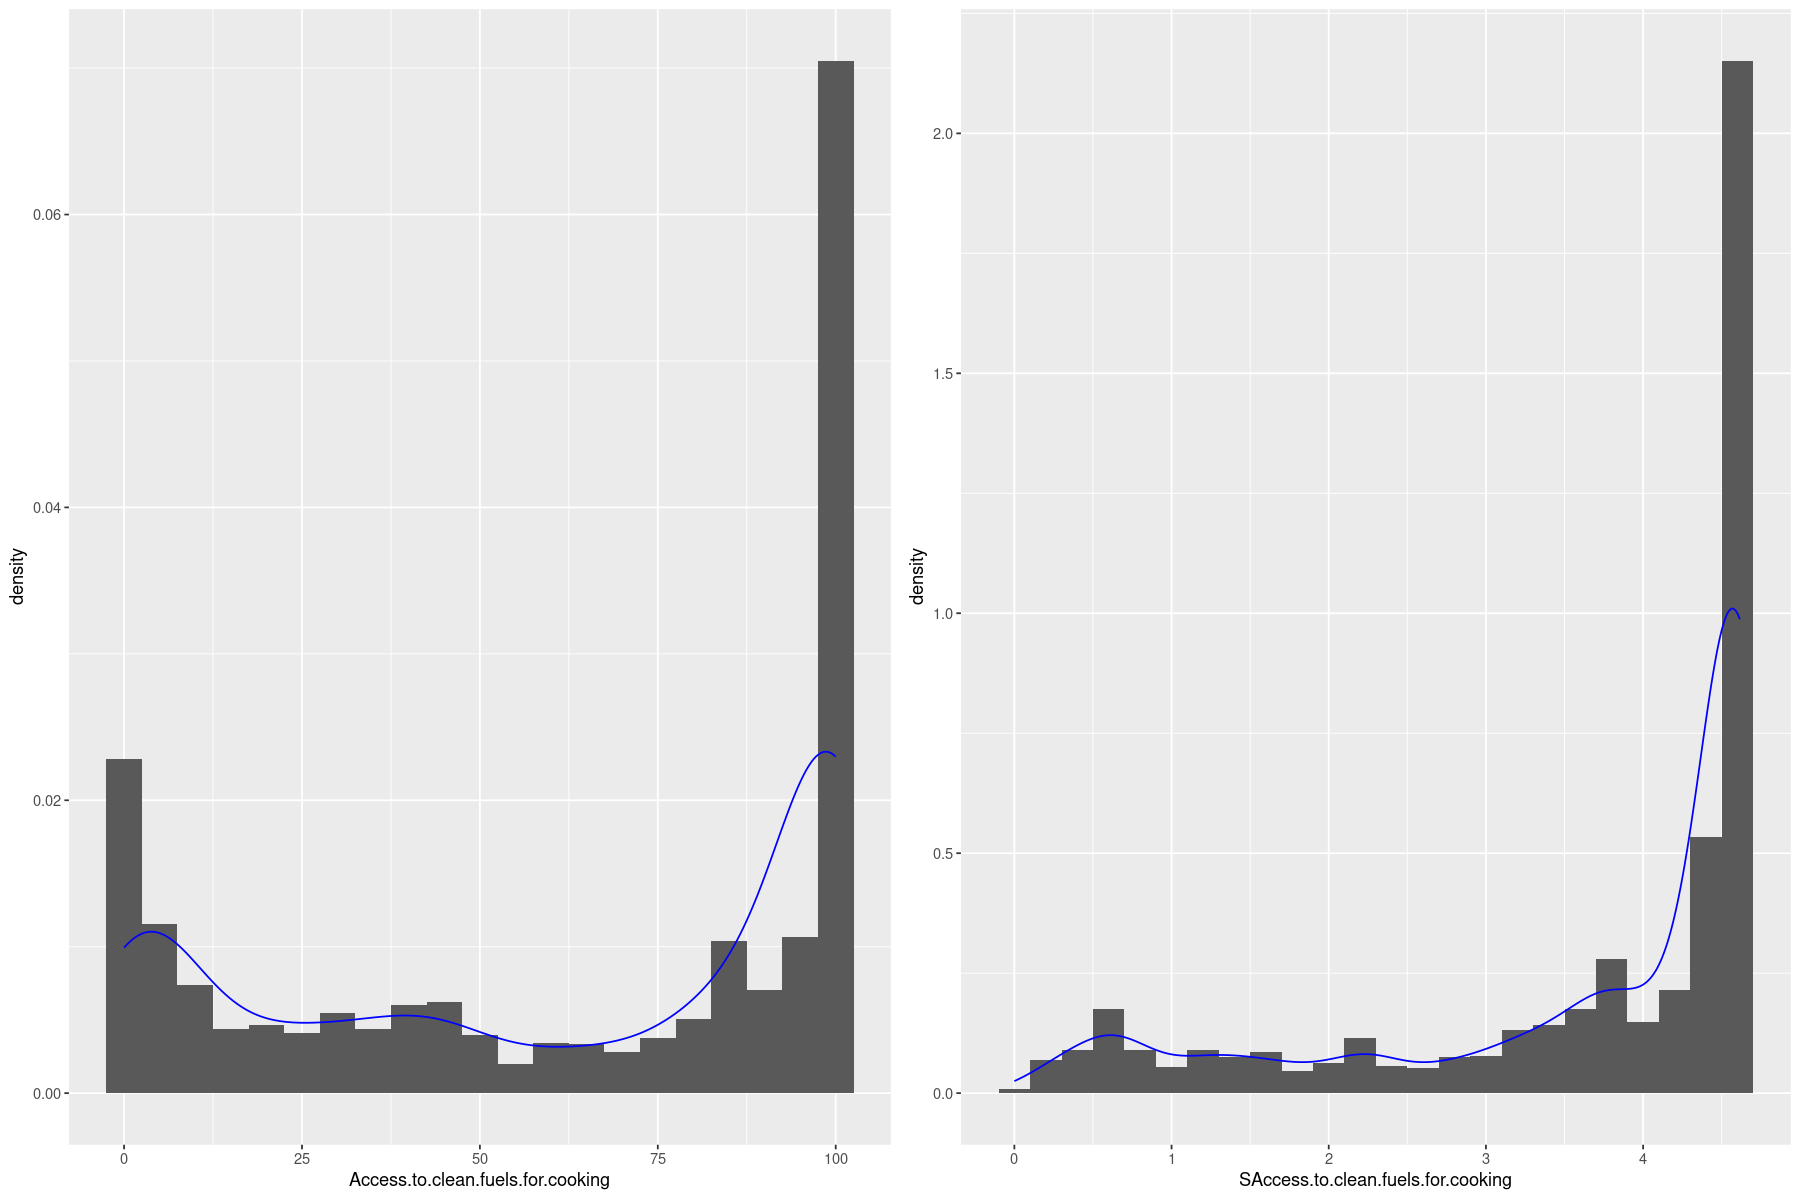

In [22]:
complete_energy[, "SAccess.to.clean.fuels.for.cooking"] = log(complete_energy[, "Access.to.clean.fuels.for.cooking"]+1)

g1 = ggplot(complete_energy,aes(x=Access.to.clean.fuels.for.cooking))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SAccess.to.clean.fuels.for.cooking))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

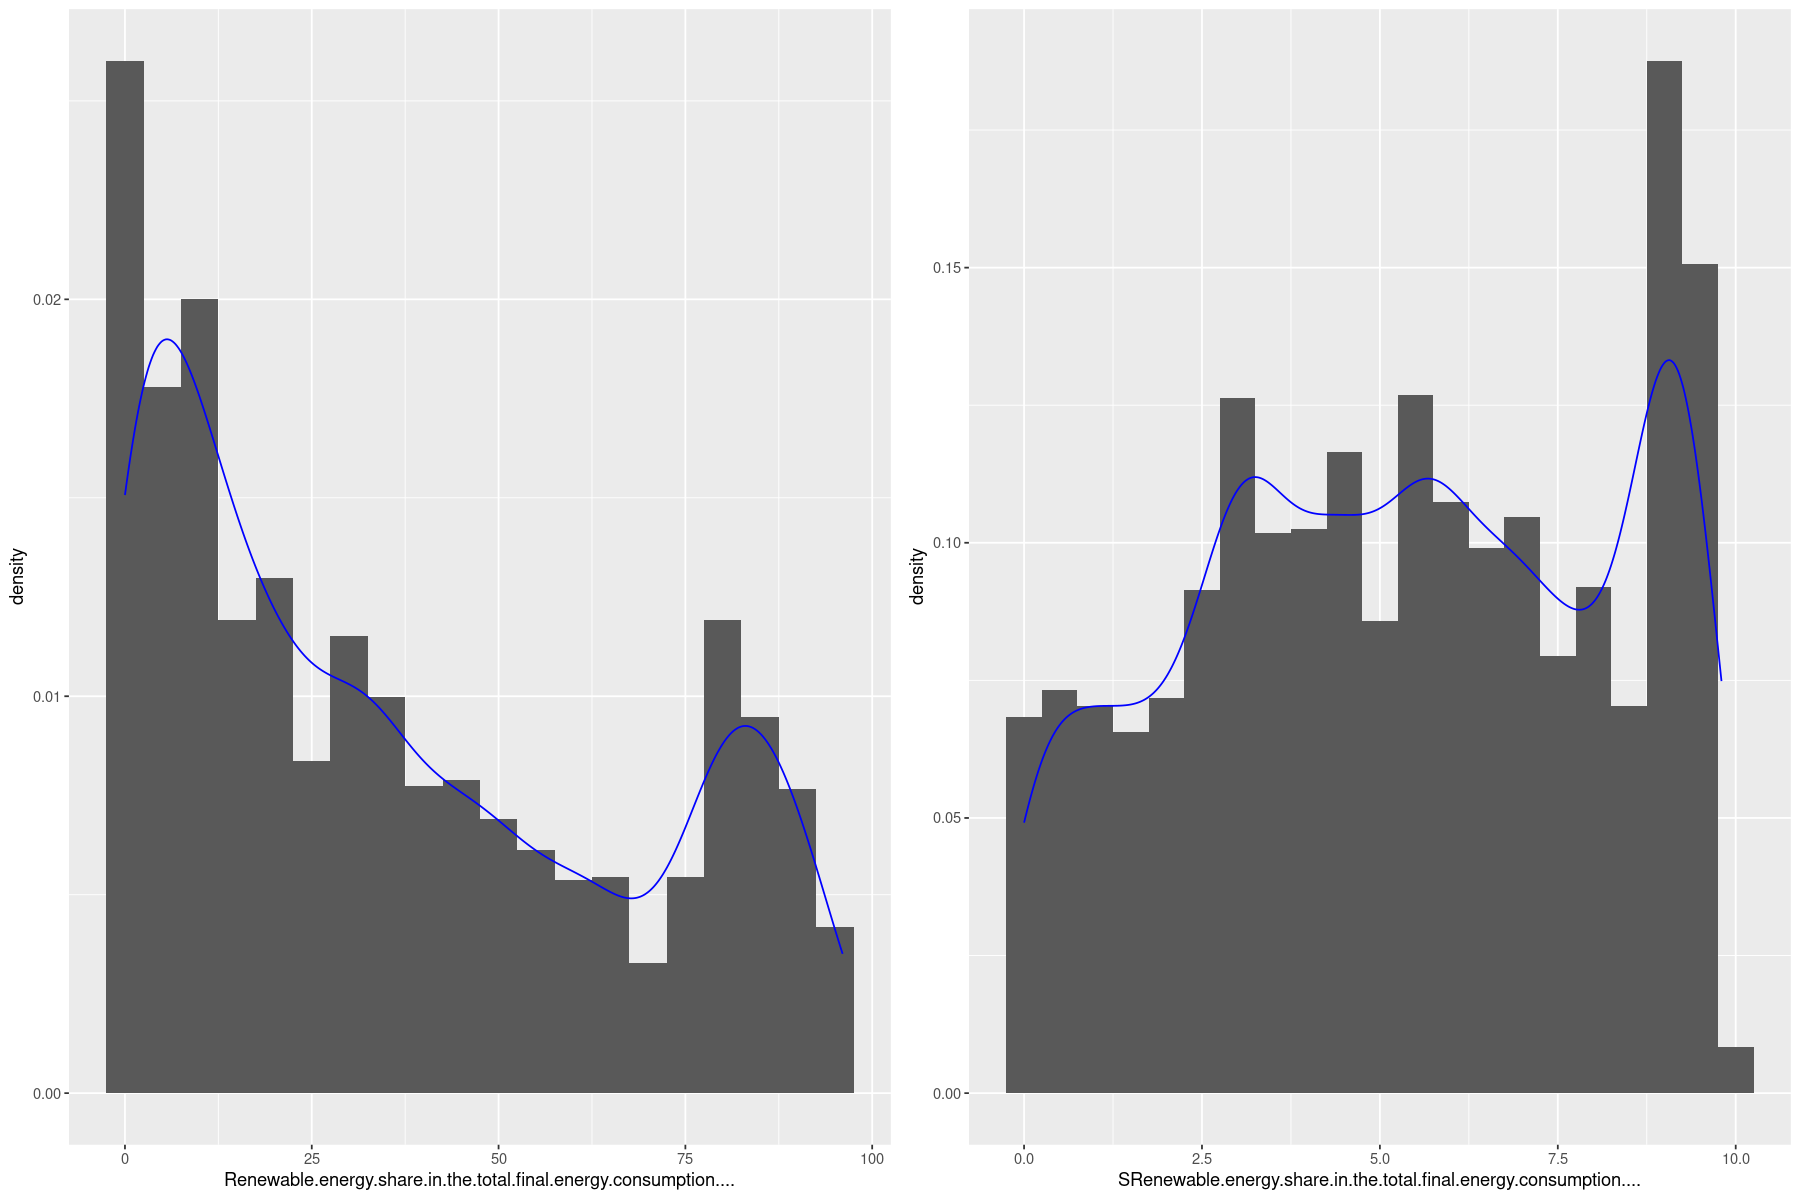

In [23]:
complete_energy[, "SRenewable.energy.share.in.the.total.final.energy.consumption...."] = sqrt(complete_energy[, "Renewable.energy.share.in.the.total.final.energy.consumption...."])

g1 = ggplot(complete_energy,aes(x=Renewable.energy.share.in.the.total.final.energy.consumption....))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SRenewable.energy.share.in.the.total.final.energy.consumption....))+ geom_histogram(aes(y=..density..),binwidth = 0.5)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

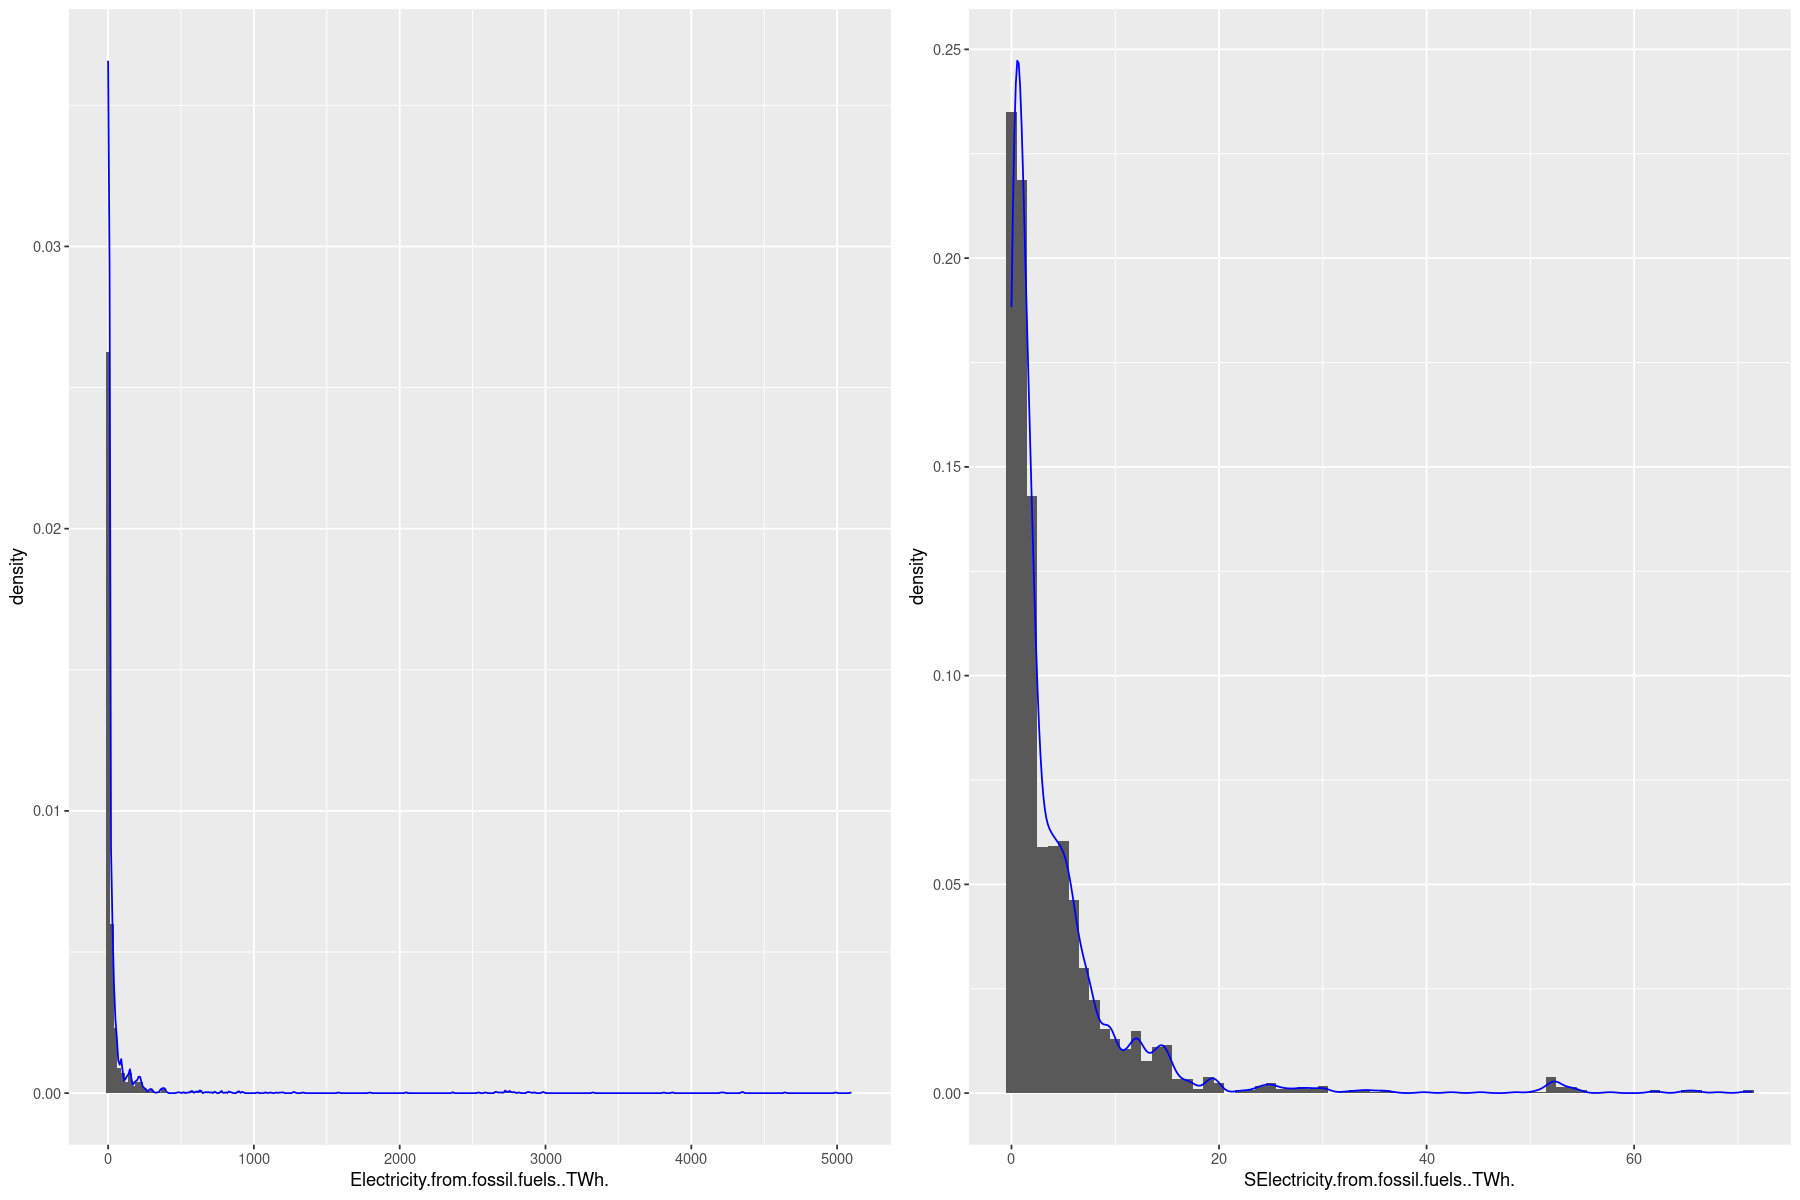

In [24]:
complete_energy[, "SElectricity.from.fossil.fuels..TWh."] = sqrt(complete_energy[, "Electricity.from.fossil.fuels..TWh."])

g1 = ggplot(complete_energy,aes(x=Electricity.from.fossil.fuels..TWh.))+ geom_histogram(aes(y=..density..),binwidth = 25)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SElectricity.from.fossil.fuels..TWh.))+ geom_histogram(aes(y=..density..),binwidth = 1)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

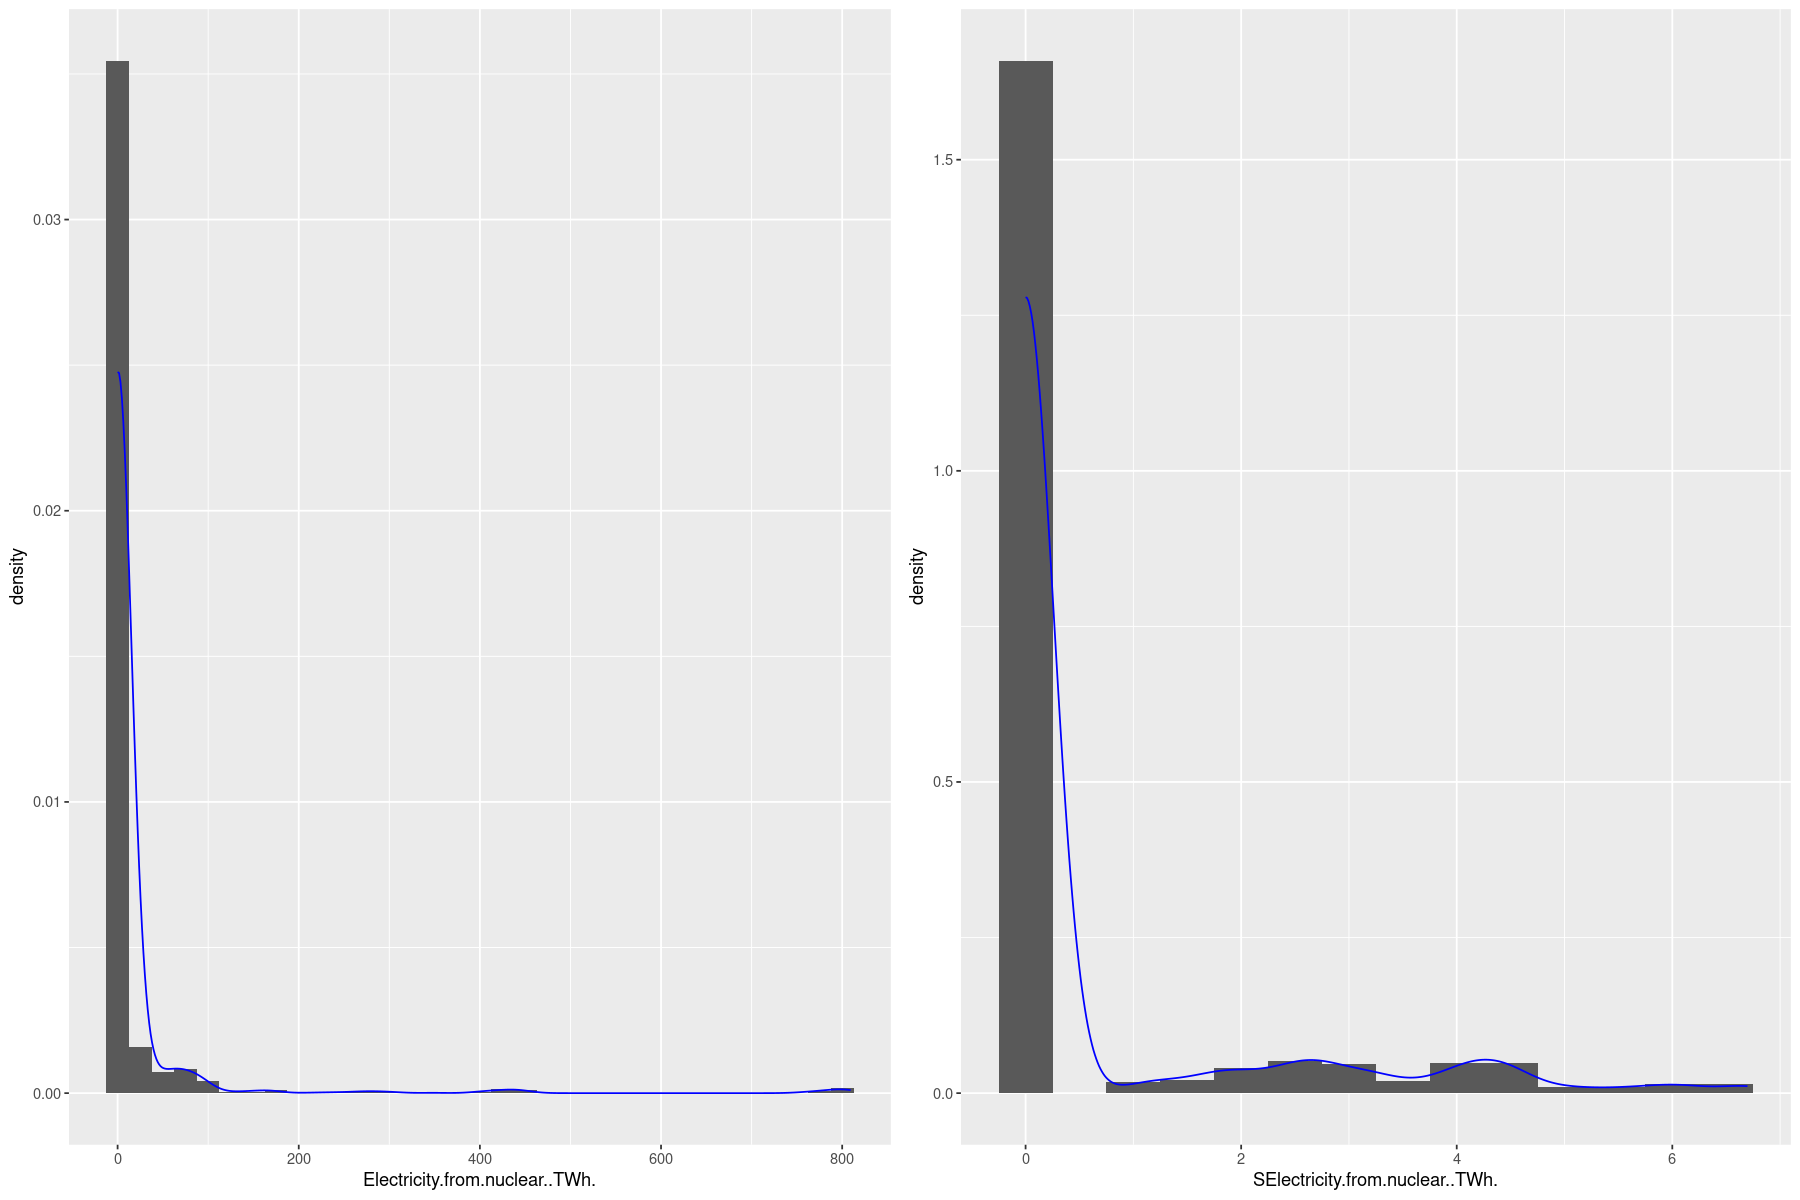

In [25]:
complete_energy[, "SElectricity.from.nuclear..TWh."] = log(1+complete_energy[, "Electricity.from.nuclear..TWh."])

g1 = ggplot(complete_energy,aes(x=Electricity.from.nuclear..TWh.))+ geom_histogram(aes(y=..density..),binwidth = 25)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SElectricity.from.nuclear..TWh.))+ geom_histogram(aes(y=..density..),binwidth = 0.5)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

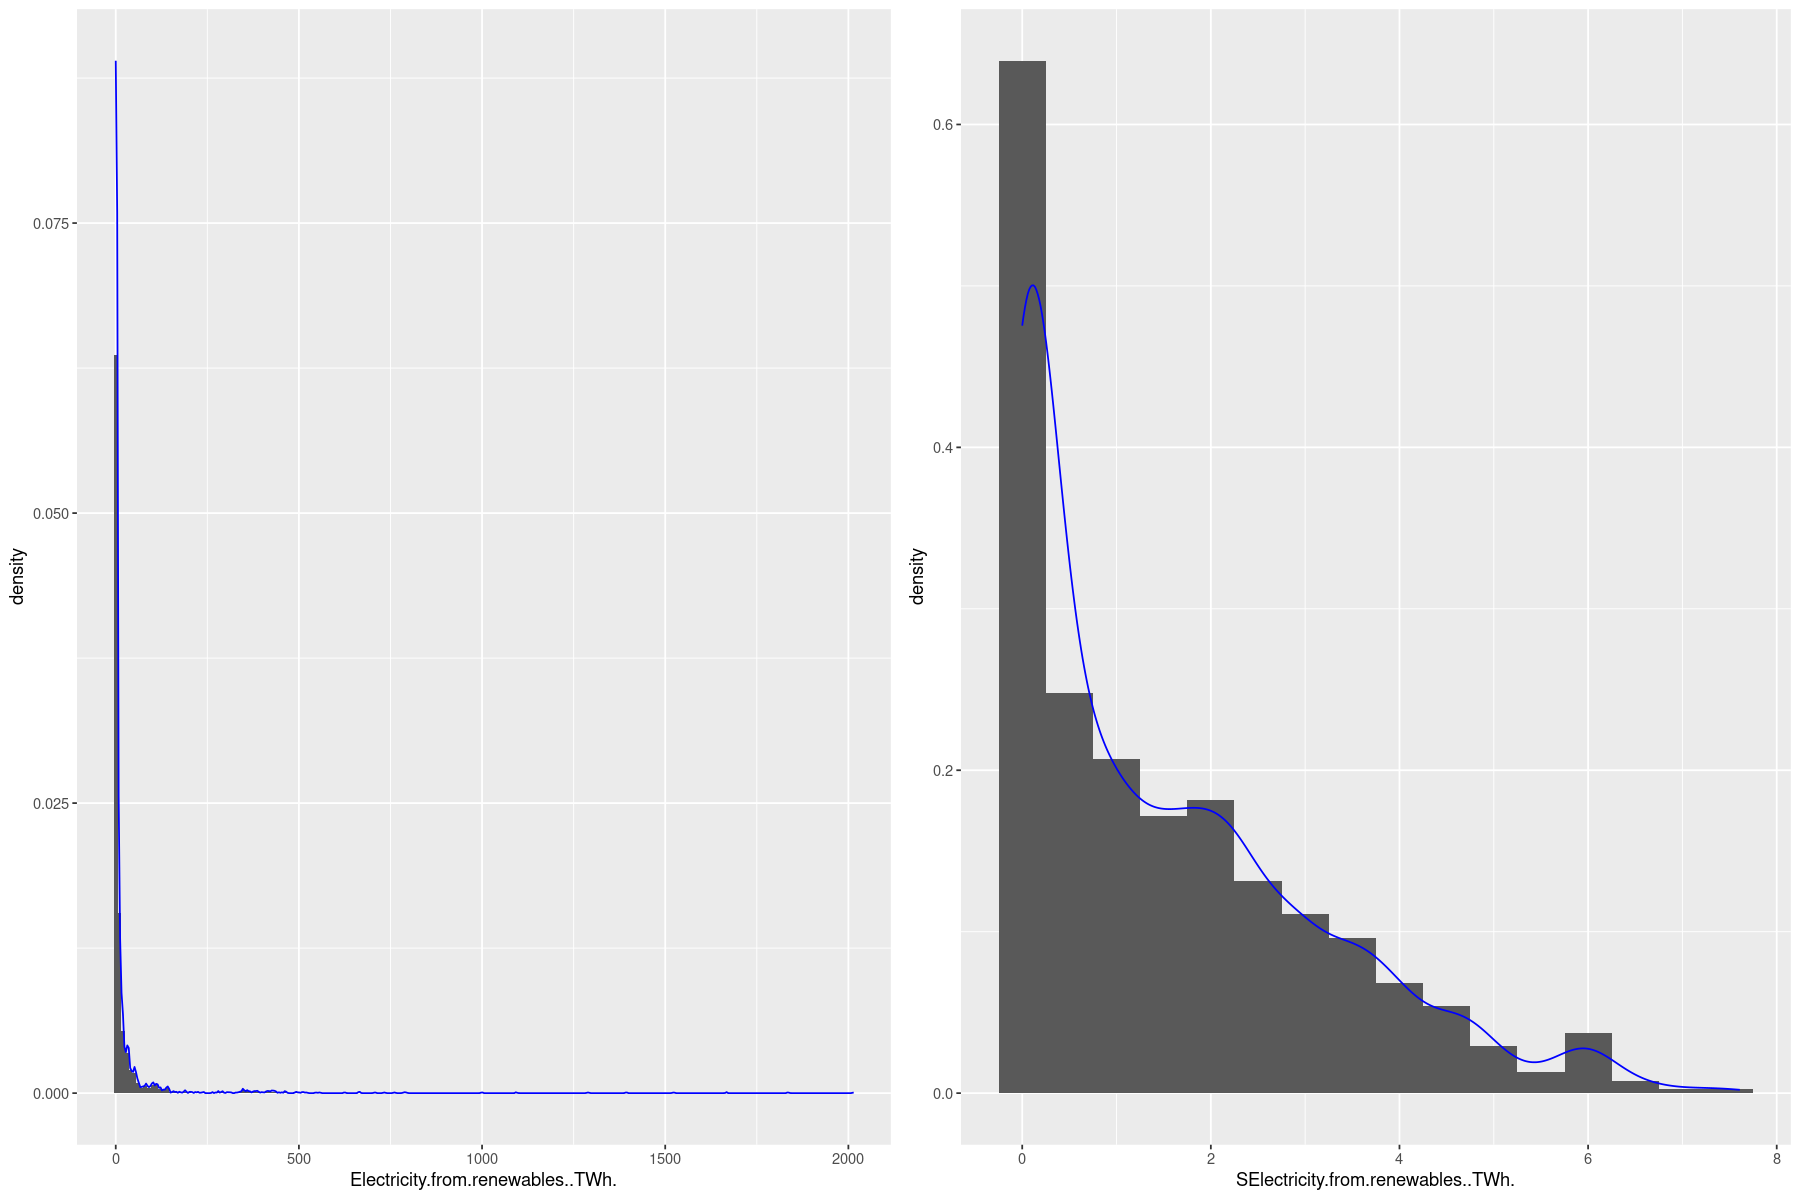

In [26]:
complete_energy[, "SElectricity.from.renewables..TWh."] = log(1+complete_energy[, "Electricity.from.renewables..TWh."])

g1 = ggplot(complete_energy,aes(x=Electricity.from.renewables..TWh.))+ geom_histogram(aes(y=..density..),binwidth = 10)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SElectricity.from.renewables..TWh.))+ geom_histogram(aes(y=..density..),binwidth = 0.5)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

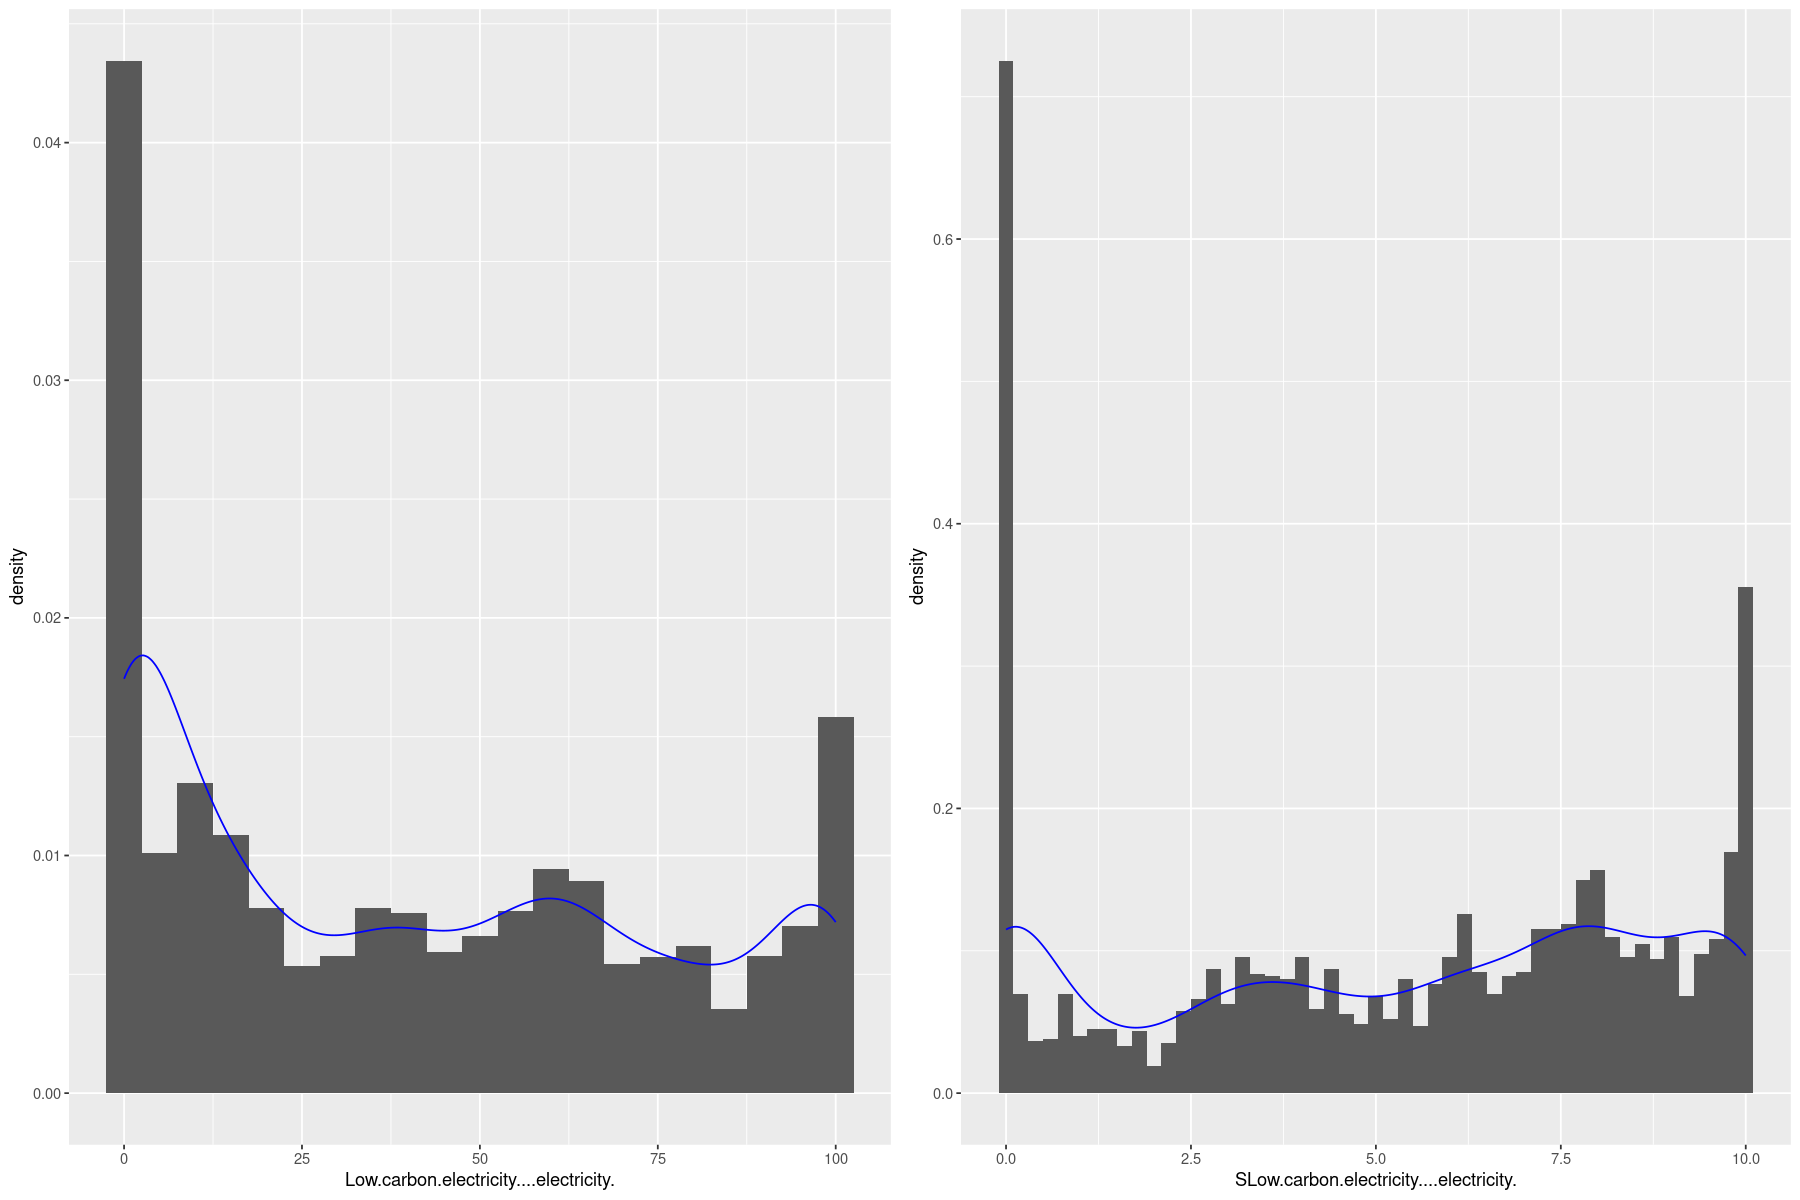

In [27]:
complete_energy[, "SLow.carbon.electricity....electricity."] = sqrt(complete_energy[, "Low.carbon.electricity....electricity."])

g1 = ggplot(complete_energy,aes(x=Low.carbon.electricity....electricity.))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SLow.carbon.electricity....electricity.))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

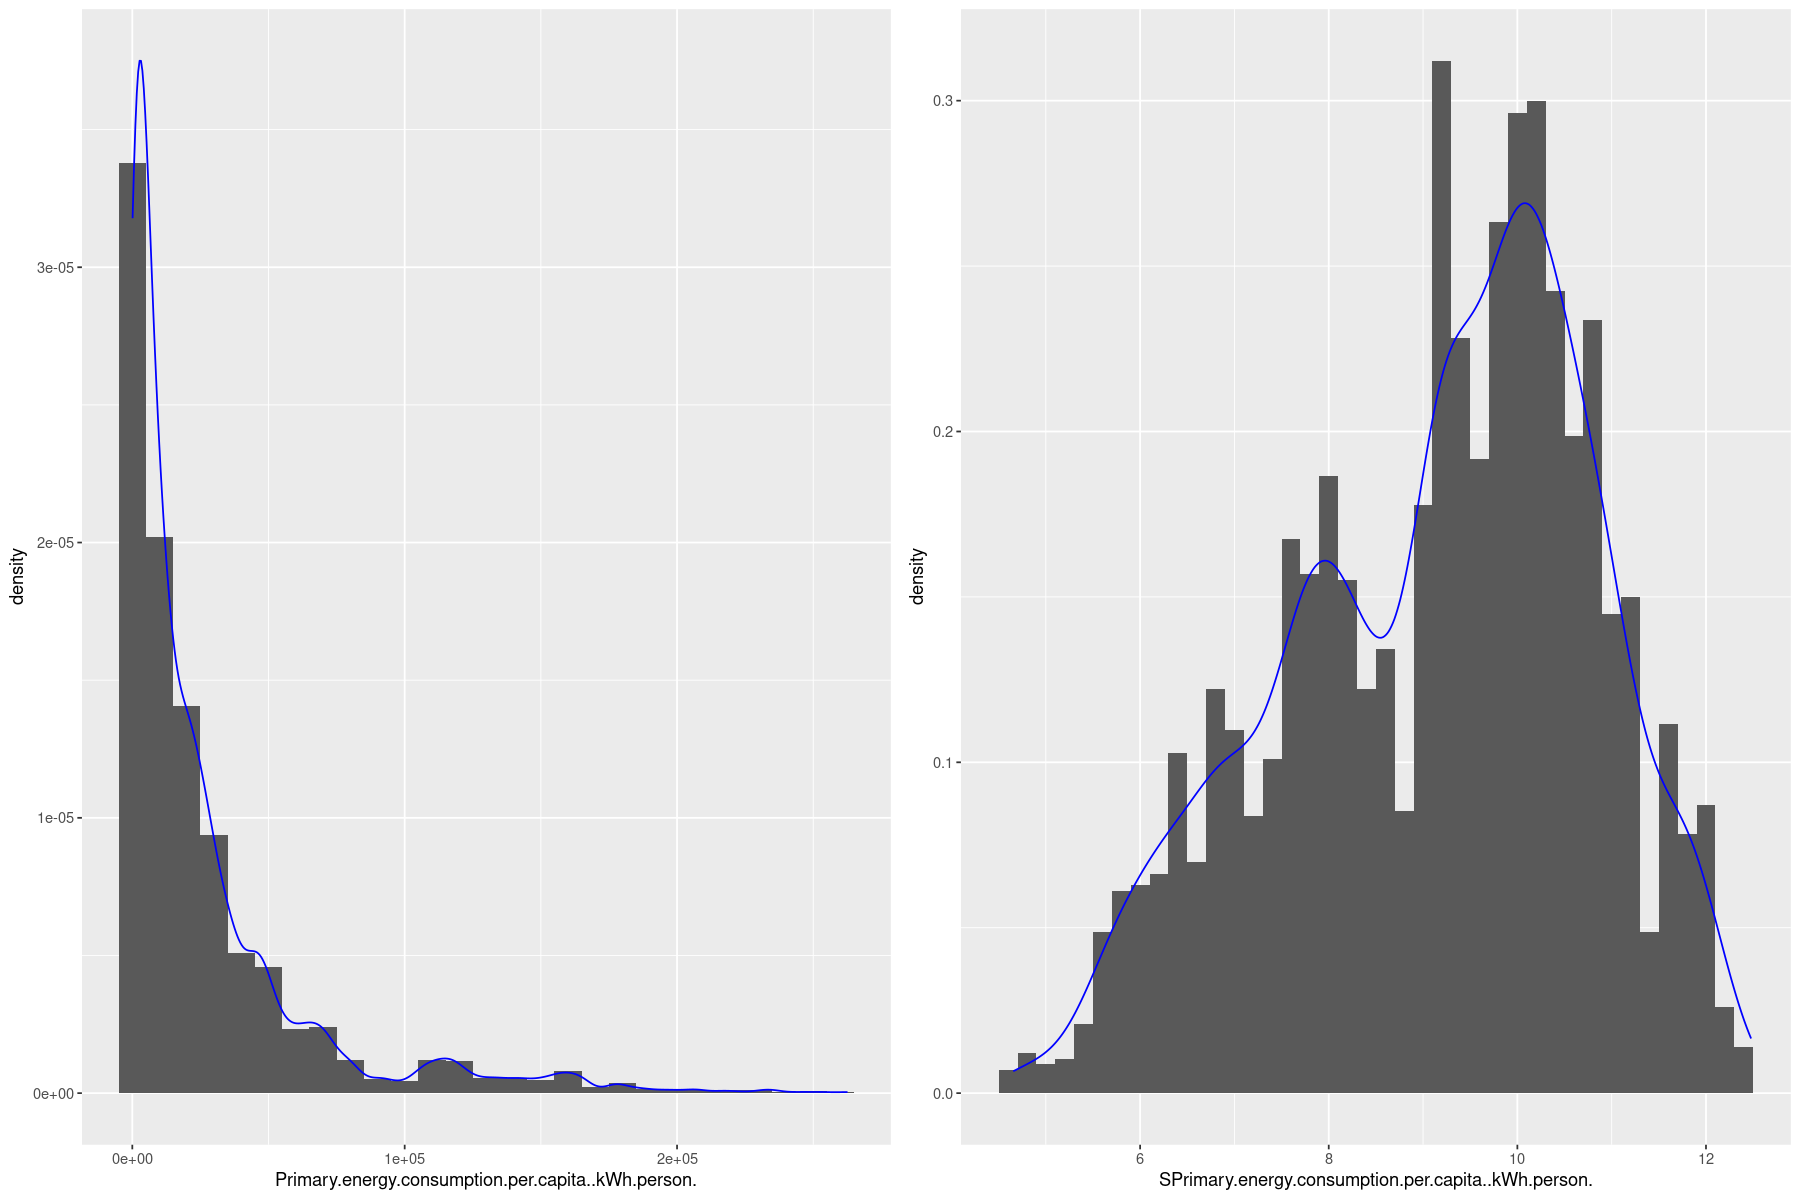

In [28]:
complete_energy[, "SPrimary.energy.consumption.per.capita..kWh.person."] = log(complete_energy[, "Primary.energy.consumption.per.capita..kWh.person."])

g1 = ggplot(complete_energy,aes(x=Primary.energy.consumption.per.capita..kWh.person.))+ geom_histogram(aes(y=..density..),binwidth = 10000)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SPrimary.energy.consumption.per.capita..kWh.person.))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

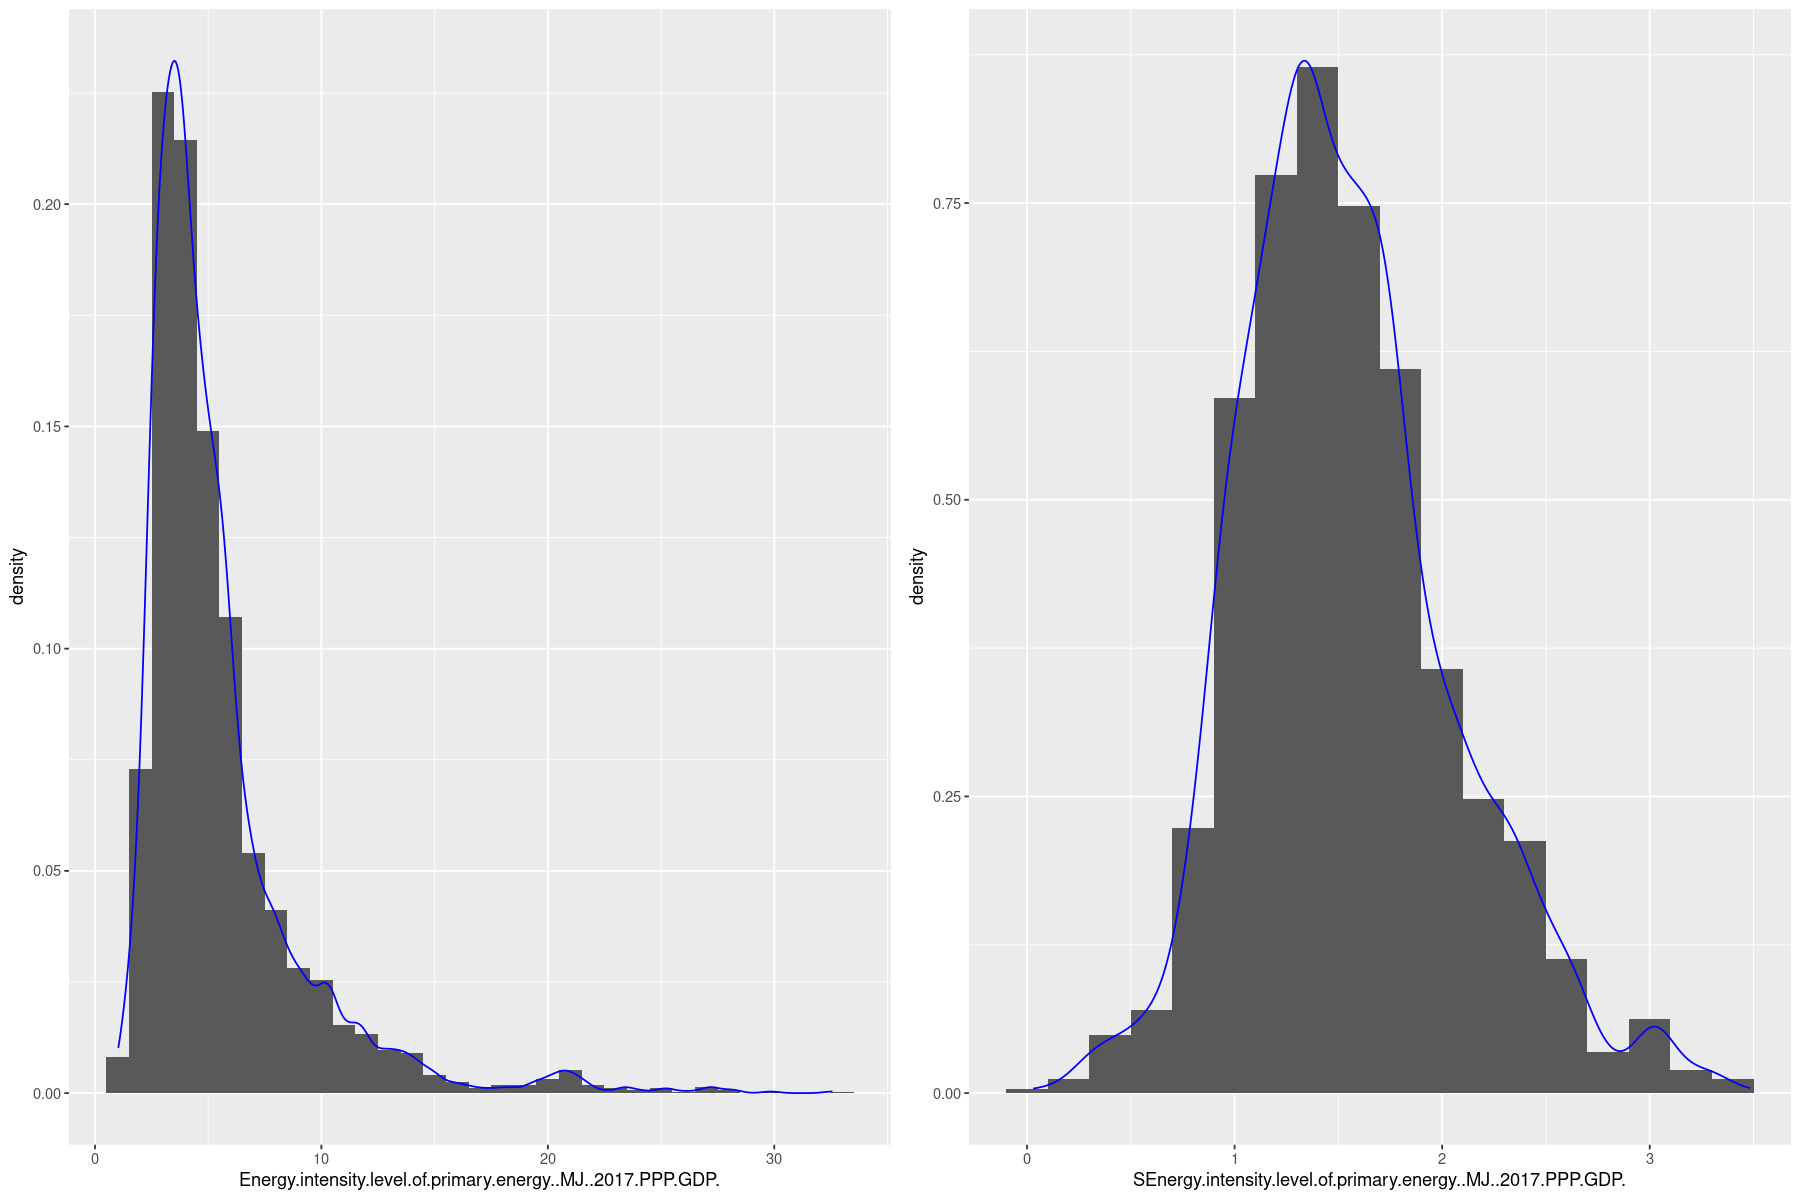

In [29]:
complete_energy[, "SEnergy.intensity.level.of.primary.energy..MJ..2017.PPP.GDP."] = log(complete_energy[, "Energy.intensity.level.of.primary.energy..MJ..2017.PPP.GDP."])

g1 = ggplot(complete_energy,aes(x=Energy.intensity.level.of.primary.energy..MJ..2017.PPP.GDP.))+ geom_histogram(aes(y=..density..),binwidth = 1)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SEnergy.intensity.level.of.primary.energy..MJ..2017.PPP.GDP.))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

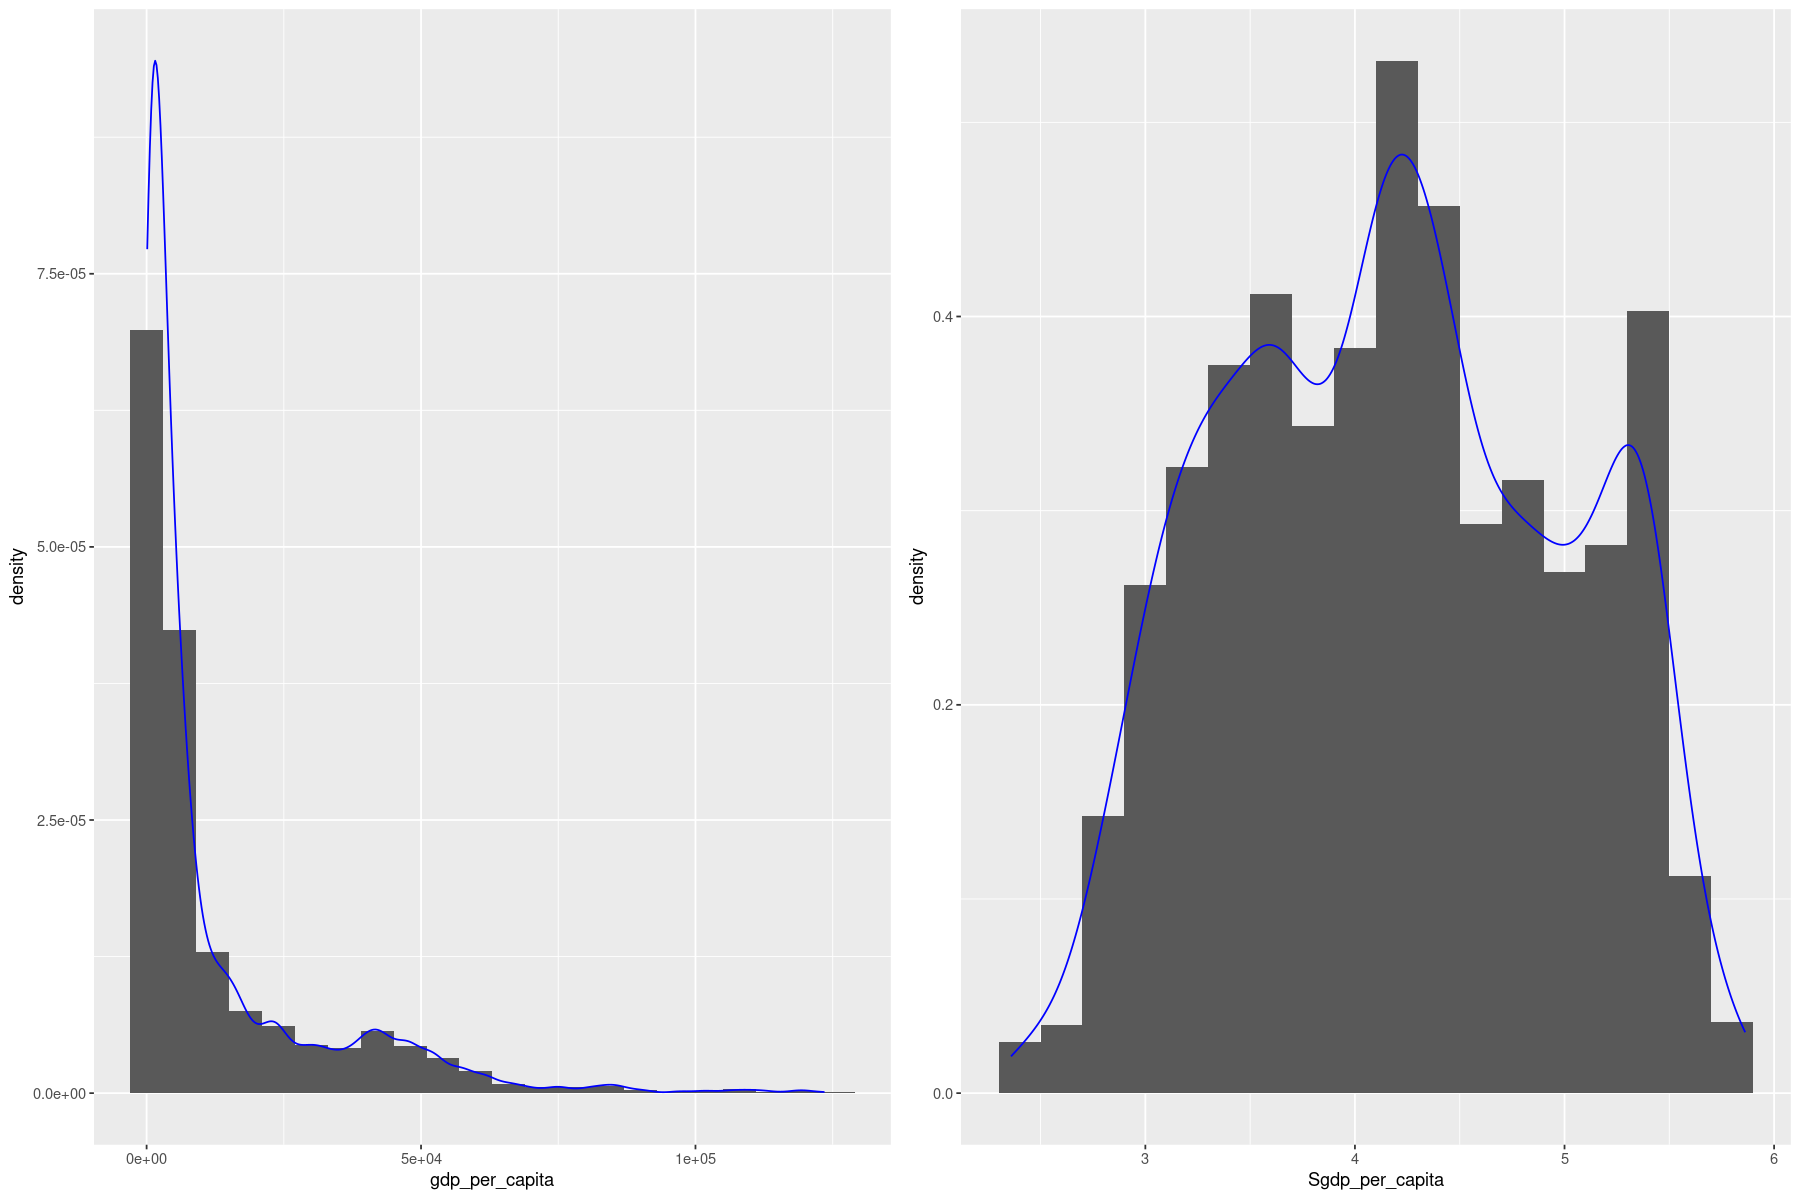

In [30]:
complete_energy[, "Sgdp_per_capita"] = log(sqrt(complete_energy[, "gdp_per_capita"]))

g1 = ggplot(complete_energy,aes(x=gdp_per_capita))+ geom_histogram(aes(y=..density..),binwidth = 6000)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=Sgdp_per_capita))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

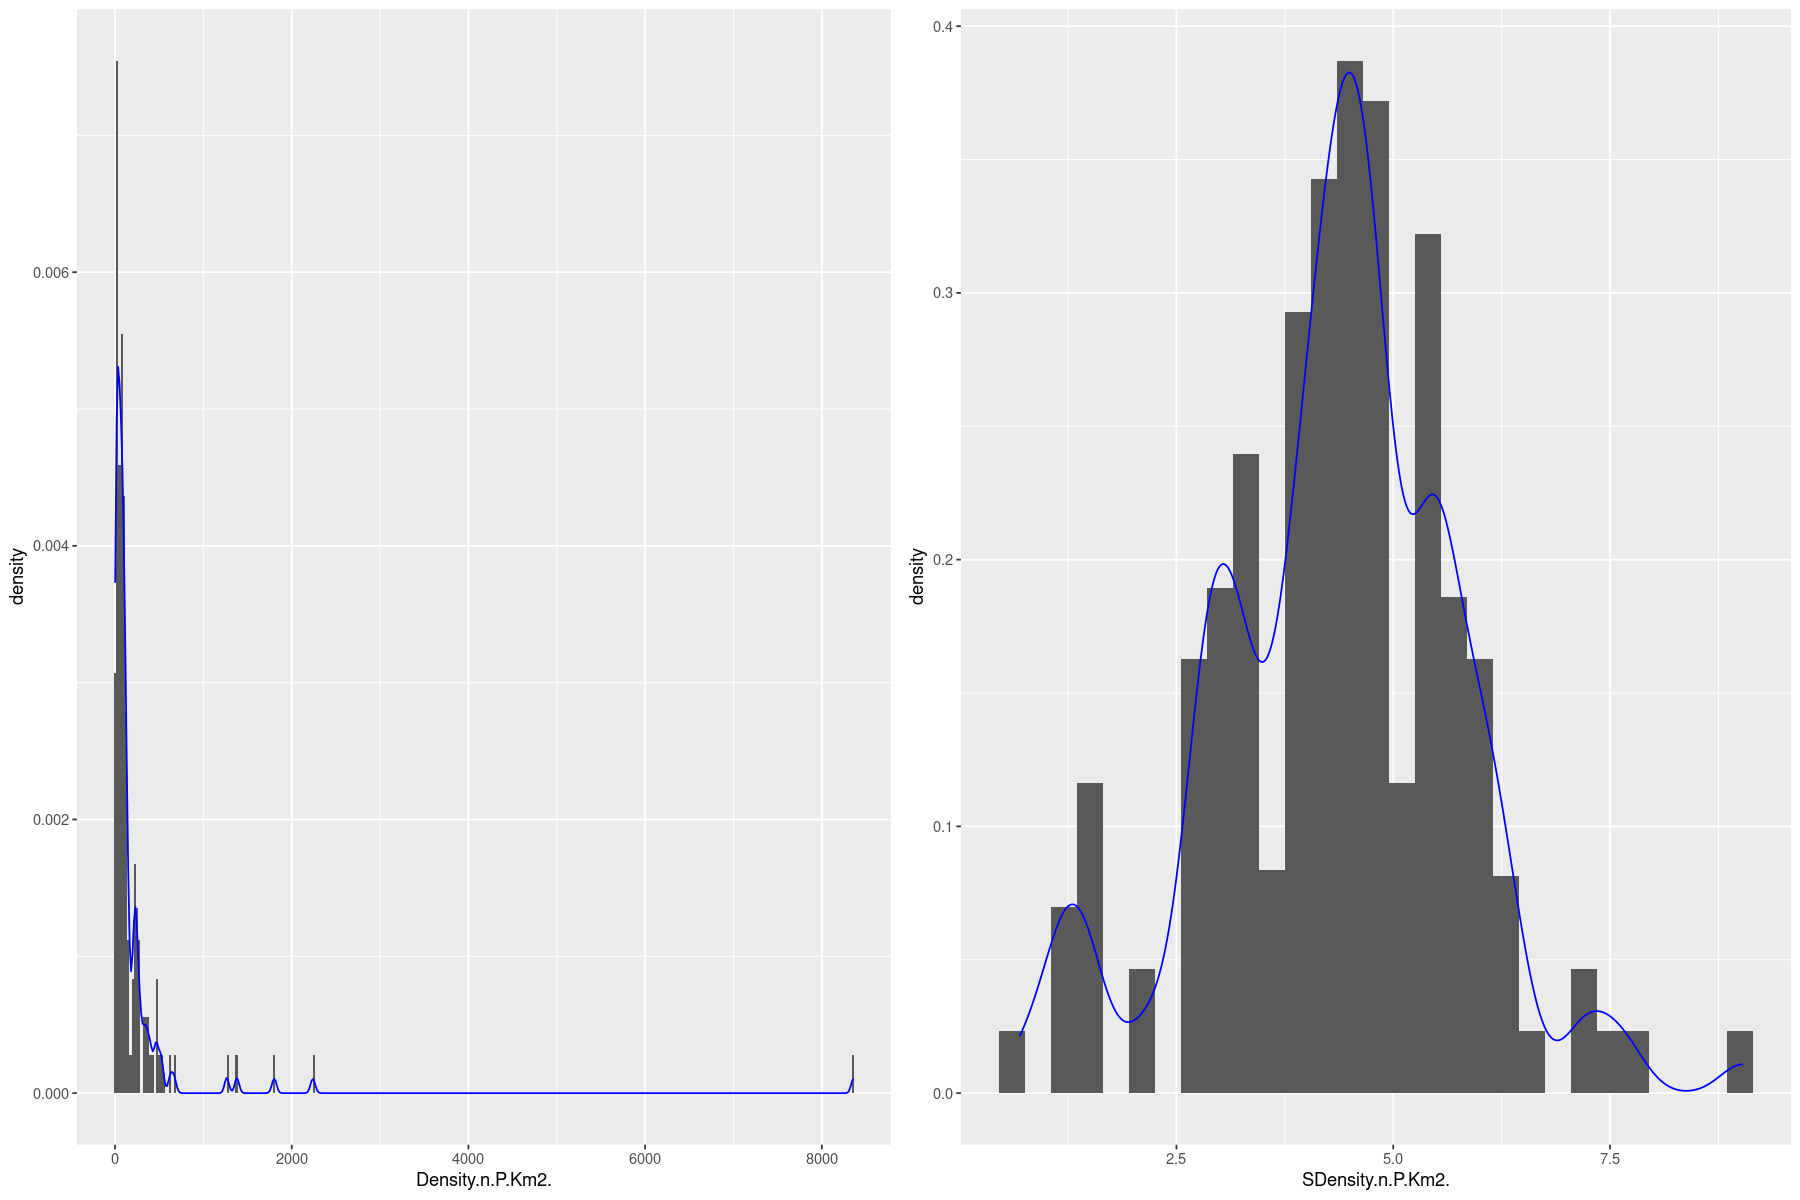

In [31]:
complete_energy[, "SDensity.n.P.Km2."] = log(complete_energy[, "Density.n.P.Km2."])

g1 = ggplot(complete_energy,aes(x=Density.n.P.Km2.))+ geom_histogram(aes(y=..density..),binwidth = 25)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SDensity.n.P.Km2.))+ geom_histogram(aes(y=..density..),binwidth = 0.3)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

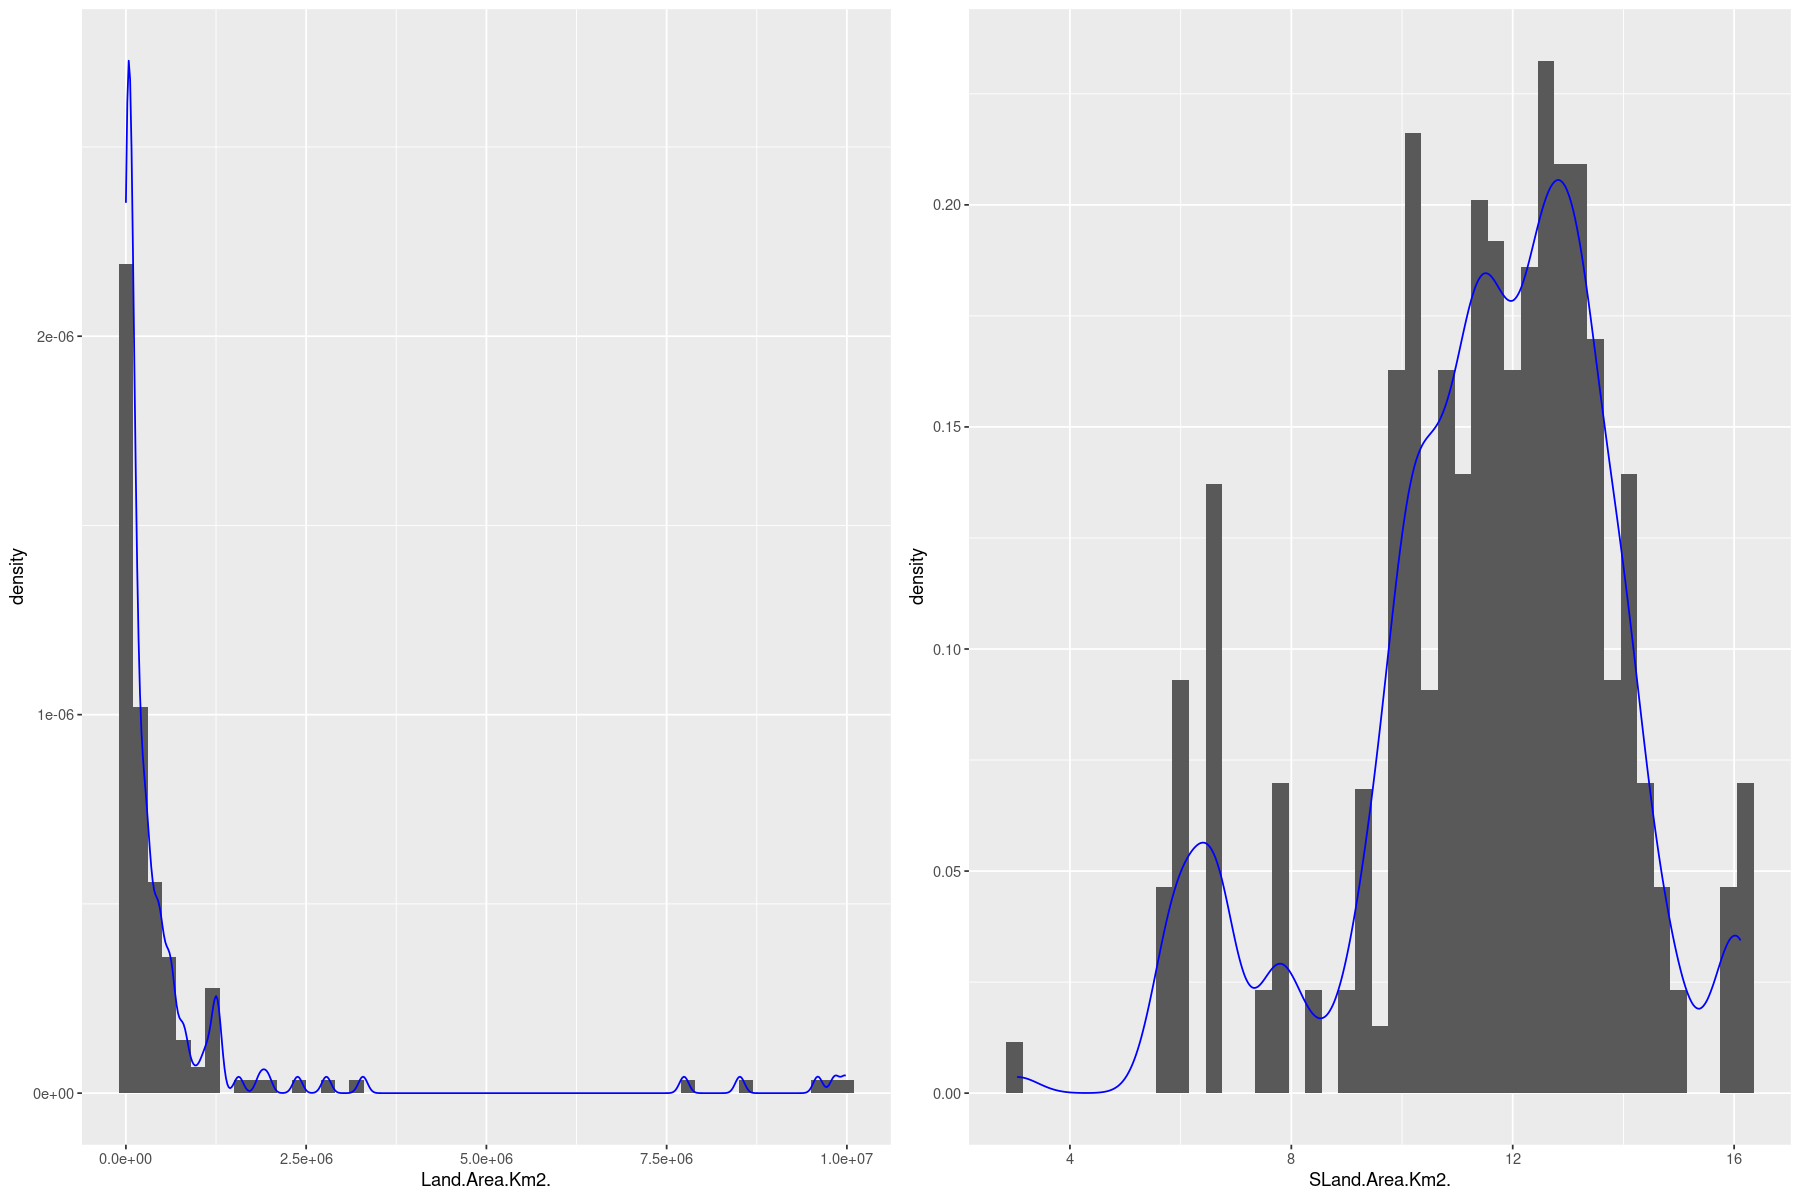

In [32]:
complete_energy[, "SLand.Area.Km2."] = log(complete_energy[, "Land.Area.Km2."])

g1 = ggplot(complete_energy,aes(x=Land.Area.Km2.))+ geom_histogram(aes(y=..density..),binwidth = 200000)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SLand.Area.Km2.))+ geom_histogram(aes(y=..density..),binwidth = 0.3)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

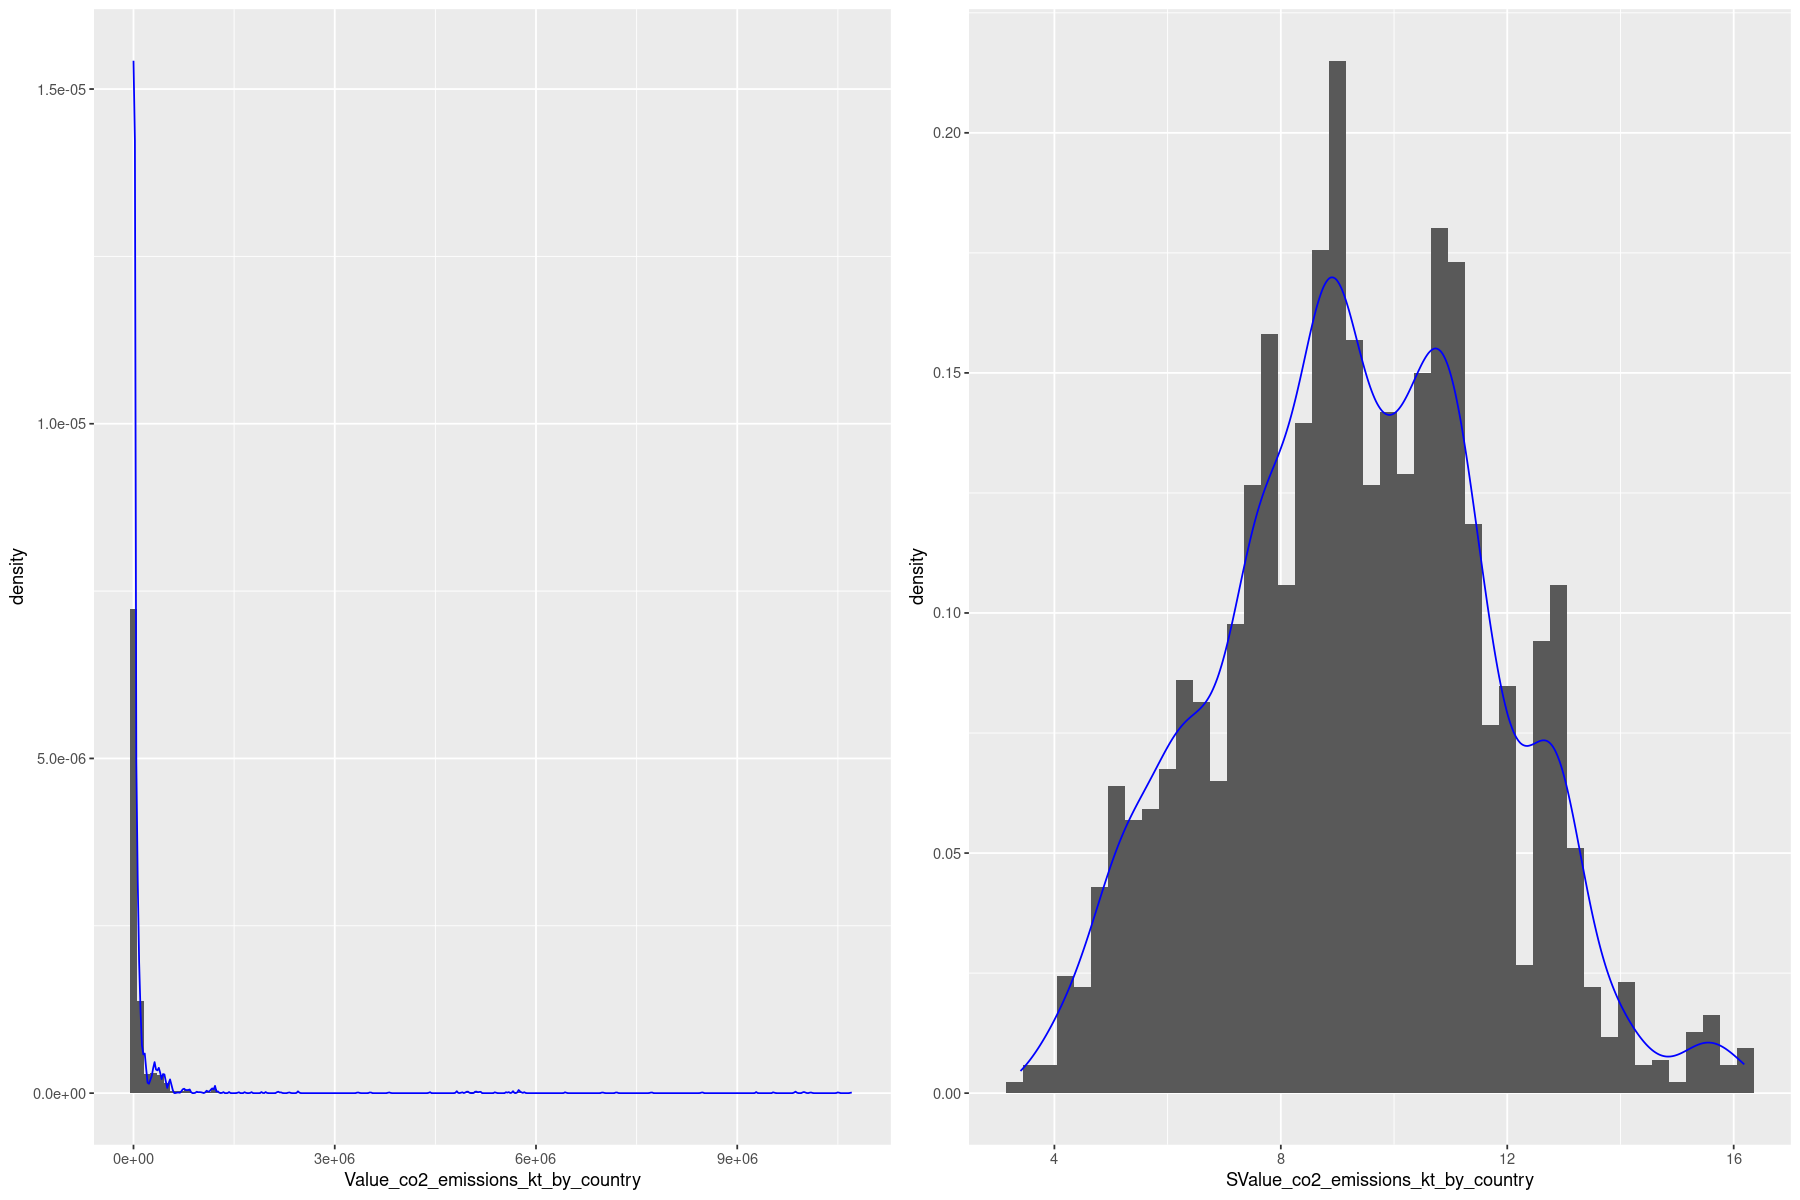

In [33]:
complete_energy[, "SValue_co2_emissions_kt_by_country"] = log(complete_energy[, "Value_co2_emissions_kt_by_country"])

g1 = ggplot(complete_energy,aes(x=Value_co2_emissions_kt_by_country))+ geom_histogram(aes(y=..density..),binwidth = 100000)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SValue_co2_emissions_kt_by_country))+ geom_histogram(aes(y=..density..),binwidth = 0.3)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

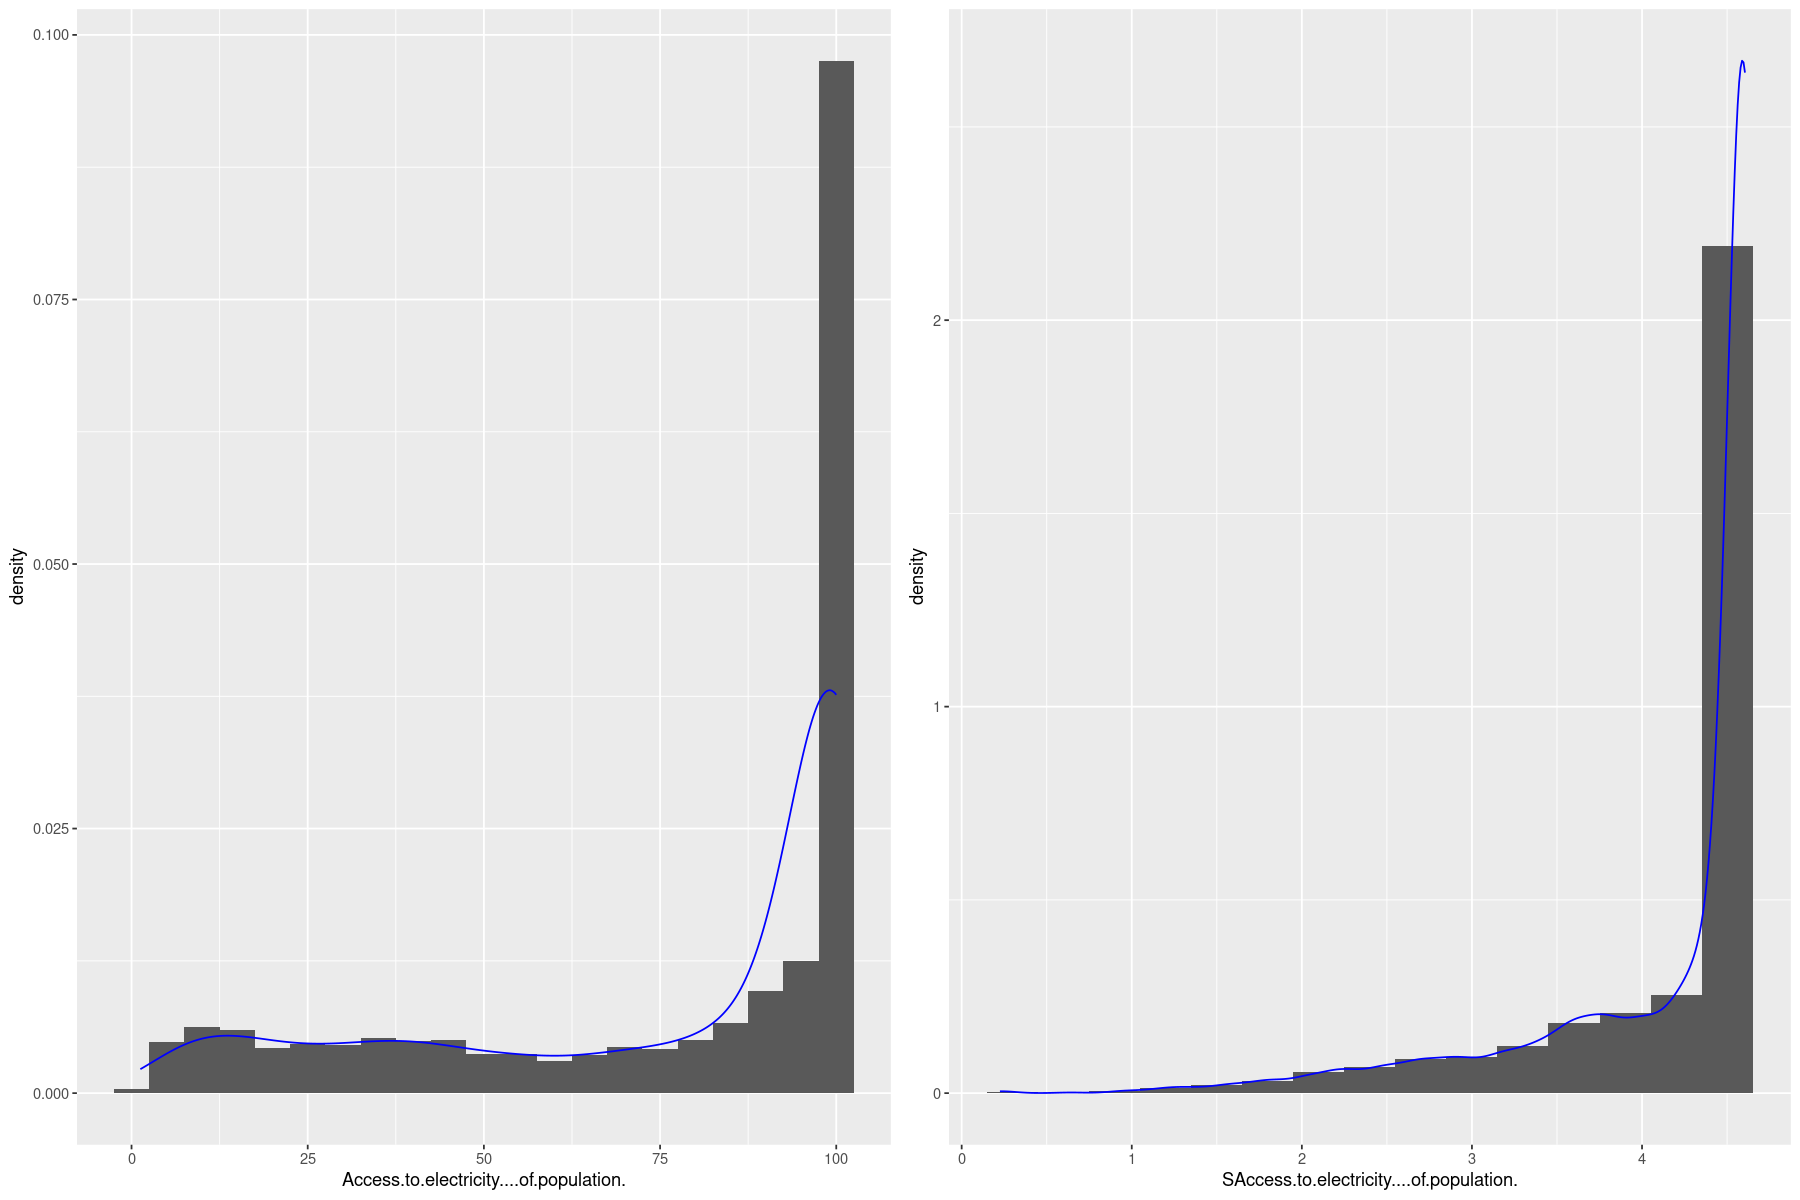

In [34]:
complete_energy[, "SAccess.to.electricity....of.population."] = log(complete_energy[, "Access.to.electricity....of.population."])

g1 = ggplot(complete_energy,aes(x=Access.to.electricity....of.population.))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SAccess.to.electricity....of.population.))+ geom_histogram(aes(y=..density..),binwidth =0.3)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

In [35]:
#for (i in 3:length(names(complete_energy))) {

#complete_energy[, "SAccess.to.electricity....of.population."] = log(complete_energy[, "Access.to.electricity....of.population."])

#g1 = ggplot(complete_energy,aes(x=Access.to.electricity....of.population.))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
#g2 = ggplot(complete_energy,aes(x=SAccess.to.electricity....of.population.))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

#grid.arrange(g1,g2,ncol=2)
    
#}

In [36]:
#summary(complete_energy)

In [37]:
complete_energy = complete_energy[-c(3,4,5,6,7,8,9,10,11,14,15,16)]

In [38]:
summary(complete_energy)

    Entity               Year      Value_co2_emissions_kt_by_country
 Length:2868        2014   : 147   Min.   :      30                 
 Class :character   2015   : 147   1st Qu.:    2188                 
 Mode  :character   2016   : 146   Median :   10425                 
                    2017   : 146   Mean   :  168818                 
                    2018   : 146   3rd Qu.:   58145                 
                    2019   : 146   Max.   :10707220                 
                    (Other):1990                                    
   gdp_growth         Latitude         Longitude      
 Min.   :-36.658   Min.   :-40.901   Min.   :-175.20  
 1st Qu.:  1.771   1st Qu.:  1.651   1st Qu.: -10.94  
 Median :  3.788   Median : 17.061   Median :  18.64  
 Mean   :  3.895   Mean   : 18.140   Mean   :  12.97  
 3rd Qu.:  5.957   3rd Qu.: 39.400   3rd Qu.:  43.68  
 Max.   : 63.380   Max.   : 64.963   Max.   : 178.07  
                                                      
 SAccess

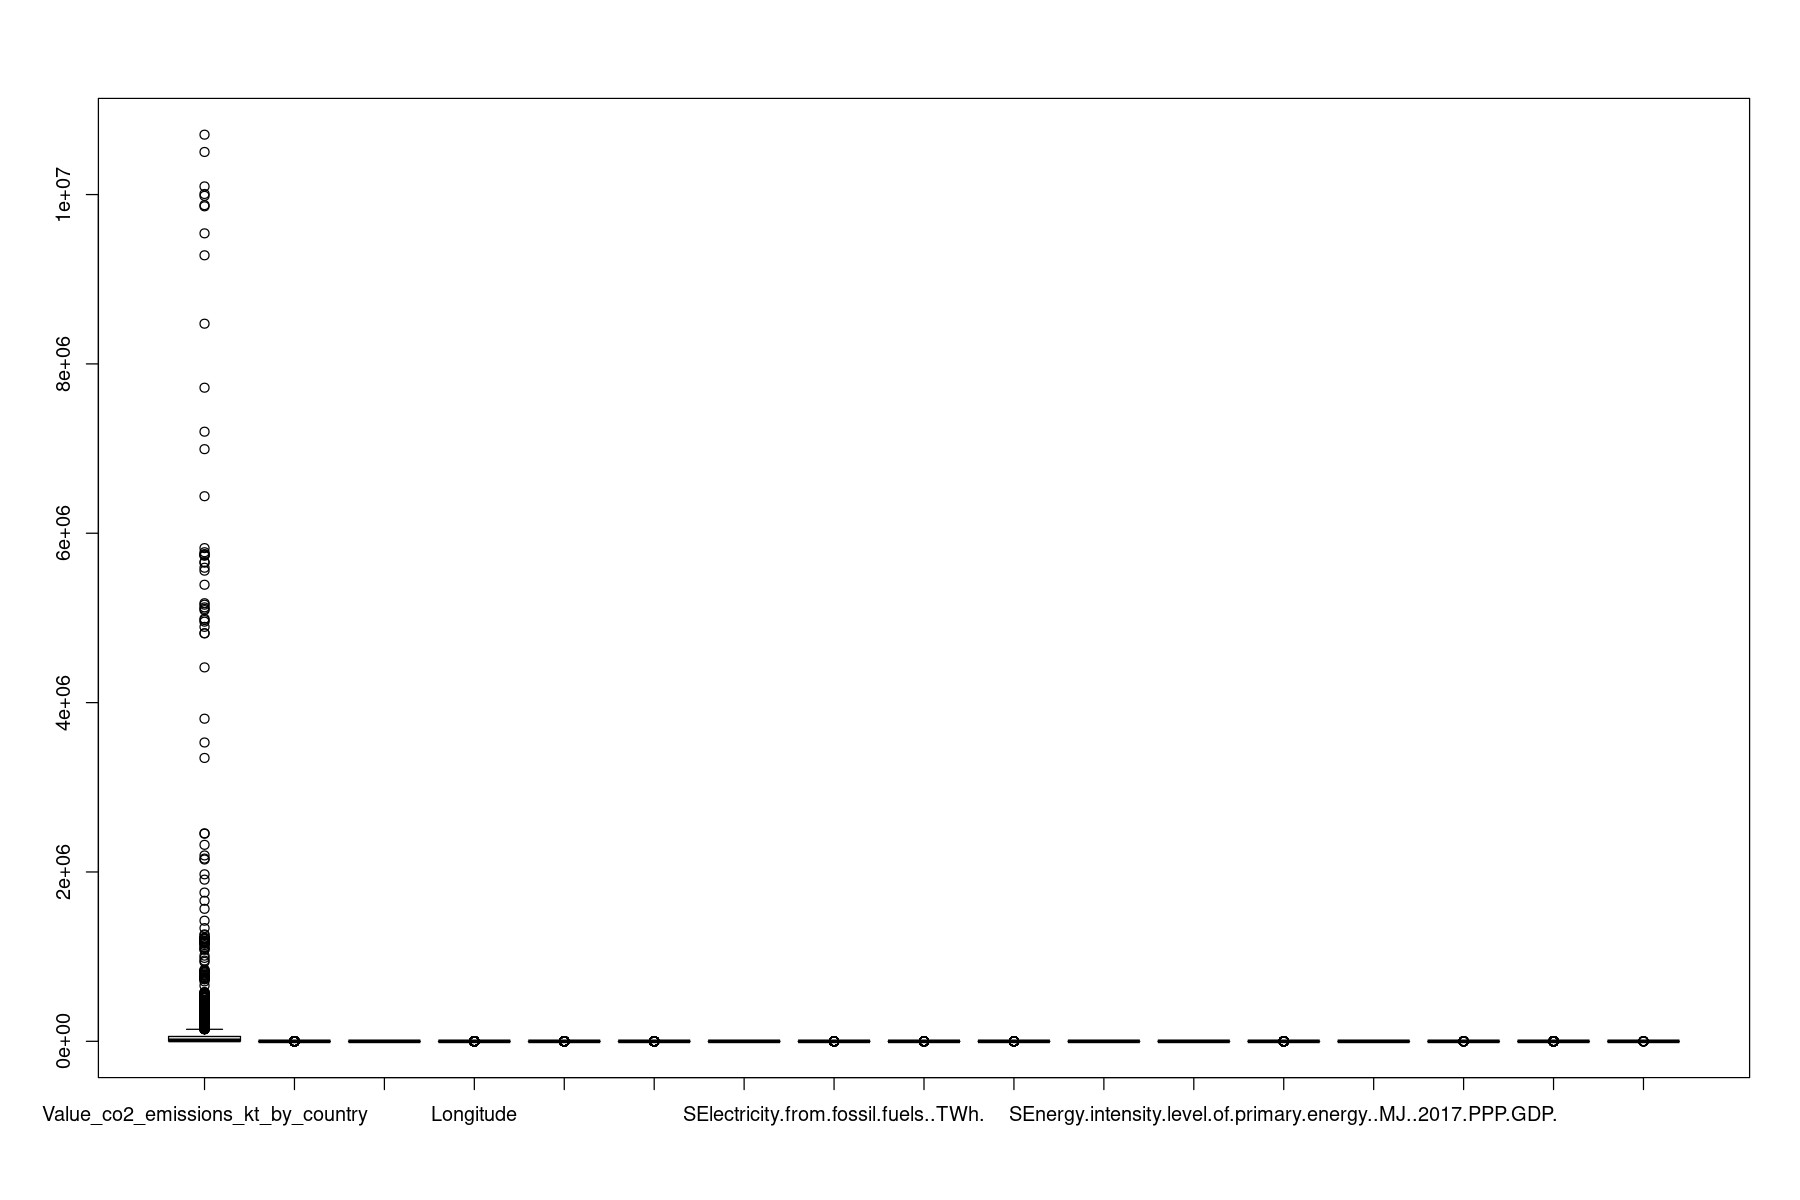

In [39]:
boxplot(complete_energy[,-c(1,2)])

On affiche toutes les variables, mais comme elles n'ont pas la même échelle, c'est difficile à interpréter.

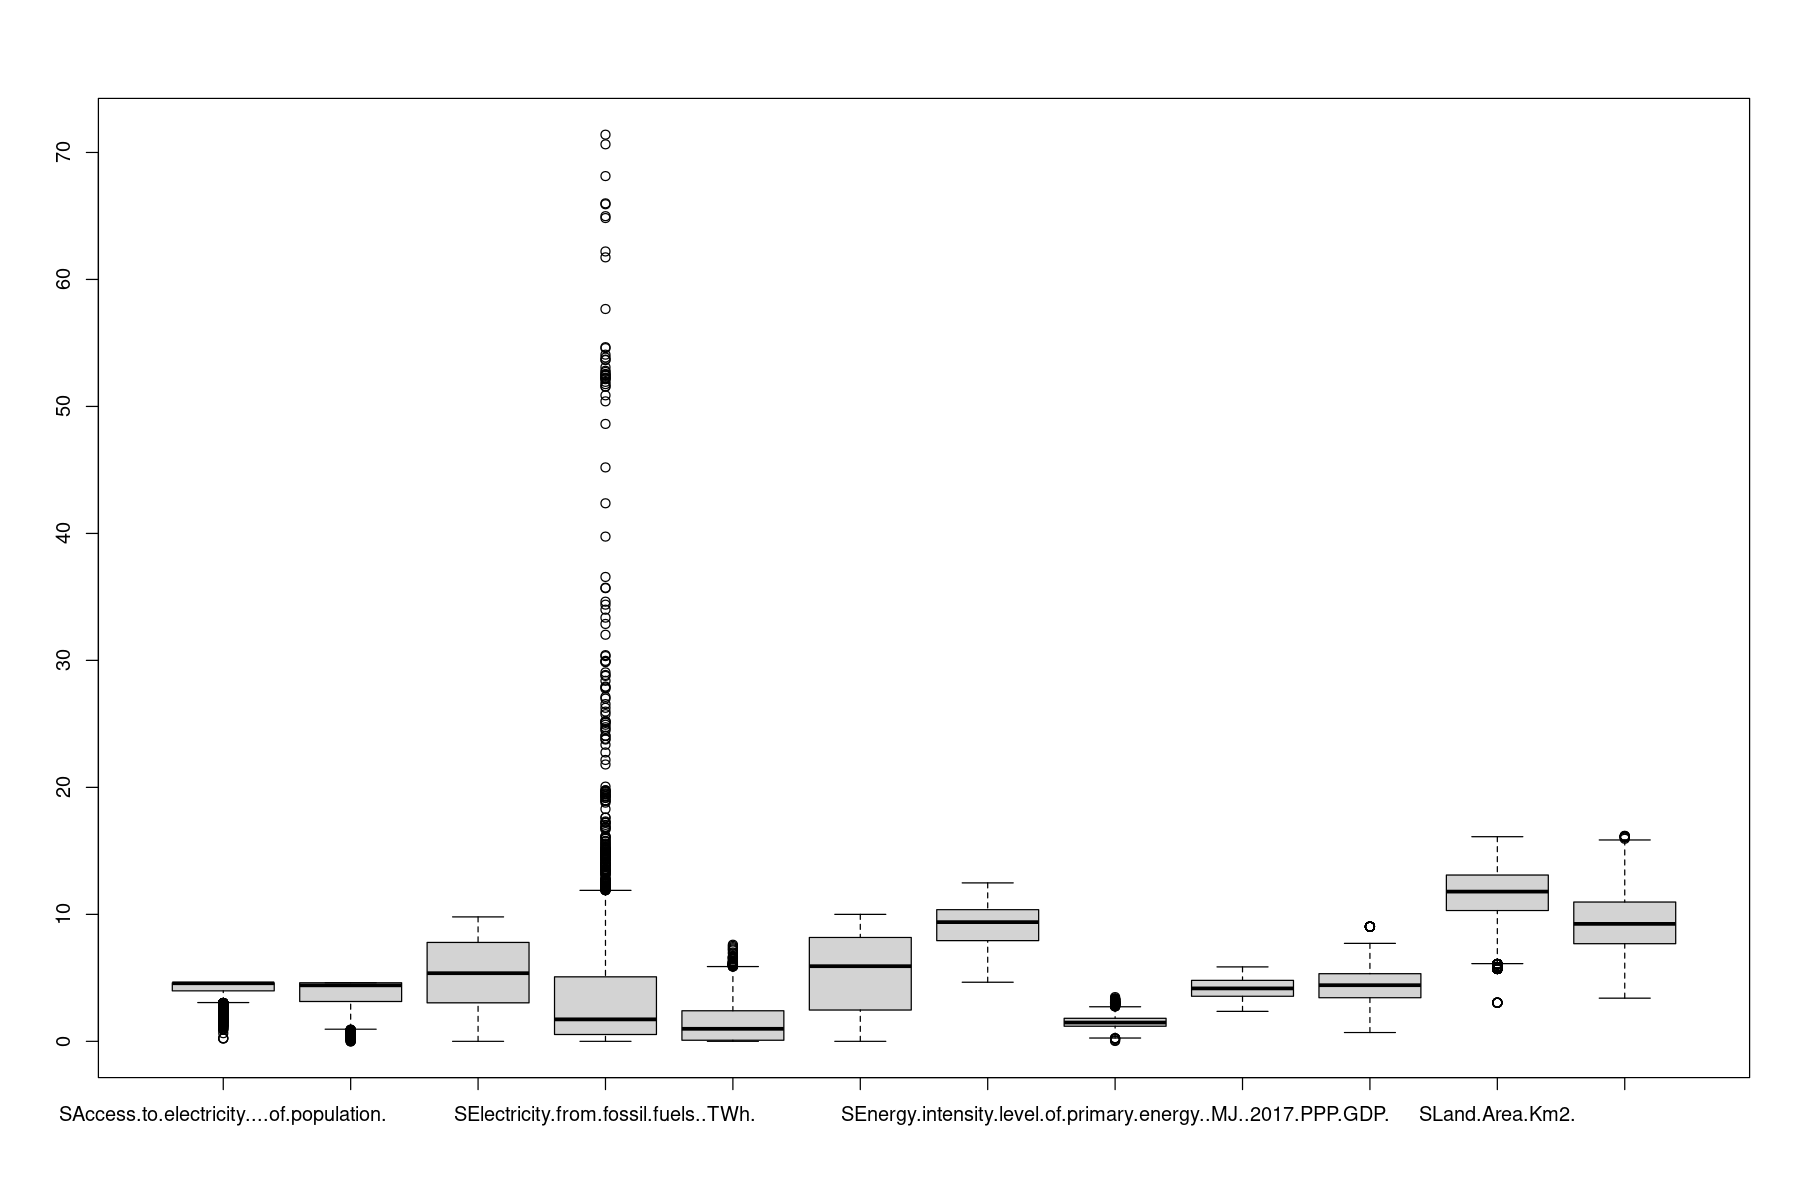

In [40]:
boxplot(complete_energy[,-c(1:6,11)])

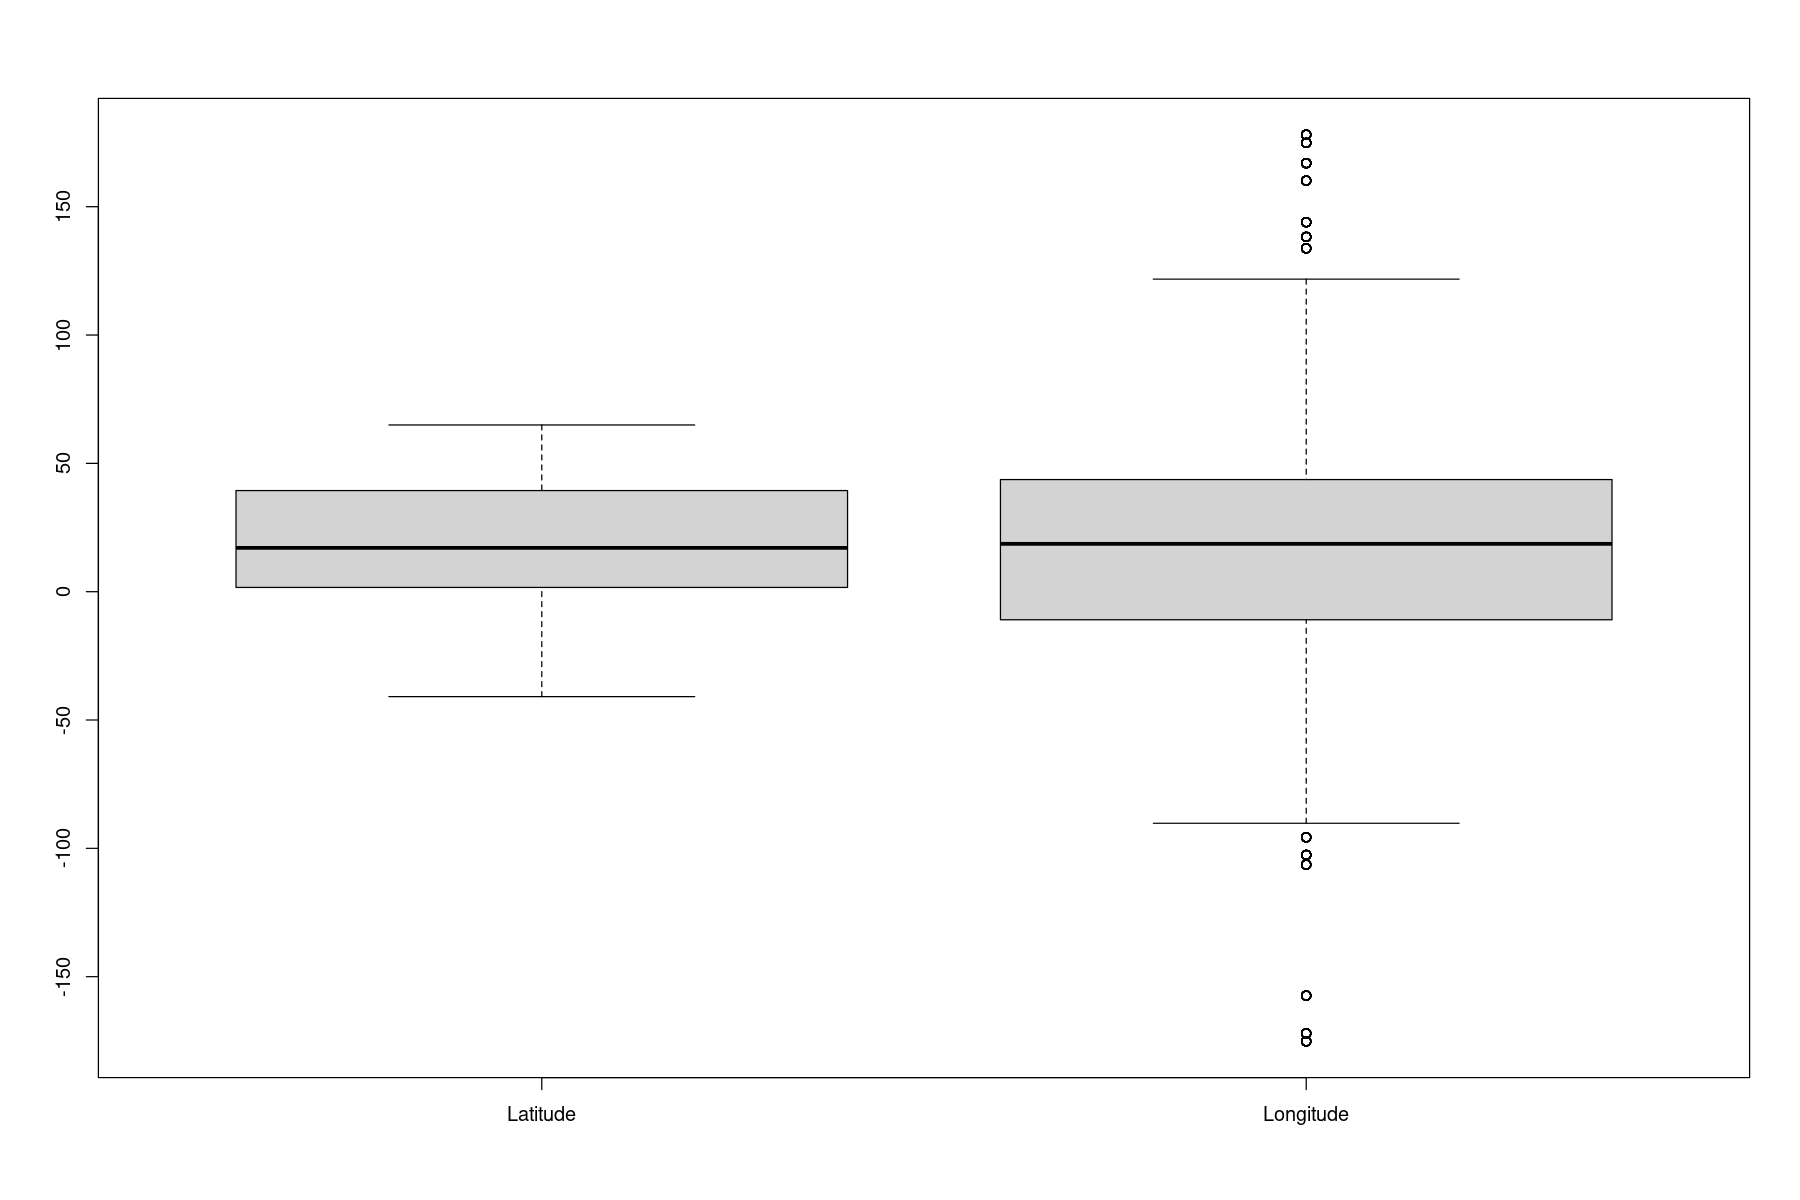

In [41]:
boxplot(complete_energy[,c(5:6)])

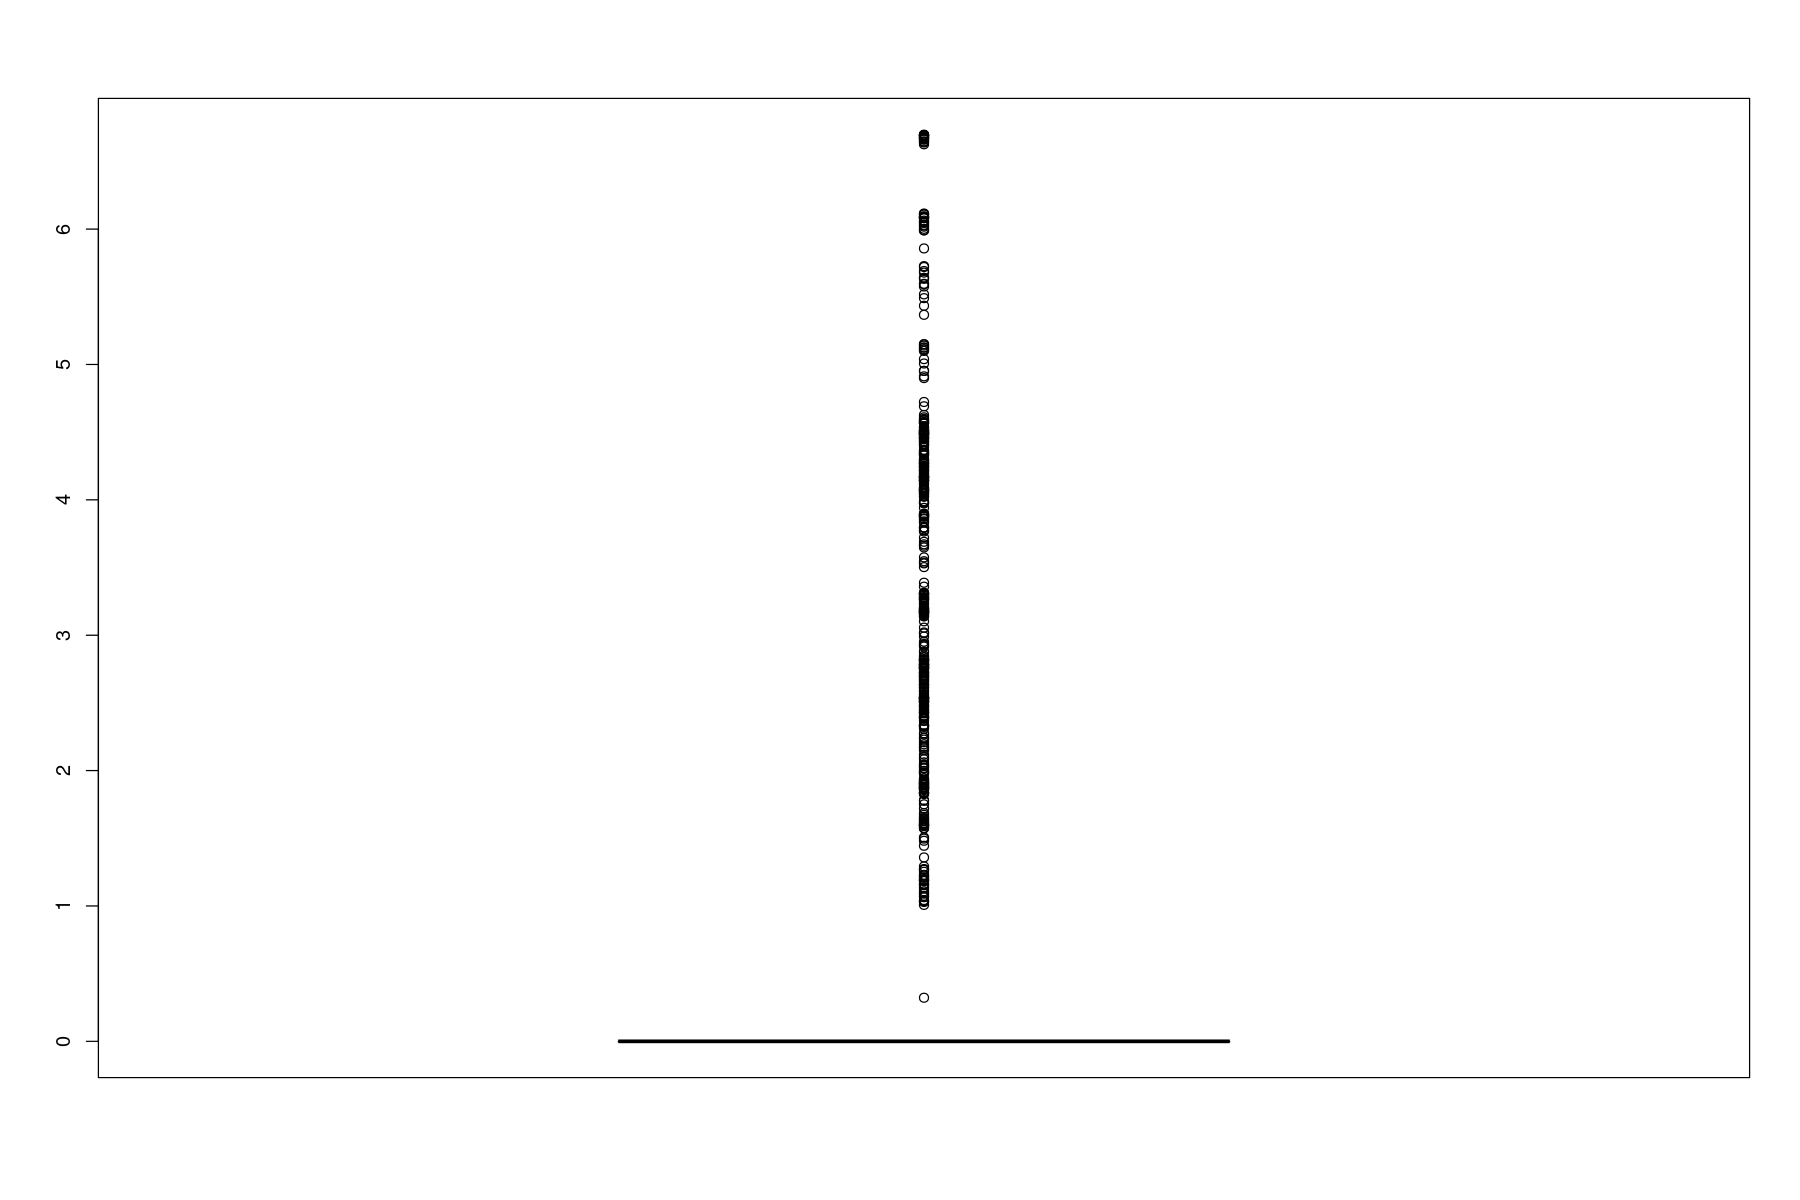

In [42]:
boxplot(complete_energy[,c(11)]) #nuclear

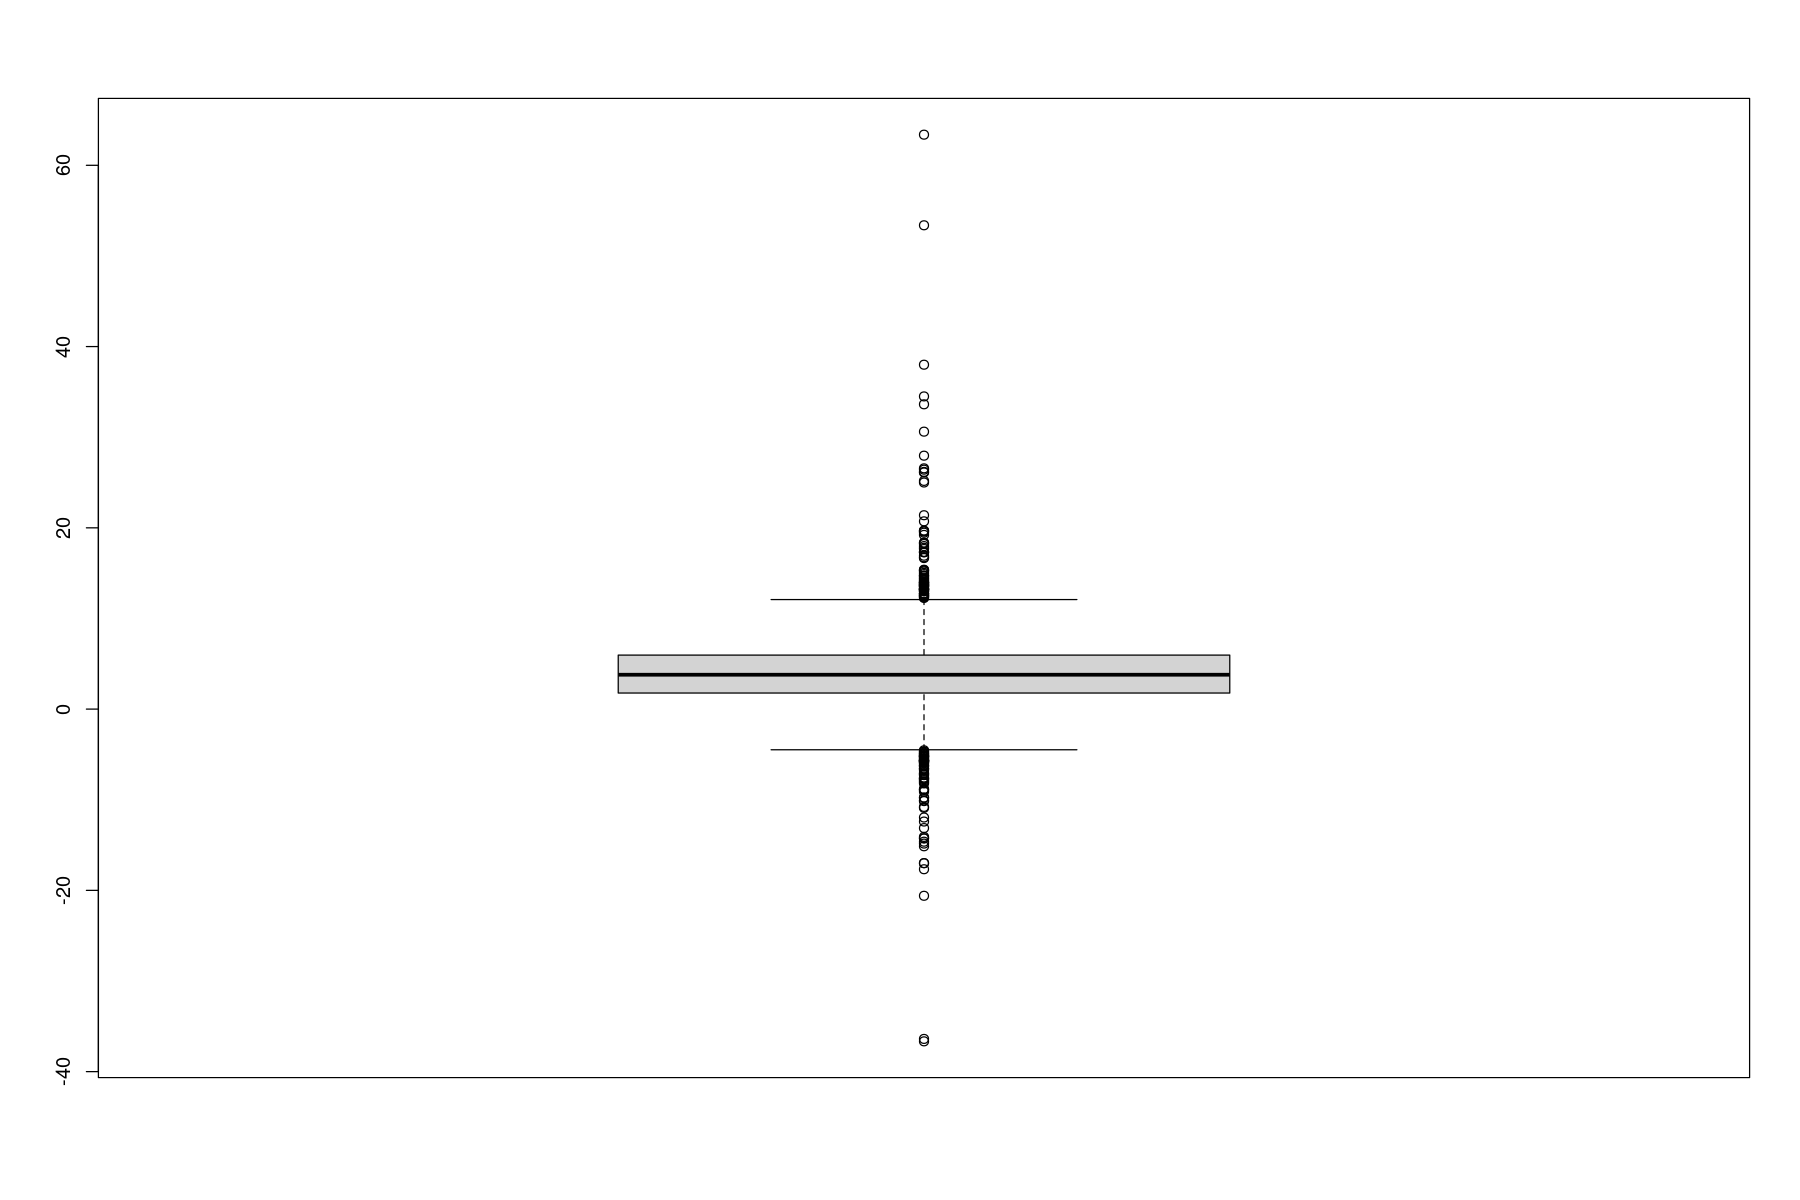

In [43]:
boxplot(complete_energy[,c(4)]) #gdp growth

On ne regarde à présent que les variables transformée. L'échelle est meilleure

## Question 5

### Hétérogénéité d'émission de CO2 de pays

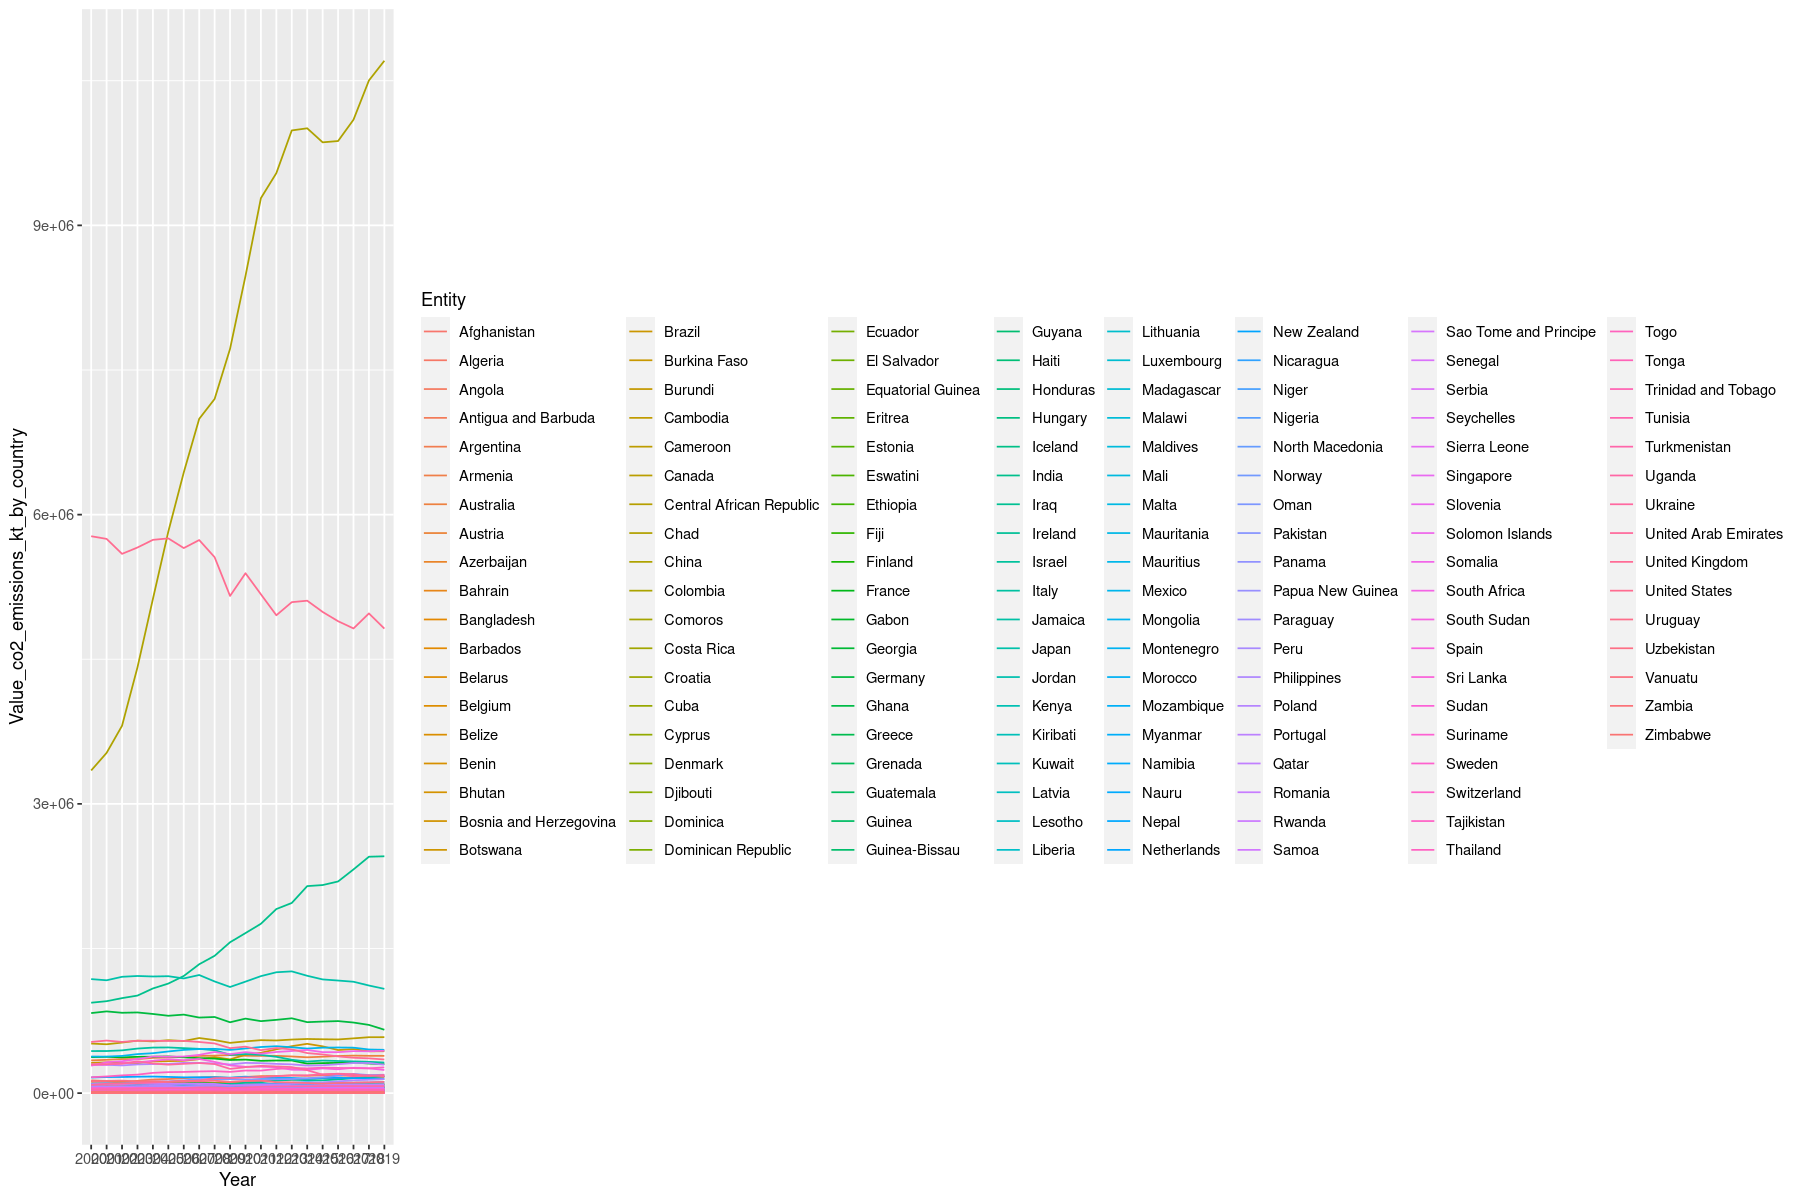

In [44]:
ggplot(complete_energy) + 
  aes(x = Year, y = Value_co2_emissions_kt_by_country, color = Entity, group = Entity) + 
  geom_line() + 
  theme(legend.position = "right")


In [45]:
paste('ecart type')
sd(complete_energy$Value_co2_emissions_kt_by_country)
paste('moyenne :')
mean(complete_energy$Value_co2_emissions_kt_by_country)
paste('min')
min(complete_energy$Value_co2_emissions_kt_by_country)
paste('max')
max(complete_energy$Value_co2_emissions_kt_by_country)

[1] "ecart type"

[1] 818020.2

[1] "moyenne :"

[1] 168818.2

[1] "min"

[1] 30

[1] "max"

[1] 10707220

Ici nous pouvons observer que l'écart type de la variable Value CO2 est très grande, ce qui témoigne d'une hétérogéneité des valeurs par rapport à la répartition moyenne. De plus le graphique que les 5 pays ayant une emission de CO2 la plus importante sont :

### Les pays les plus émetteurs de CO2

Entity        Value_co2_emissions_kt_by_country
28  China         7636642.5                        
143 United States 5329538.5                        
63  India         1633979.0                        
69  Japan         1183734.5                        
51  Germany        773644.5                        
25  Canada         547644.5

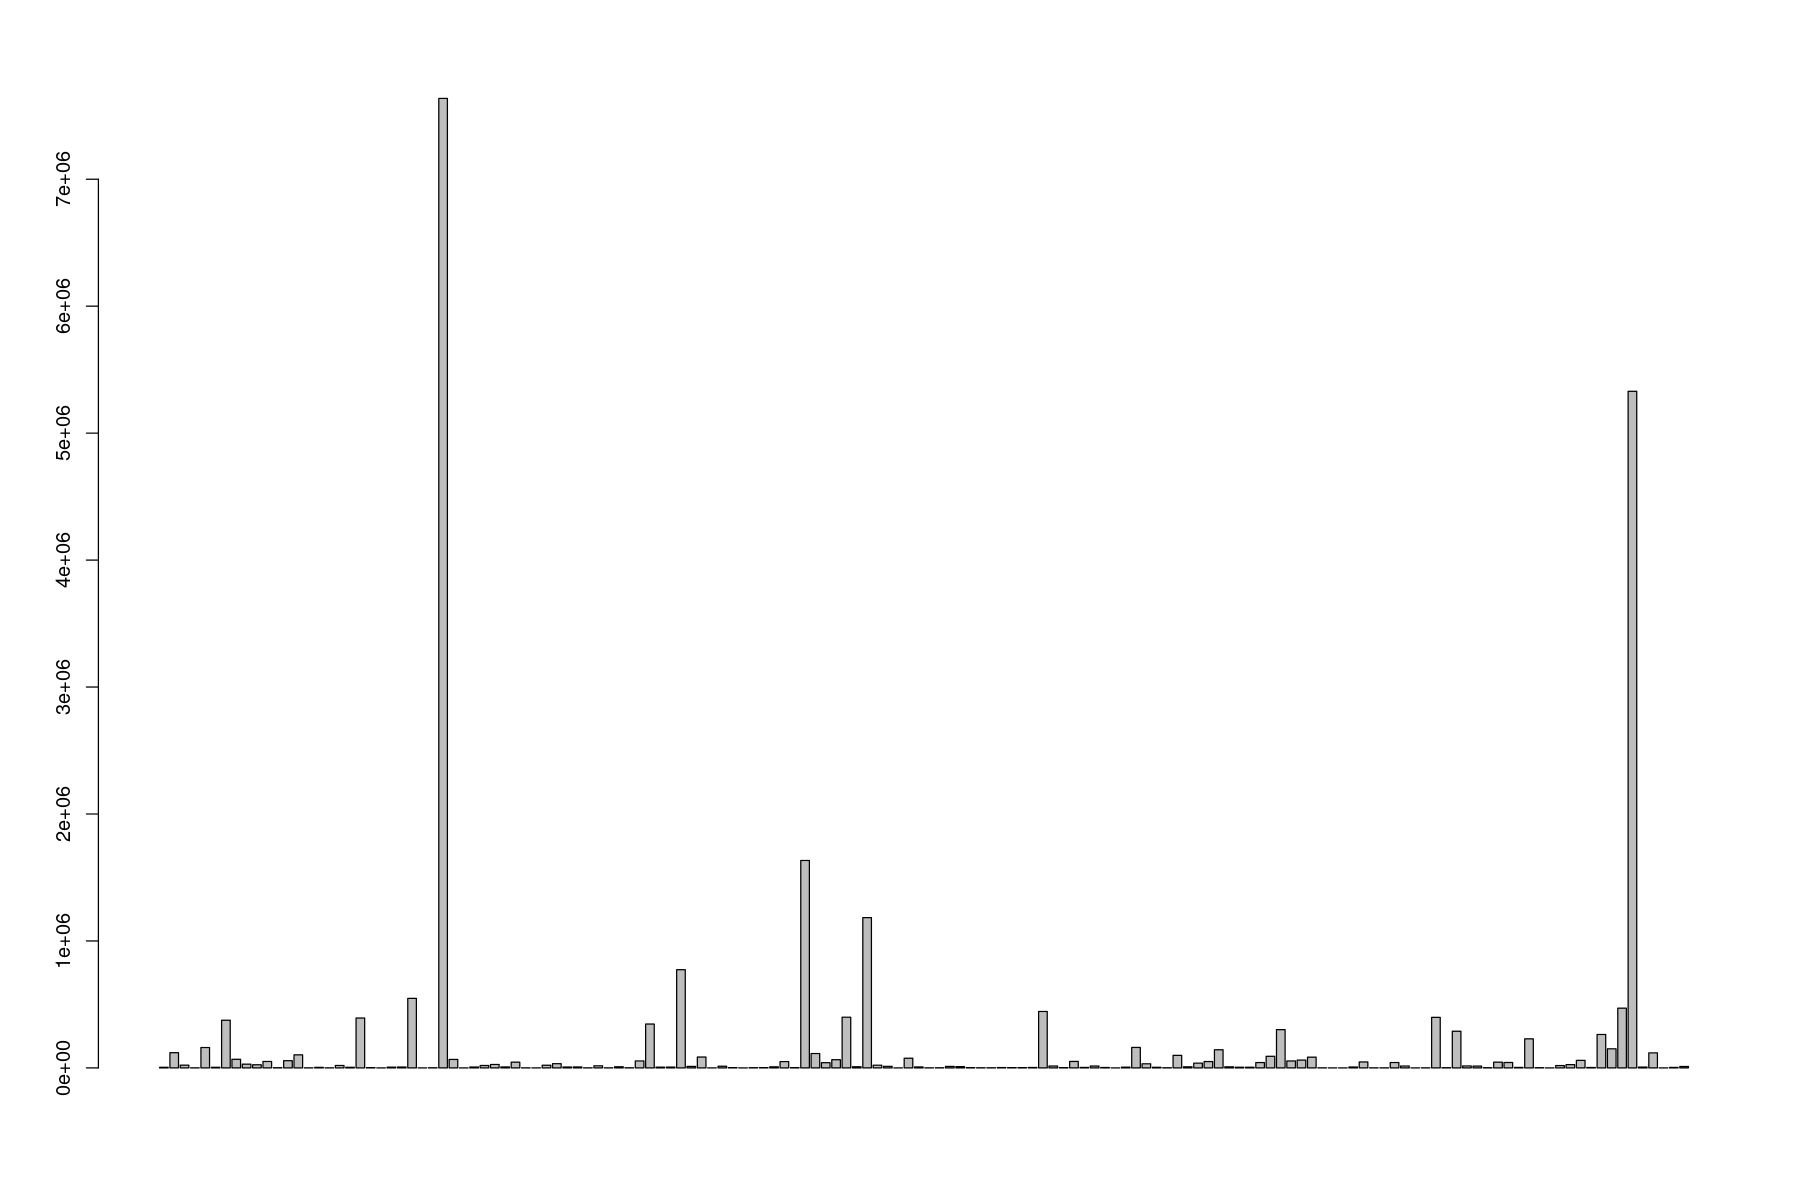

In [46]:
Moy = aggregate(data=complete_energy,Value_co2_emissions_kt_by_country~Entity,FUN=mean)
index = order(Moy$Value_co2_emissions_kt_by_country, decreasing = TRUE )
Moy_classe = Moy[index,]
head(Moy_classe)
barplot(Moy[,2])

Grace à ce tableau, nous pouvons observer l'emission moyenne de CO2 emise par pays ( triée par ordre décroissant ).
Ainsi, nous pouvons donc observer que les 5 pays les plus émetteurs sont : Chine / Etats-Unis / Inde / Japon / Allemagne

## Question 6 

### Analyse descriptive multidimensionnelle

#### Variable quantitative

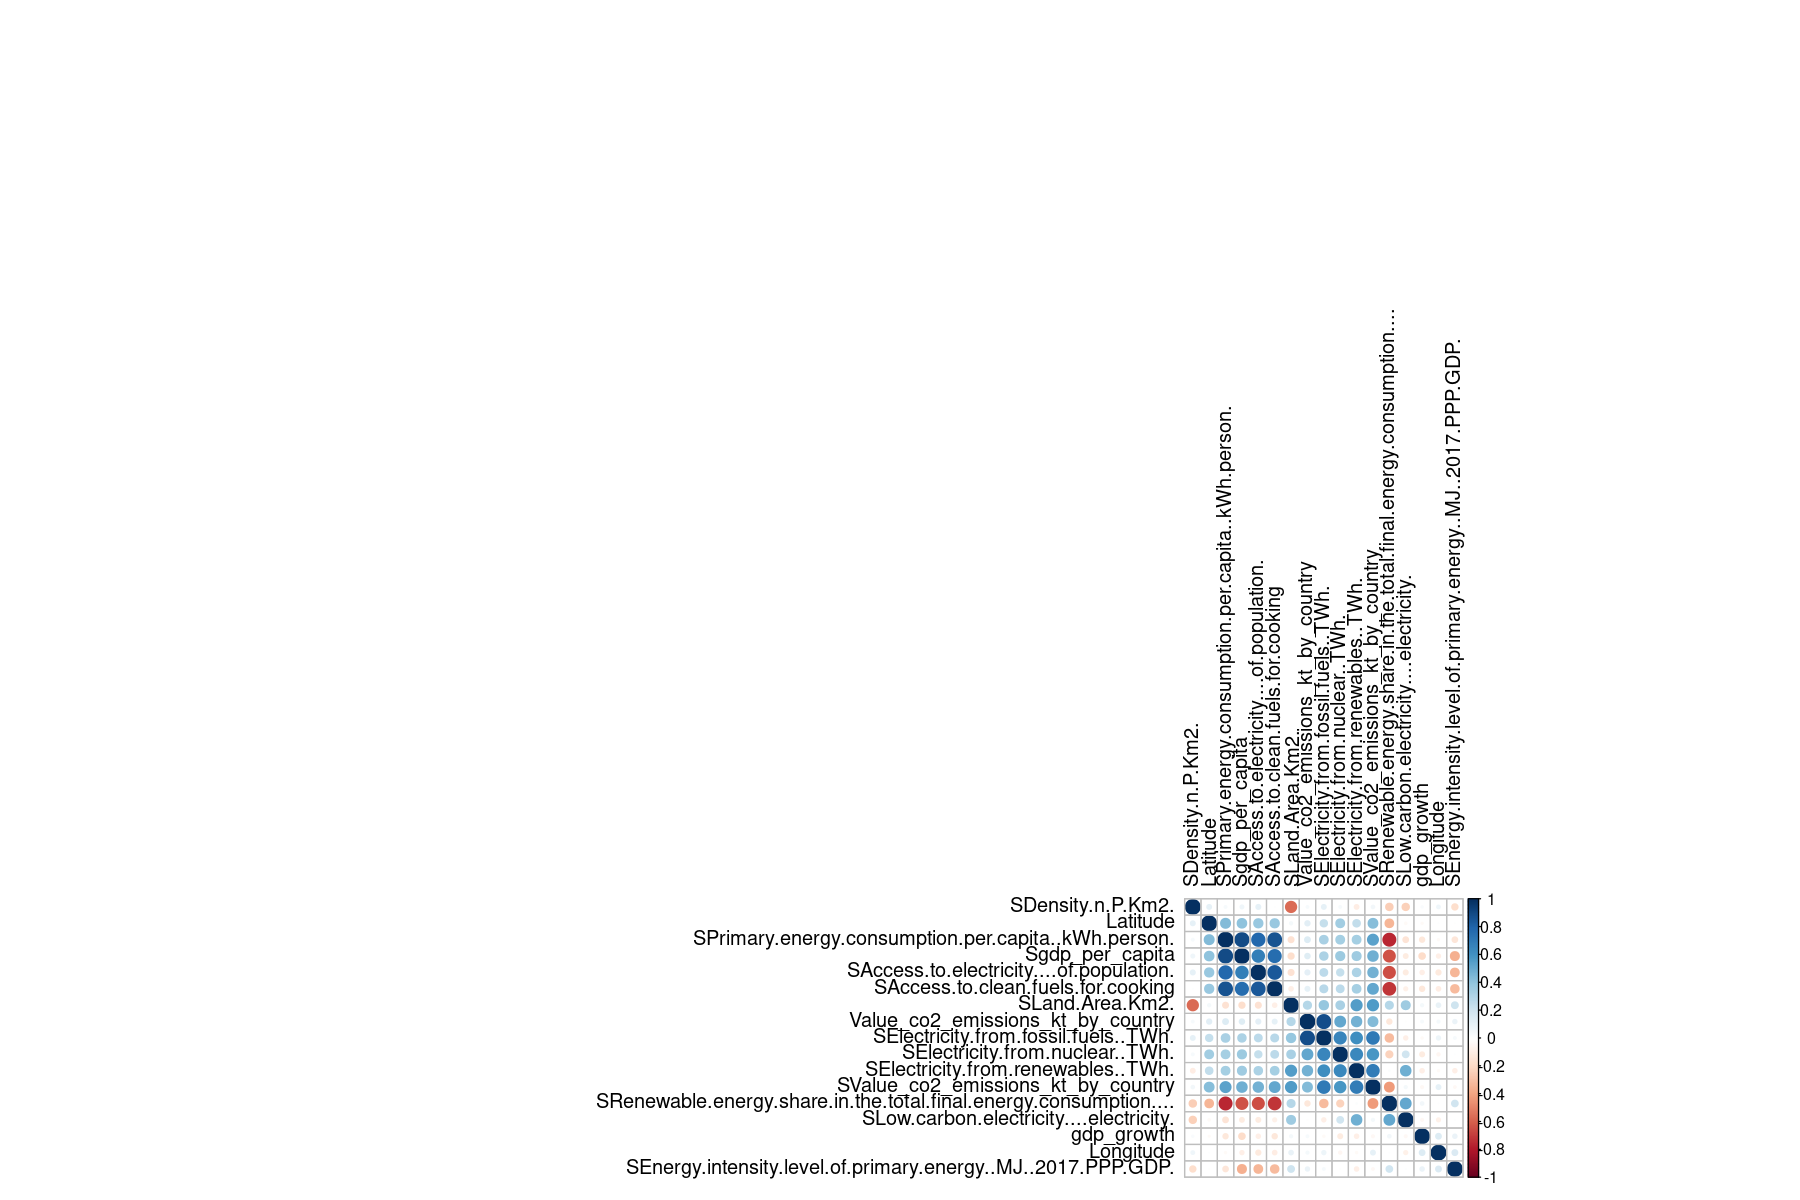

In [47]:
numeric_energy =complete_energy[sapply(complete_energy, is.numeric)]
mcor <- cor(numeric_energy)
par(mfrow=c(1,1), mar=c(5,5,2,2))
corrplot(mcor, order="hclust", tl.col="black")

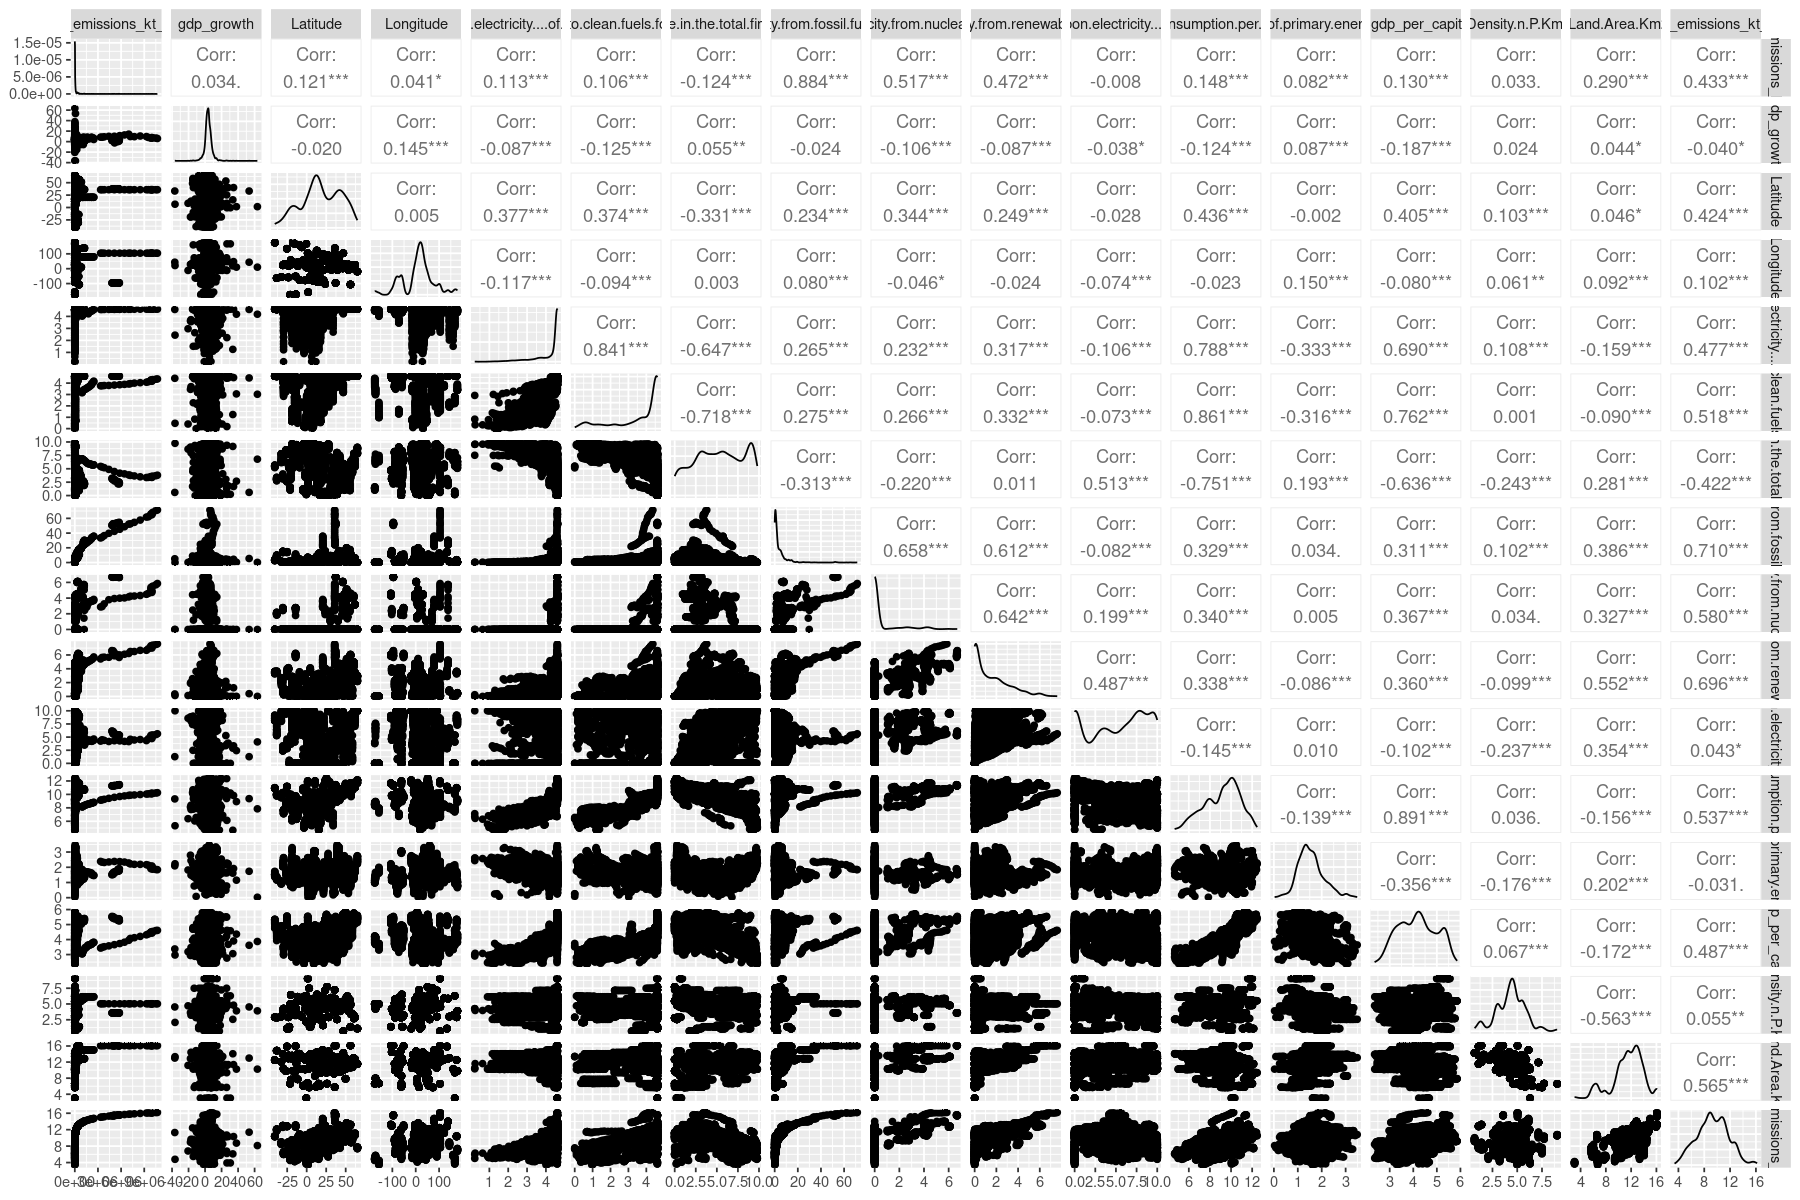

In [48]:
ggpairs(numeric_energy)

In [49]:
#par(mfrow = c(6,3) , mar = c(4,4,2,1))

#for (i in 3:length(names(complete_energy))) {
 #   dfi = complete_energy[,c(2,i)]
   # plot(dfi, main=names(complete_energy)[i],xlab='Values')
#}

#### Variable qualitative

Pour cette étude, nous avons essayé plusieurs techniques pour visualiser nos données. Cependant nous avons pu remarquer que le nombre d'observations par pays n'est pas identique en fonction des années, ce qui ne rend pas forcément fiable nos exploitations.En effet, nous avons également essayé d'afficher des boxplots de l'ensemble des variables en fonction de Year, mais ce n'était pas très pertinent.   

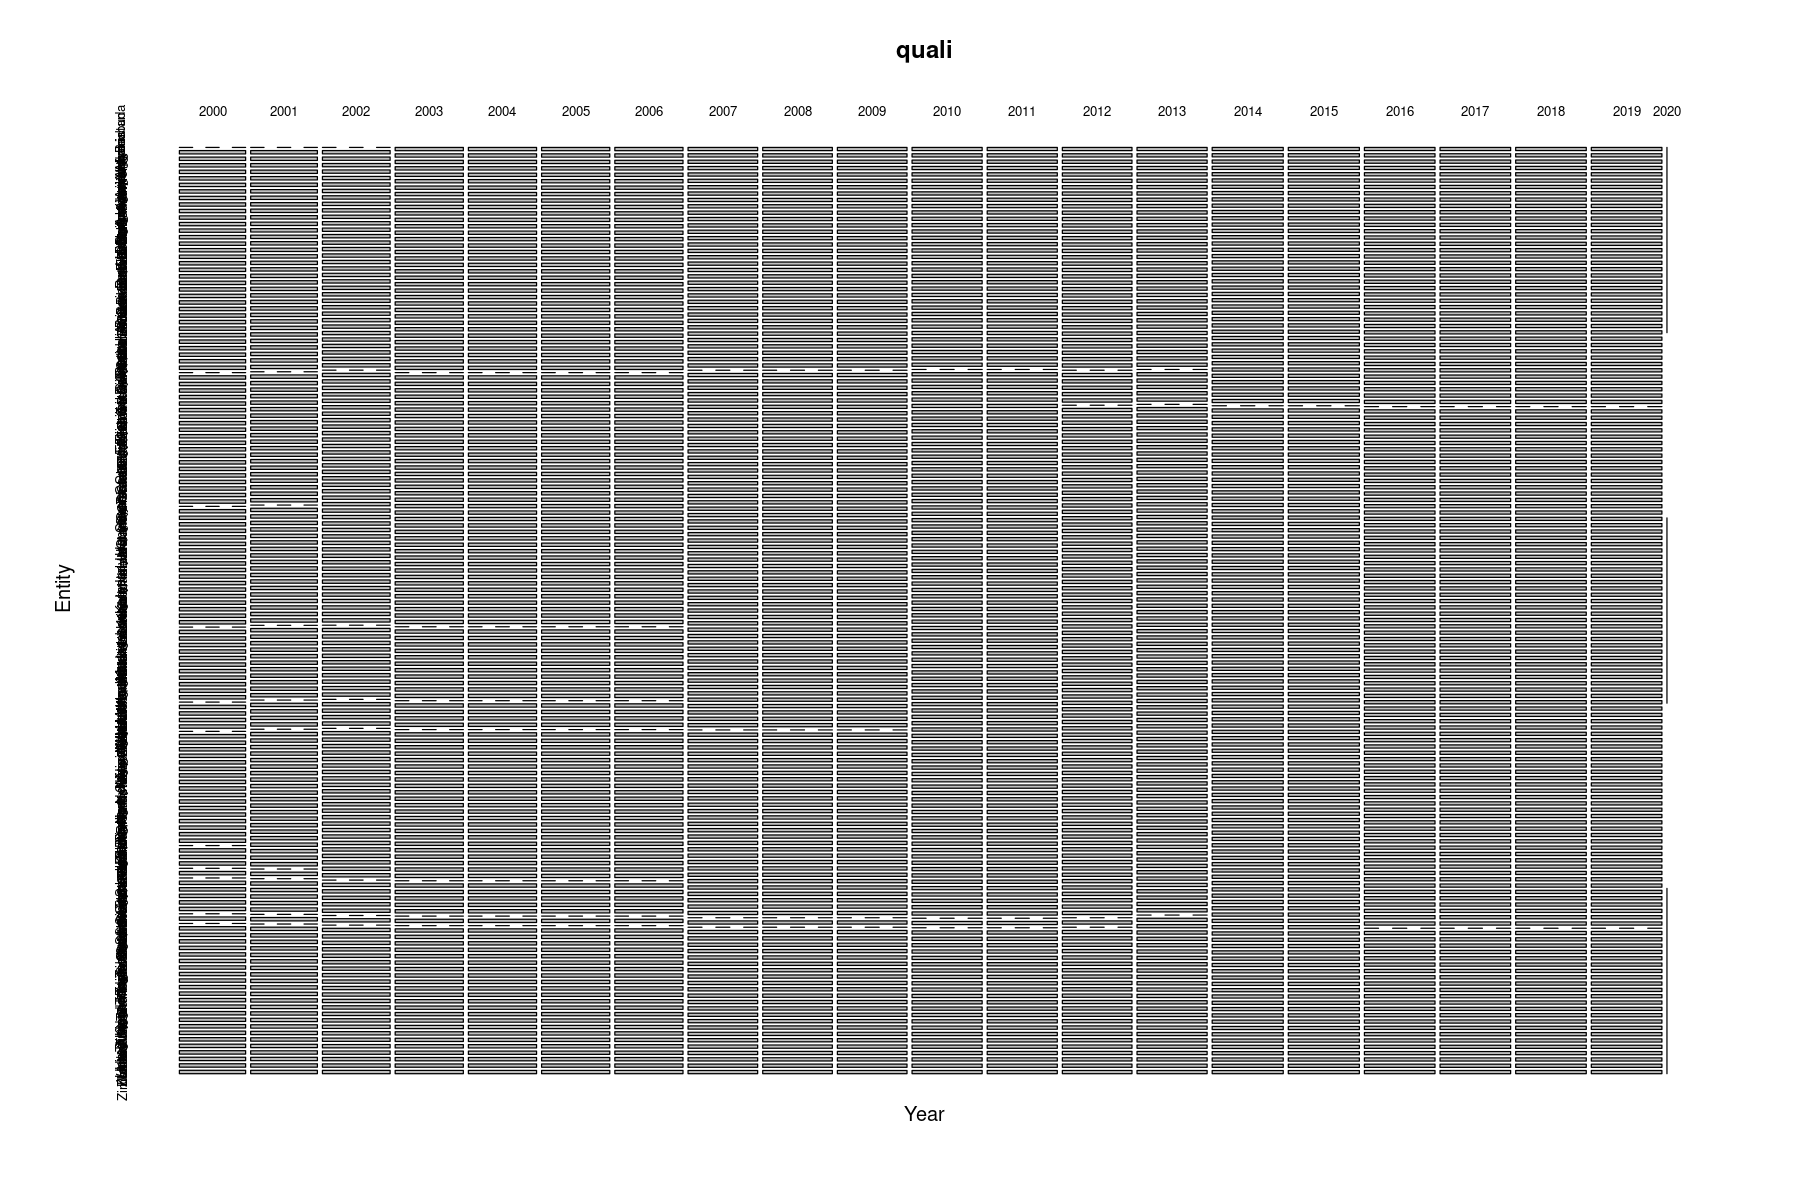

In [50]:
quali= xtabs(~Year + Entity, data = complete_energy)
mosaicplot(quali)

## Question 8

### Dépendance entre Year et la variable à prédire

In [51]:
numeric_energy =complete_energy[sapply(complete_energy, is.numeric)]
mcor <- cor(numeric_energy)
mcor

Value_co2_emissions_kt_by_country
Value_co2_emissions_kt_by_country                                  1.000000000                     
gdp_growth                                                         0.034117009                     
Latitude                                                           0.120536382                     
Longitude                                                          0.041251083                     
SAccess.to.electricity....of.population.                           0.113086972                     
SAccess.to.clean.fuels.for.cooking                                 0.106404221                     
SRenewable.energy.share.in.the.total.final.energy.consumption.... -0.124085468                     
SElectricity.from.fossil.fuels..TWh.                               0.884187976                     
SElectricity.from.nuclear..TWh.                                    0.516949866                     
SElectricity.from.renewables..TWh.                                 0.471864935                     
SLow.carbon.electricity....electricity.                           -0.007522328                     
SPrimary.energy.consumption.per.capita..kWh.person.                0.147546520                     
SEnergy.intensity.level.of.primary.energy..MJ..2017.PPP.GDP.       0.082319000                     
Sgdp_per_capita                                                    0.130053676                     
SDensity.n.P.Km2.                                                  0.032995225                     
SLand.Area.Km2.                                                    0.289812800                     
SValue_co2_emissions_kt_by_country                                 0.432835142                     
                                                                  gdp_growth 
Value_co2_emissions_kt_by_country                                  0.03411701
gdp_growth                                                         1.00000000
Latitude                                                          -0.02015532
Longitude                                                          0.14542437
SAccess.to.electricity....of.population.                          -0.08667138
SAccess.to.clean.fuels.for.cooking                                -0.12506100
SRenewable.energy.share.in.the.total.final.energy.consumption....  0.05468604
SElectricity.from.fossil.fuels..TWh.                              -0.02392442
SElectricity.from.nuclear..TWh.                                   -0.10640649
SElectricity.from.renewables..TWh.                                -0.08729166
SLow.carbon.electricity....electricity.                           -0.03839108
SPrimary.energy.consumption.per.capita..kWh.person.               -0.12381293
SEnergy.intensity.level.of.primary.energy..MJ..2017.PPP.GDP.       0.08686496
Sgdp_per_capita                                                   -0.18713373
SDensity.n.P.Km2.                                                  0.02448516
SLand.Area.Km2.                                                    0.04376595
SValue_co2_emissions_kt_by_country                                -0.03950100
                                                                  Latitude    
Value_co2_emissions_kt_by_country                                  0.120536382
gdp_growth                                                        -0.020155317
Latitude                                                           1.000000000
Longitude                                                          0.005383208
SAccess.to.electricity....of.population.                           0.377298604
SAccess.to.clean.fuels.for.cooking                                 0.374115257
SRenewable.energy.share.in.the.total.final.energy.consumption.... -0.331451213
SElectricity.from.fossil.fuels..TWh.                               0.234446949
SElectricity.from.nuclear..TWh.                                    0.343511618
SElectricity.from.renewables..TWh.                                 0.249

Ici, nous avons la matrice de corrélation entre toutes les variables de notre energyset. En effet, on peut voir que la corrélation entre la variable Year et Value_co2_emissions_kt_by_country semble faible. Sa valeur faut 0.02055306	

On voit ici que la corrélation entre les variables Year et Value_co2 est très faible. En effet, on obtient un coefficient de corélation proche de 0, ce qui montre que les deux variables ne sont pas coorélées.

In [52]:
correlation_value=cor(as.numeric(complete_energy$Year), complete_energy$Value_co2_emissions_kt_by_country)
print(correlation_value) # méthode pour avoir le coefficient directement 

[1] 0.02055306


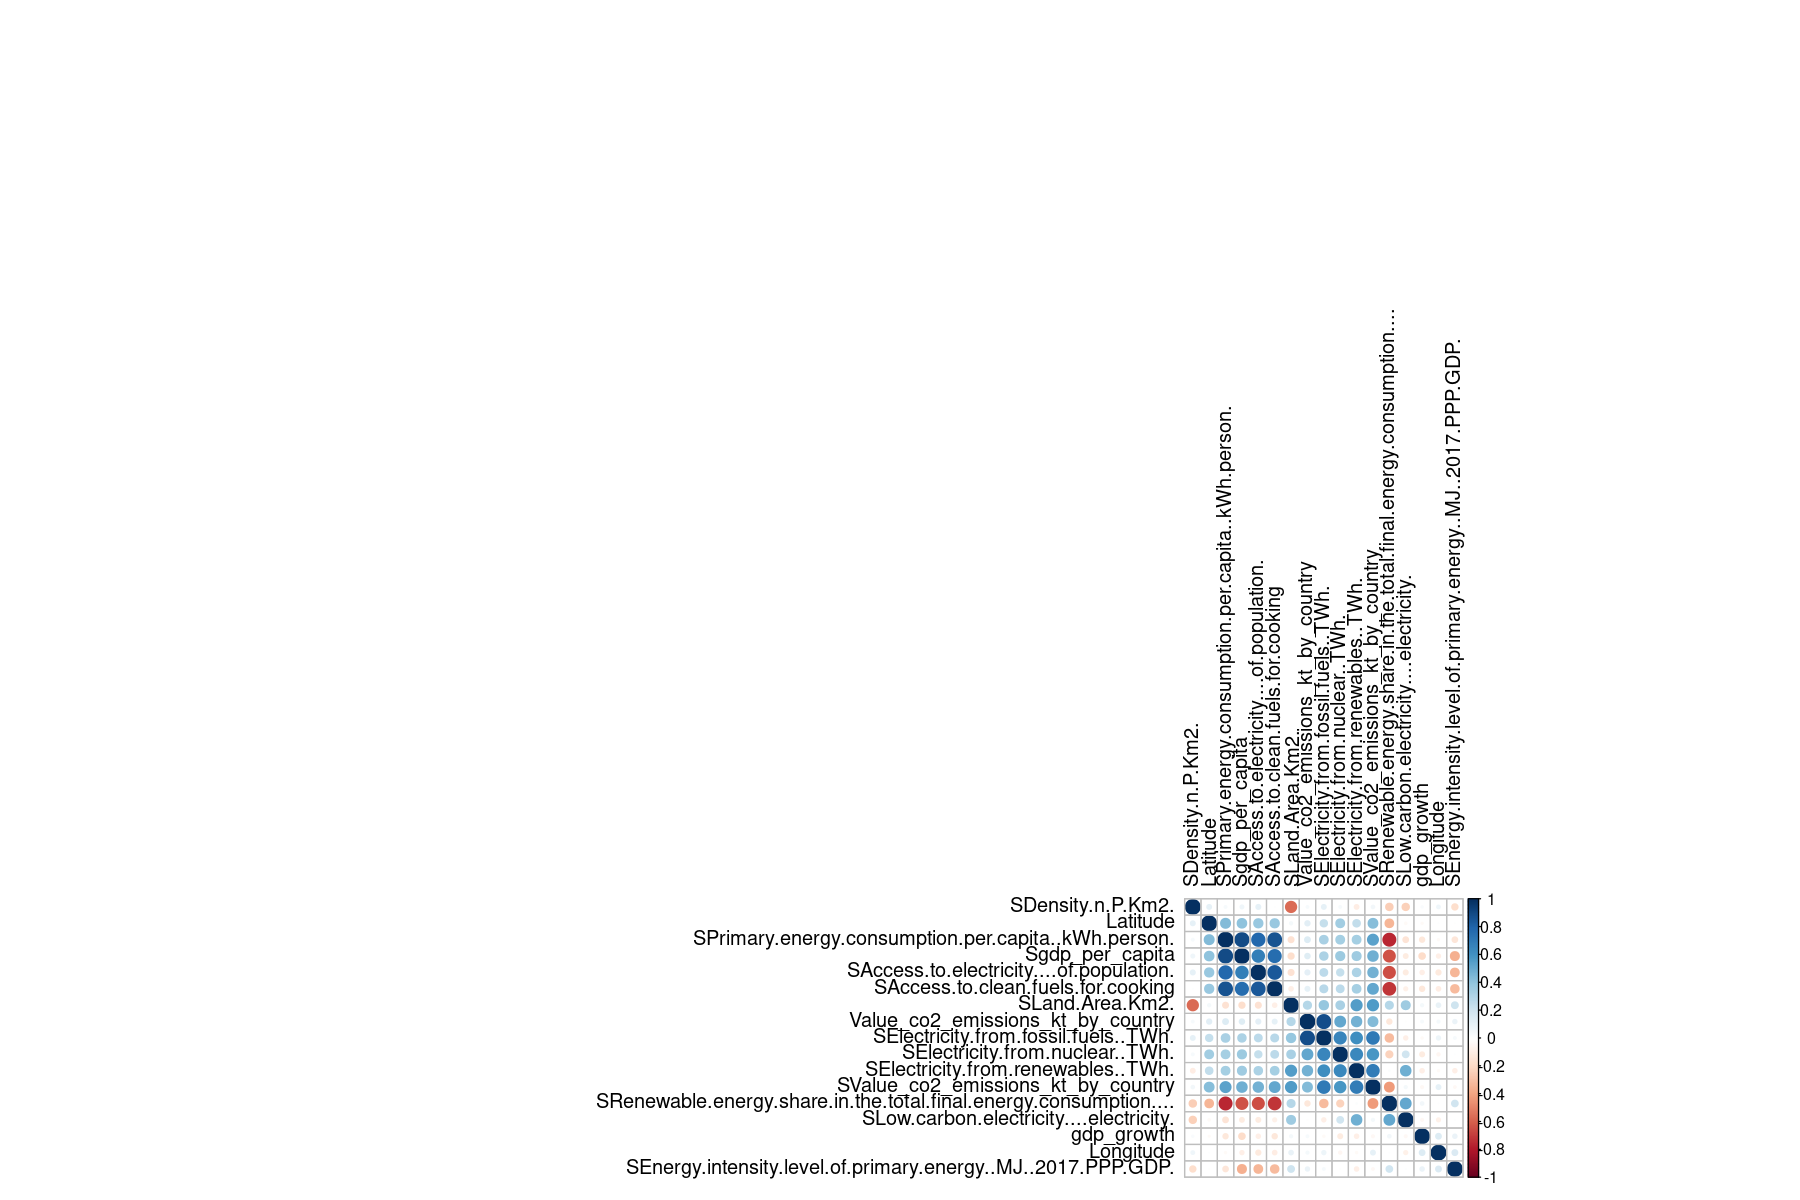

In [53]:
options(corrplot.width = 15, corrplot.height = 10)
corrplot(mcor, order="hclust", tl.col="black")

Ce graphique nous donne la corrélation entre chaque point. En effet, on peut par exemple voir que la variable Value_co2_emissions_kt_by_country est bien corrélée car elle est proche de 1. Au contraire, la longitude n'est pas bine représentée, on peut pas avoir réellement confiance en ses valeurs. 
De plus, si nous comparons les variables Electricity.from.renewables et Value_co2_emissions_kt_by_country, l'angle entre les deux est très faible, ce qui signifie qu'elles sont bien corrélées en elles. A l'inverse, les variables Value_co2_emissions_kt_by_country et Renewable.energy.share.in.the.total.final.energy.consumption ont un angle quasi droit entre elles, ce qui indique qu'elles sont indépendantes.

## Question 7

In [54]:
complete_energy = complete_energy[-c(3)]

### Analyse en composante principale

In [55]:
energy_pca = scale(complete_energy[,-c(1,2)], center = TRUE, scale = TRUE)

In [56]:
resultat_pca = PCA(energy_pca,ncp = 17)
get_eig(resultat_pca)

eigenvalue  variance.percent cumulative.variance.percent
Dim.1  5.484759138 34.27974461       34.27974                  
Dim.2  2.991178926 18.69486828       52.97461                  
Dim.3  1.522017152  9.51260720       62.48722                  
Dim.4  1.173257491  7.33285932       69.82008                  
Dim.5  0.984740573  6.15462858       75.97471                  
Dim.6  0.865739312  5.41087070       81.38558                  
Dim.7  0.844580761  5.27862976       86.66421                  
Dim.8  0.633640931  3.96025582       90.62446                  
Dim.9  0.480224132  3.00140083       93.62587                  
Dim.10 0.296853269  1.85533293       95.48120                  
Dim.11 0.269506708  1.68441692       97.16561                  
Dim.12 0.184078742  1.15049213       98.31611                  
Dim.13 0.122602638  0.76626649       99.08237                  
Dim.14 0.101238596  0.63274122       99.71511                  
Dim.15 0.038753005  0.24220628       99.95732                  
Dim.16 0.006828628  0.04267892      100.00000

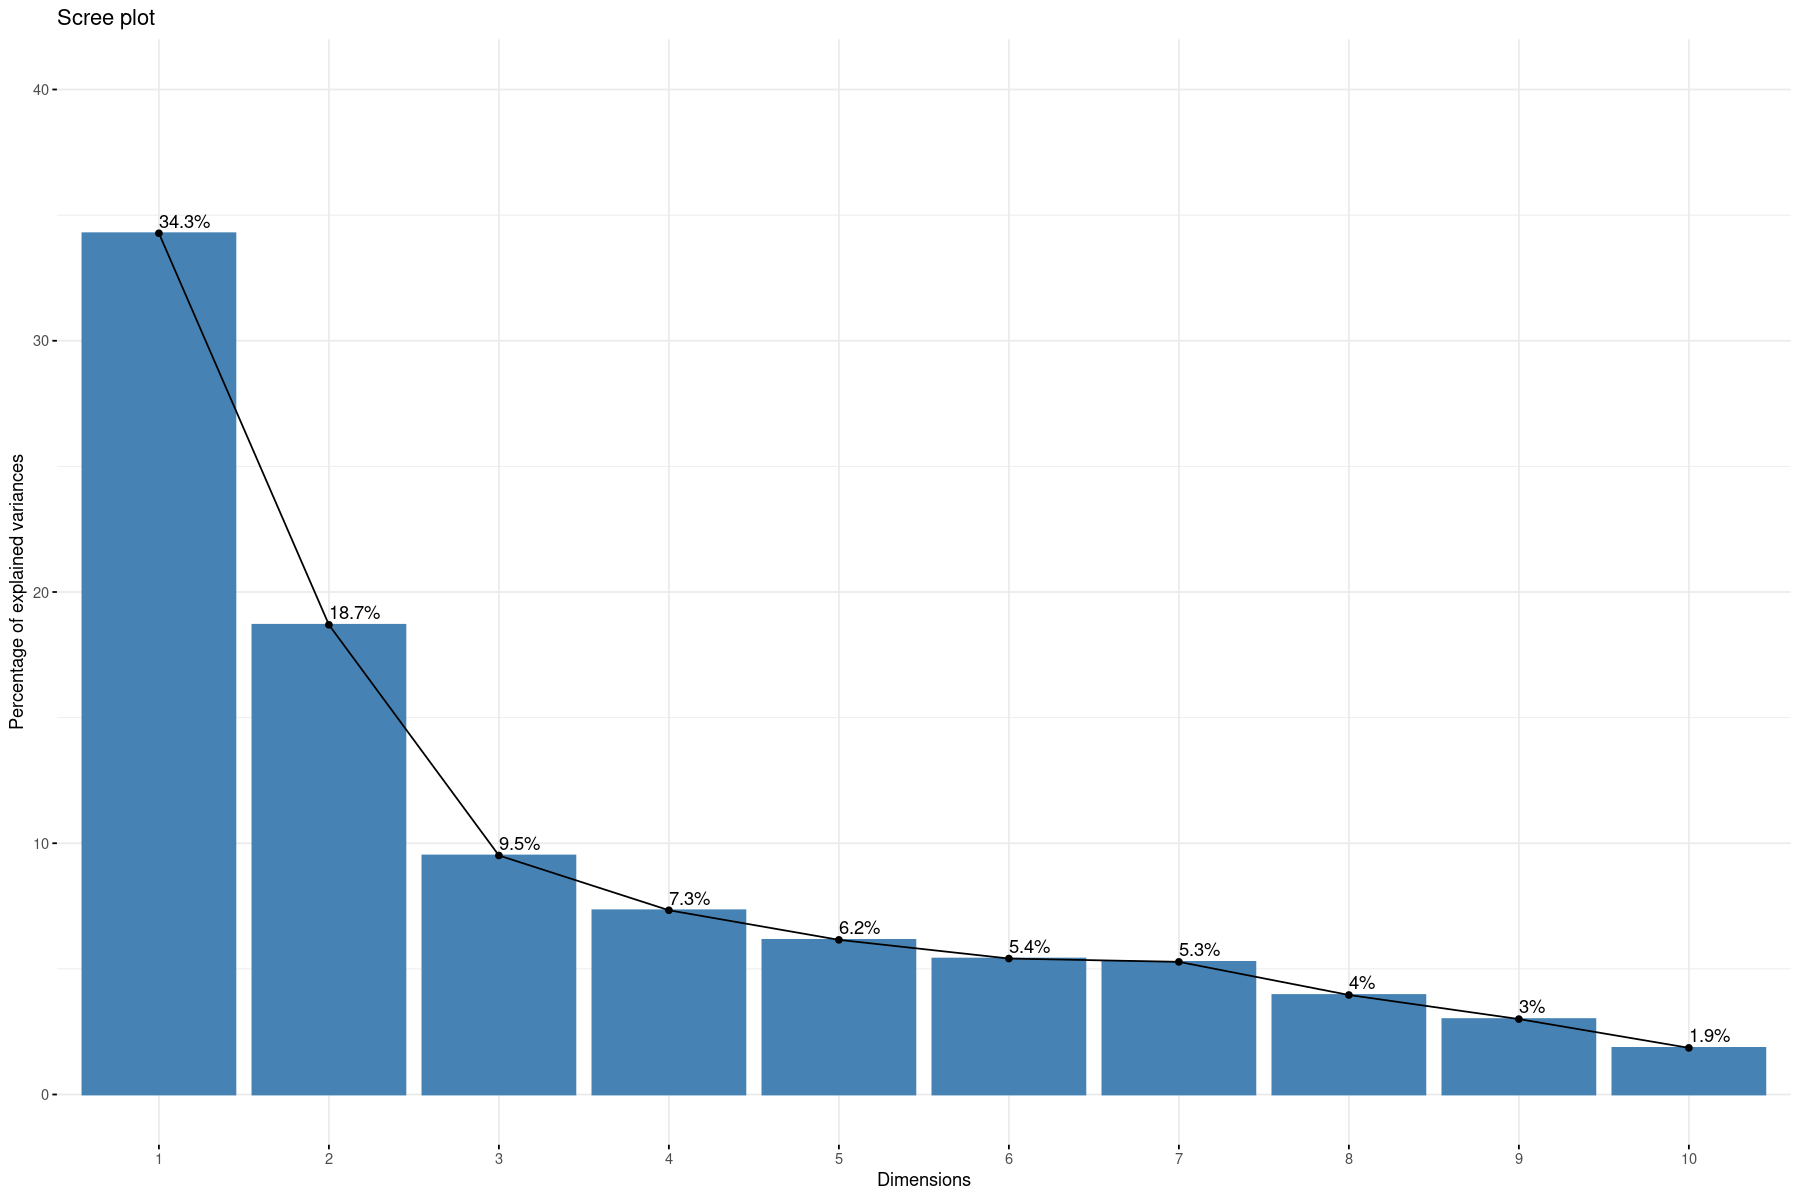

In [57]:
fviz_screeplot(resultat_pca, addlabels=TRUE, ylim=c(0,40))

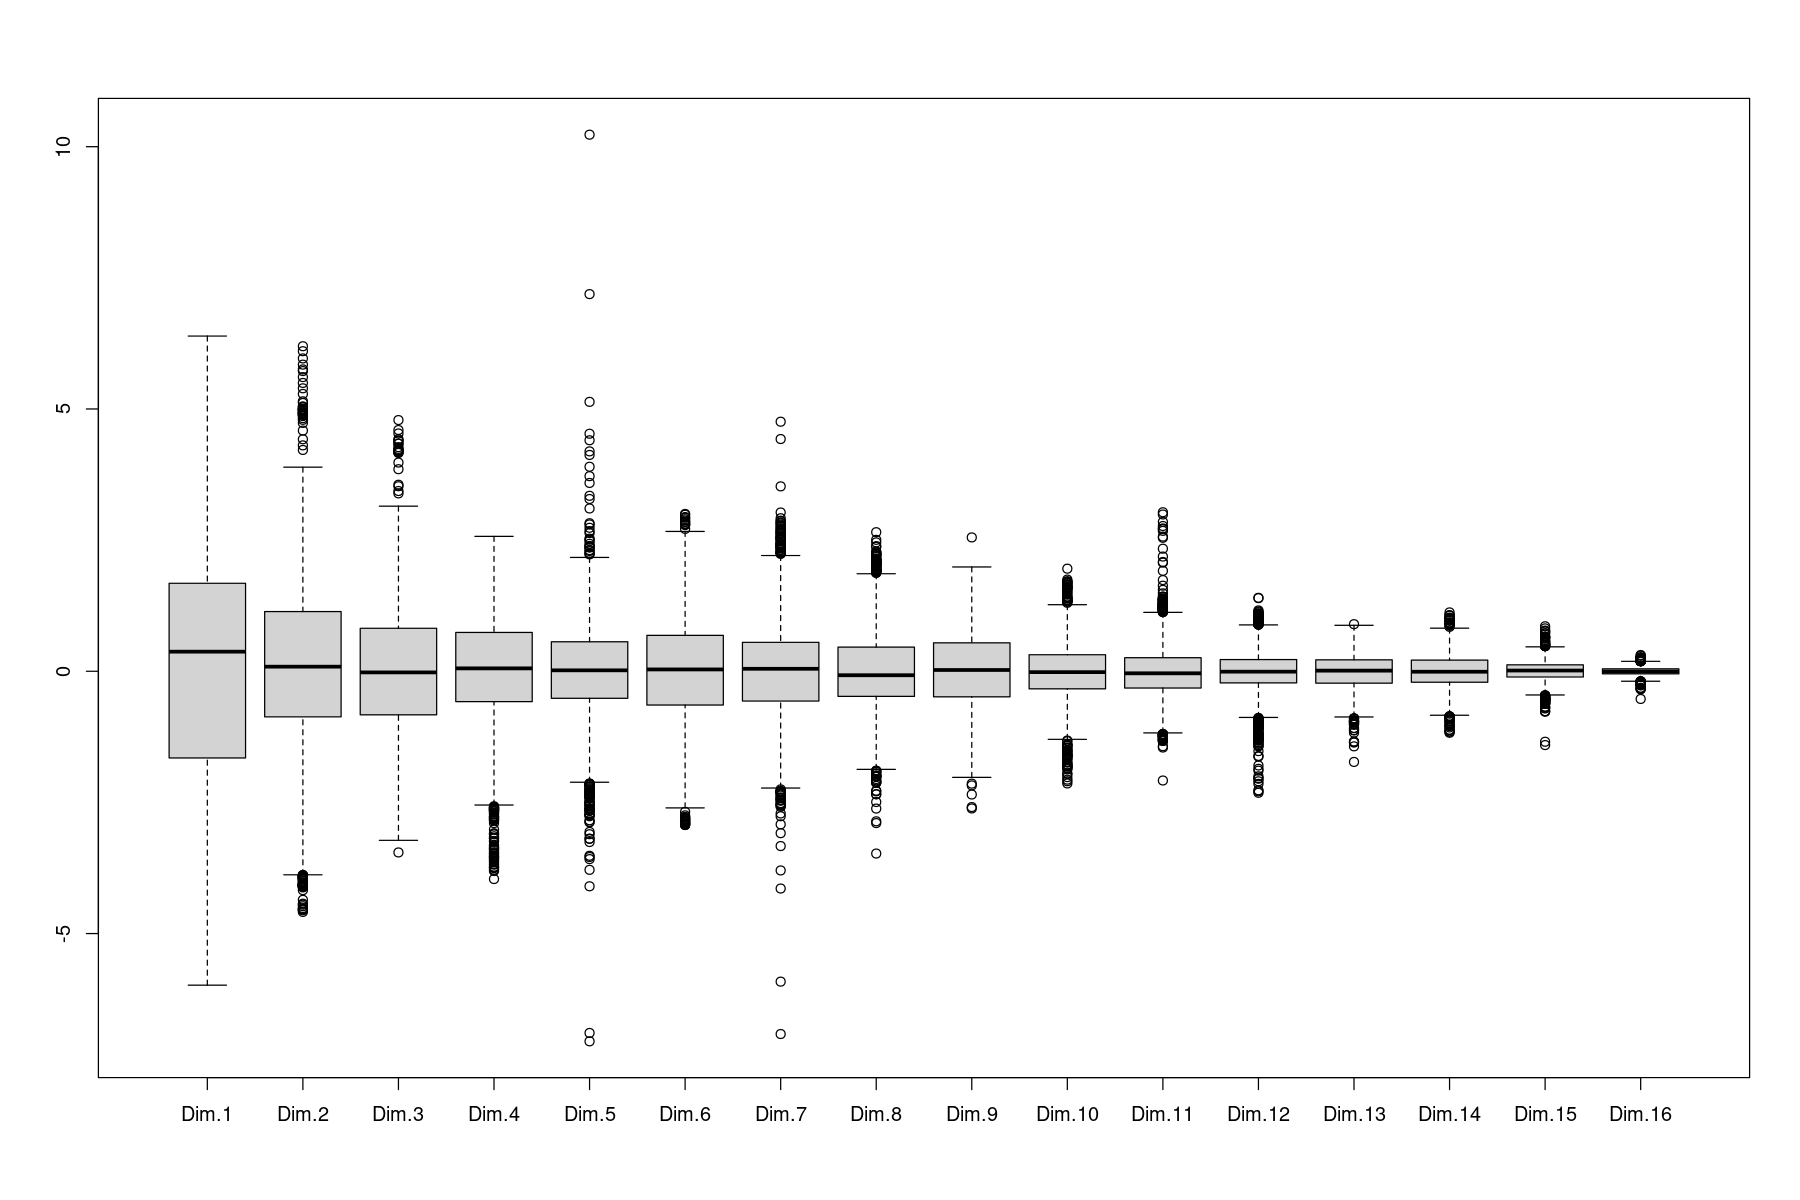

In [58]:
boxplot(resultat_pca$ind$coord)

Nous pouvons en effet voir par cette ACP, que la première composante explique 33.3% des valeurs du energy set.La deuxième composante, elle représente 18.9%. Nous pourrions réduire notre dimension à 2 car avec ces deux-ci, nous expliquons pratiquement la moitié du energy set. Il faudrait ajouter 4 dimensions pour avoir 80% des valeurs expliquées. 

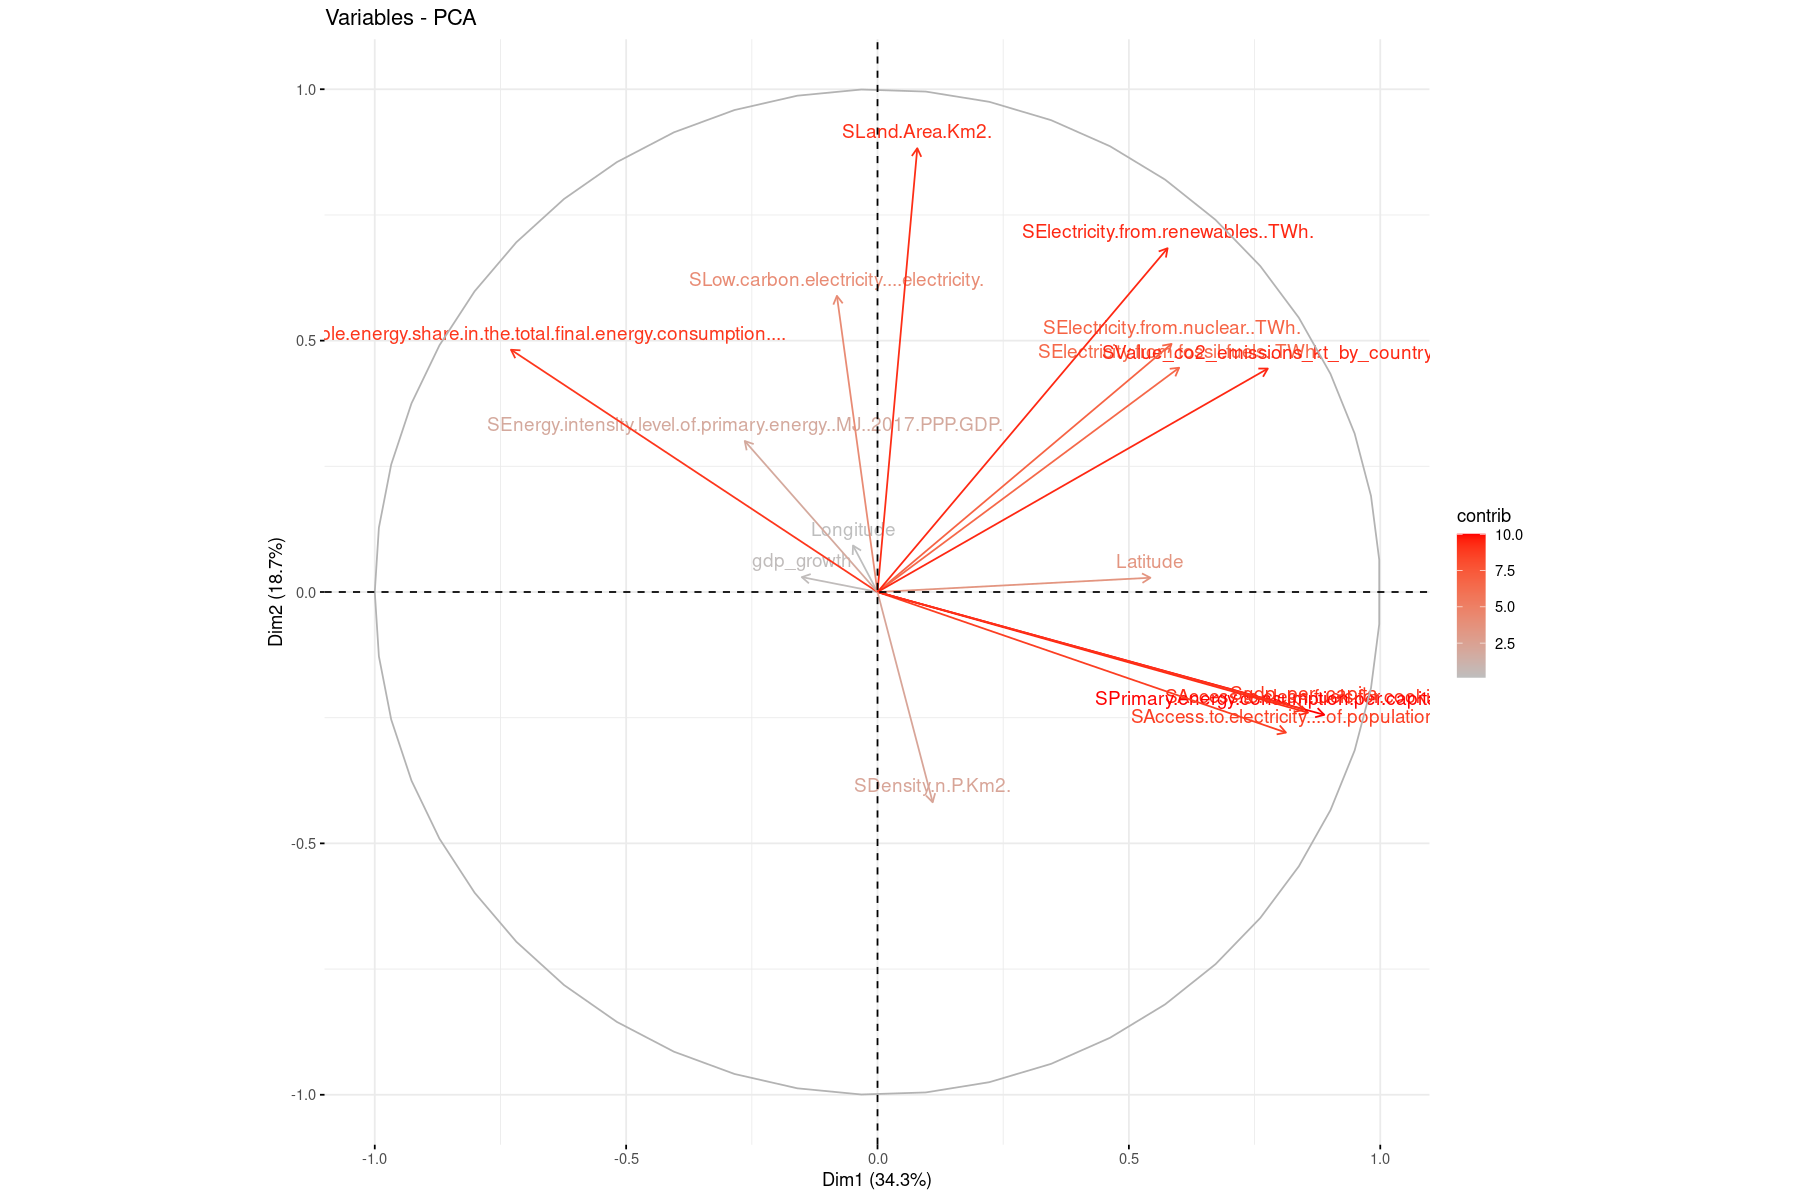

In [59]:
var=get_pca_var(resultat_pca)
fviz_pca_var(resultat_pca,col.var= "contrib",gradient.cols=c("grey", "red"))

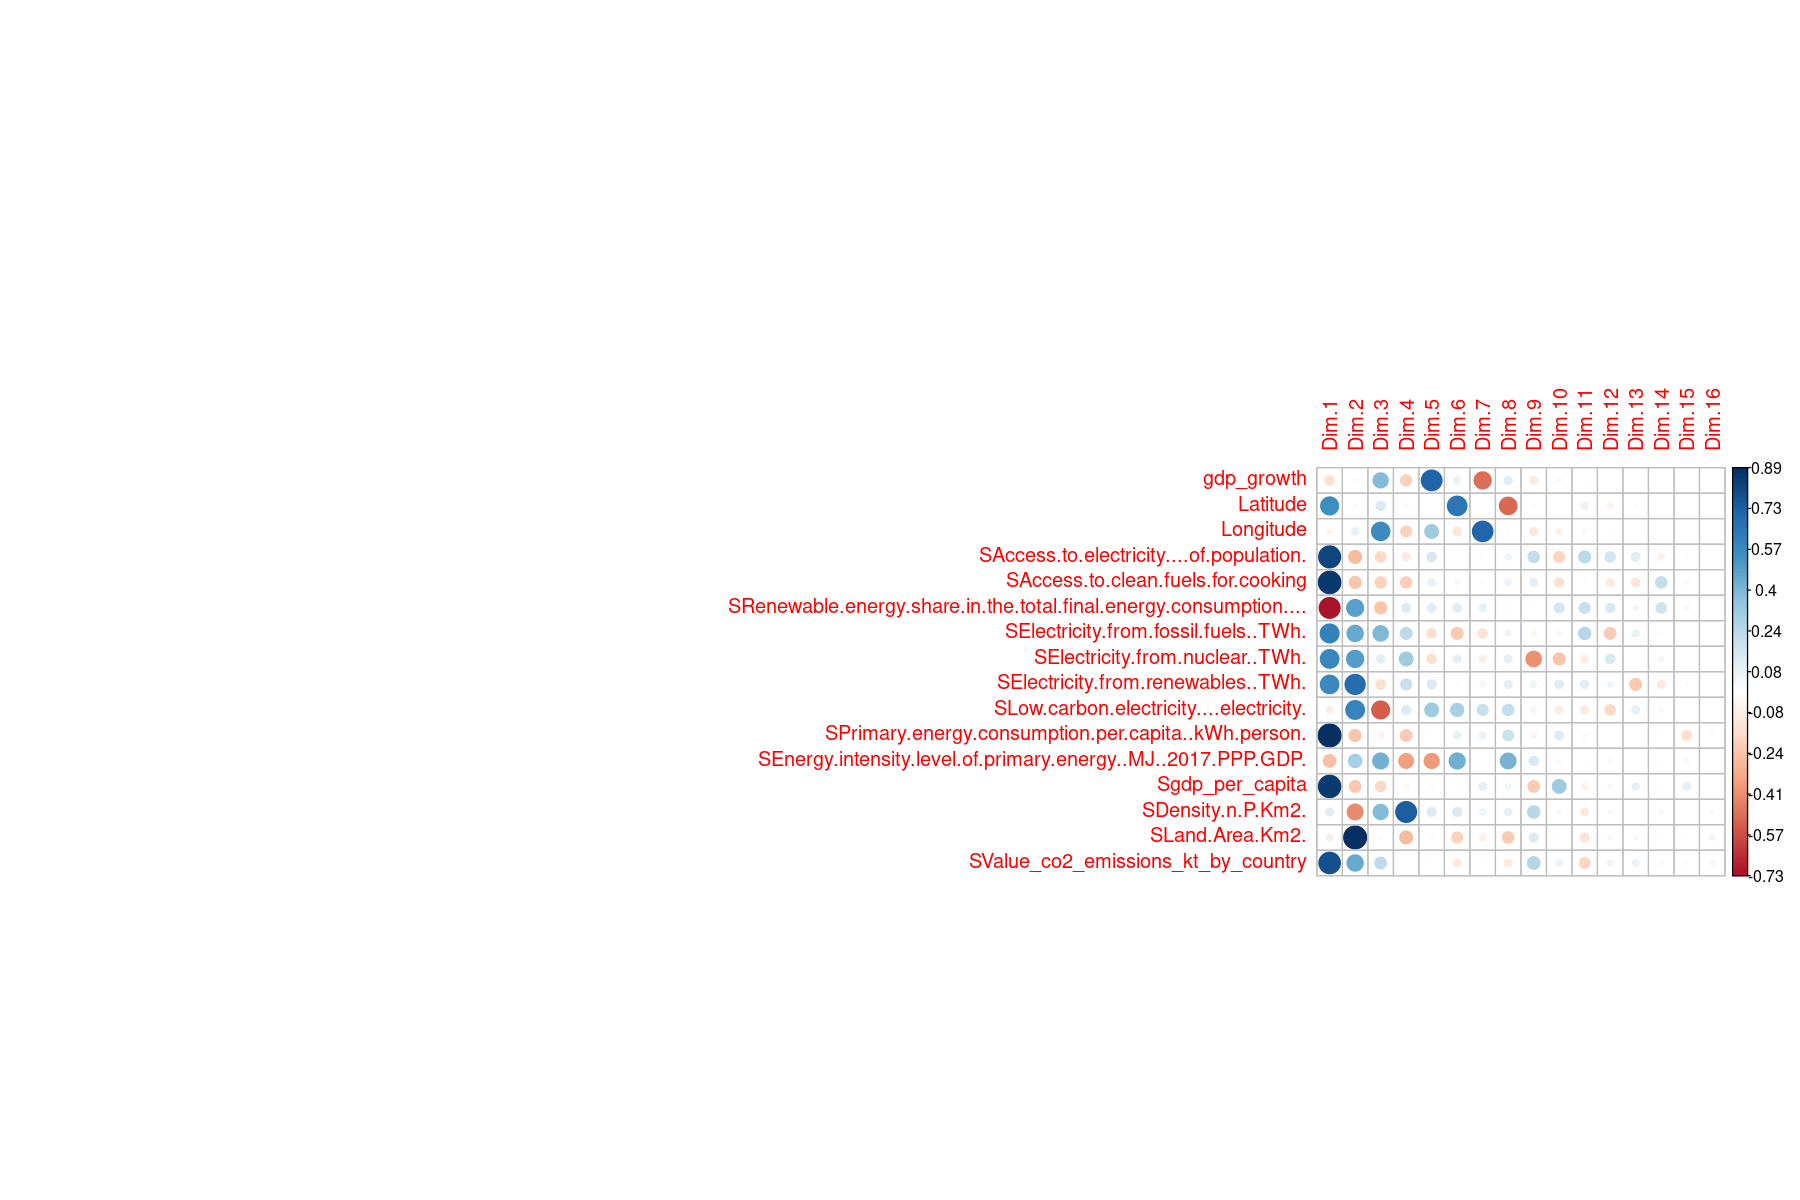

In [60]:
corrplot(resultat_pca$var$cor, is.corr=FALSE)

Dim 1 : Corrélée positivement avec Access_to_Electricity, Access_Clean_Fuel, Primary_energy_consumption, gdp_per_capita / Négativement avec Renewable_share

Dim 2 : Corrélée positivement Land_Area, Electricity_renewables

Dim 4 : Corrélée positivement Density

Dim 5 : Corrélée positivement gdp_growth

Dim 6 Corrélée positivement Latitude

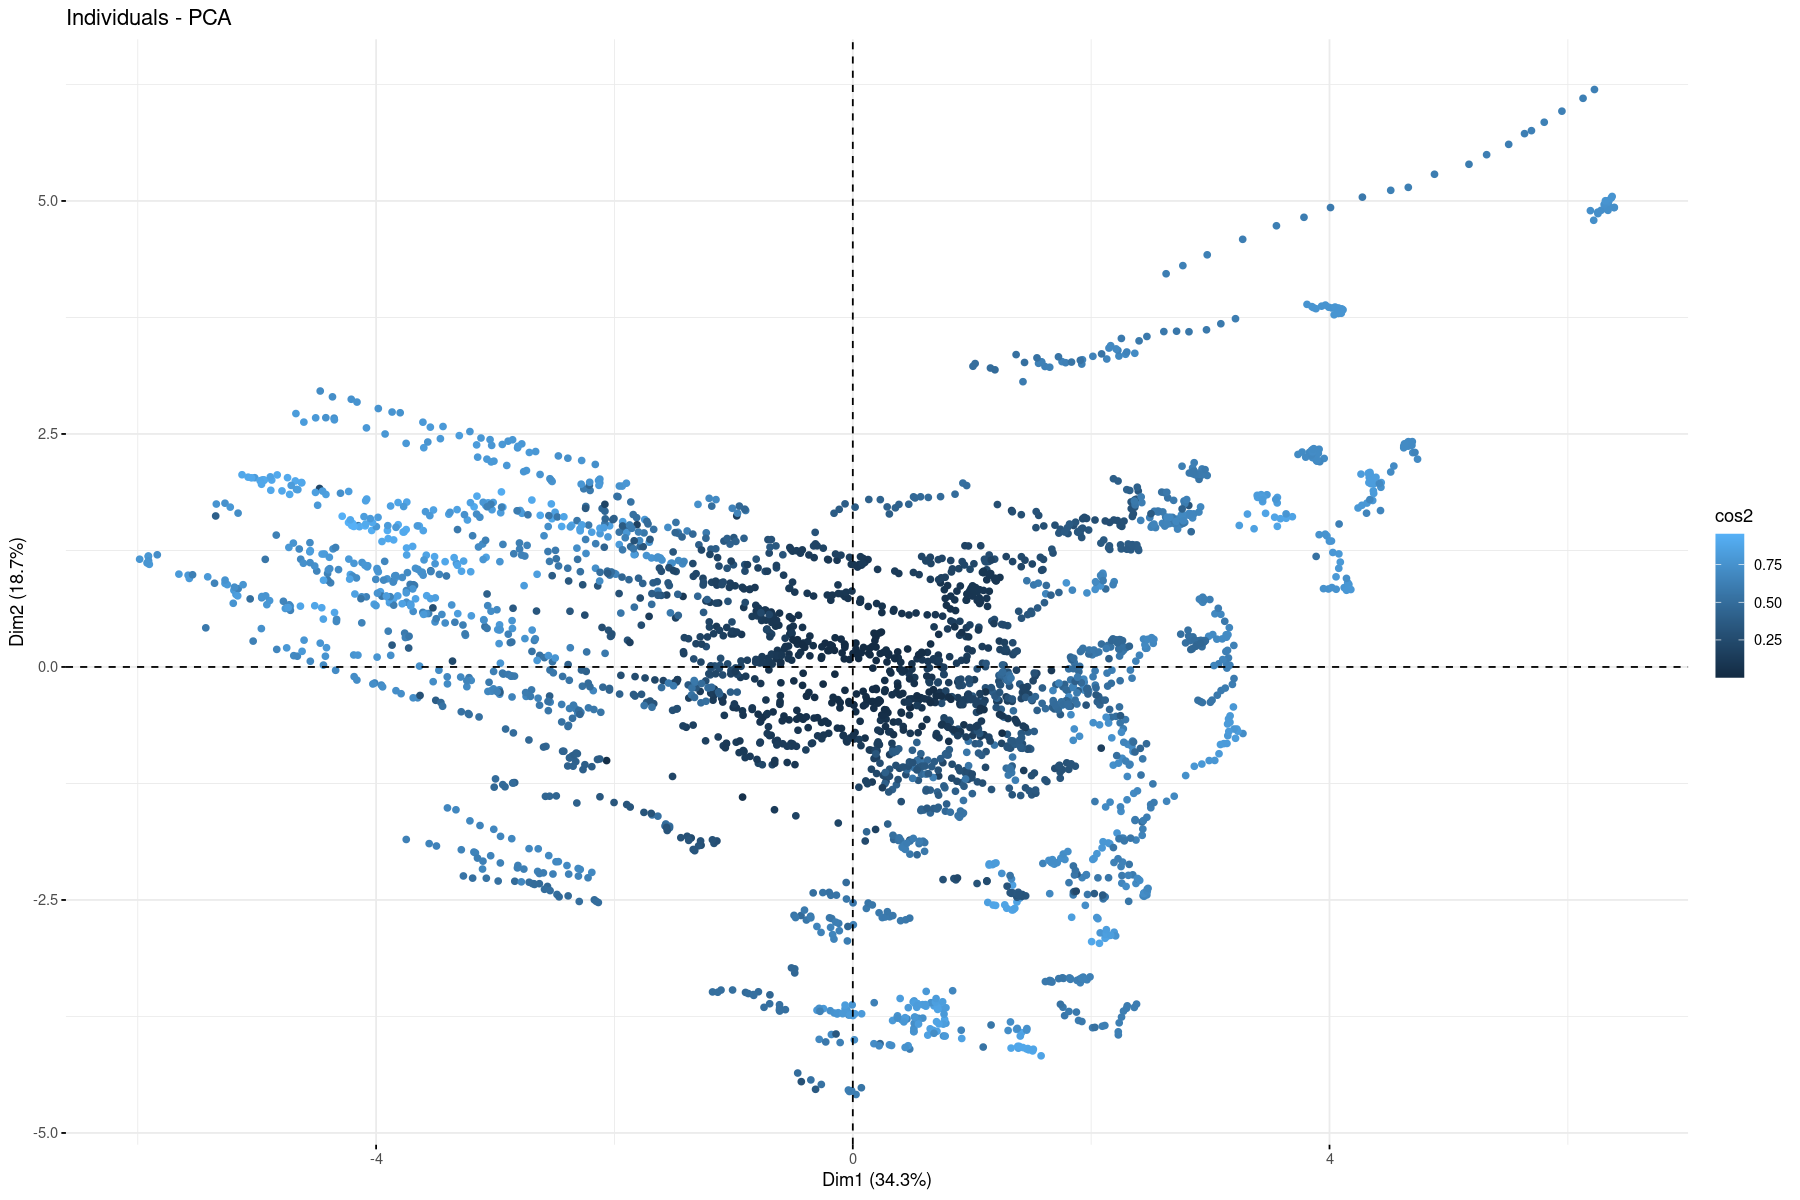

In [61]:
fviz_pca_ind(resultat_pca, label= "none", col.ind="cos2")

# Modélisation

## Question 1

### Diviser échantillon d'apprentissage / de test

In [63]:
complete_energy$Entity = as.factor(complete_energy$Entity)
complete_energy$Year = as.factor(complete_energy$Year)

MEntity <- model.matrix(~ Entity -1, data = complete_energy)
MYear <- model.matrix(~ Year-1, data = complete_energy)

data <- cbind(complete_energy[,-c(1,2)], MEntity, MYear)

In [64]:
set.seed(183) # initialisation du générateur

# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(complete_energy) # nombre de lignes dans les données
nvar <- ncol(complete_energy) # nombre de colonnes

# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 

# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

# construction de l'échantillon d'apprentissage
datappr <- data[appri,] 
# construction de l'échantillon test
datestr <- data[testi, ] 

# vérification
str(datappr)
str(datestr)
#summary(datappr) 

'data.frame':	2294 obs. of  185 variables:
 $ gdp_growth                                                       : num  8.83 1.41 5.36 3.92 21.39 ...
 $ Latitude                                                         : num  33.9 33.9 33.9 33.9 33.9 ...
 $ Longitude                                                        : num  67.7 67.7 67.7 67.7 67.7 ...
 $ SAccess.to.electricity....of.population.                         : num  2.69 3 3.42 3.75 3.84 ...
 $ SAccess.to.clean.fuels.for.cooking                               : num  2.35 2.48 2.7 2.87 2.97 ...
 $ SRenewable.energy.share.in.the.total.final.energy.consumption....: num  6.05 6.65 5.65 4.6 4.07 ...
 $ SElectricity.from.fossil.fuels..TWh.                             : num  0.557 0.574 0.447 0.436 0.4 ...
 $ SElectricity.from.nuclear..TWh.                                  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ SElectricity.from.renewables..TWh.                               : num  0.489 0.445 0.495 0.432 0.577 ...
 $ SLow.carbon.electri

Permet de tester notre modèle sur des données encore non traitées Eviter le sur ajustement. 

## Question 2

### Modèle linéaire

#### Sans sélection de variable

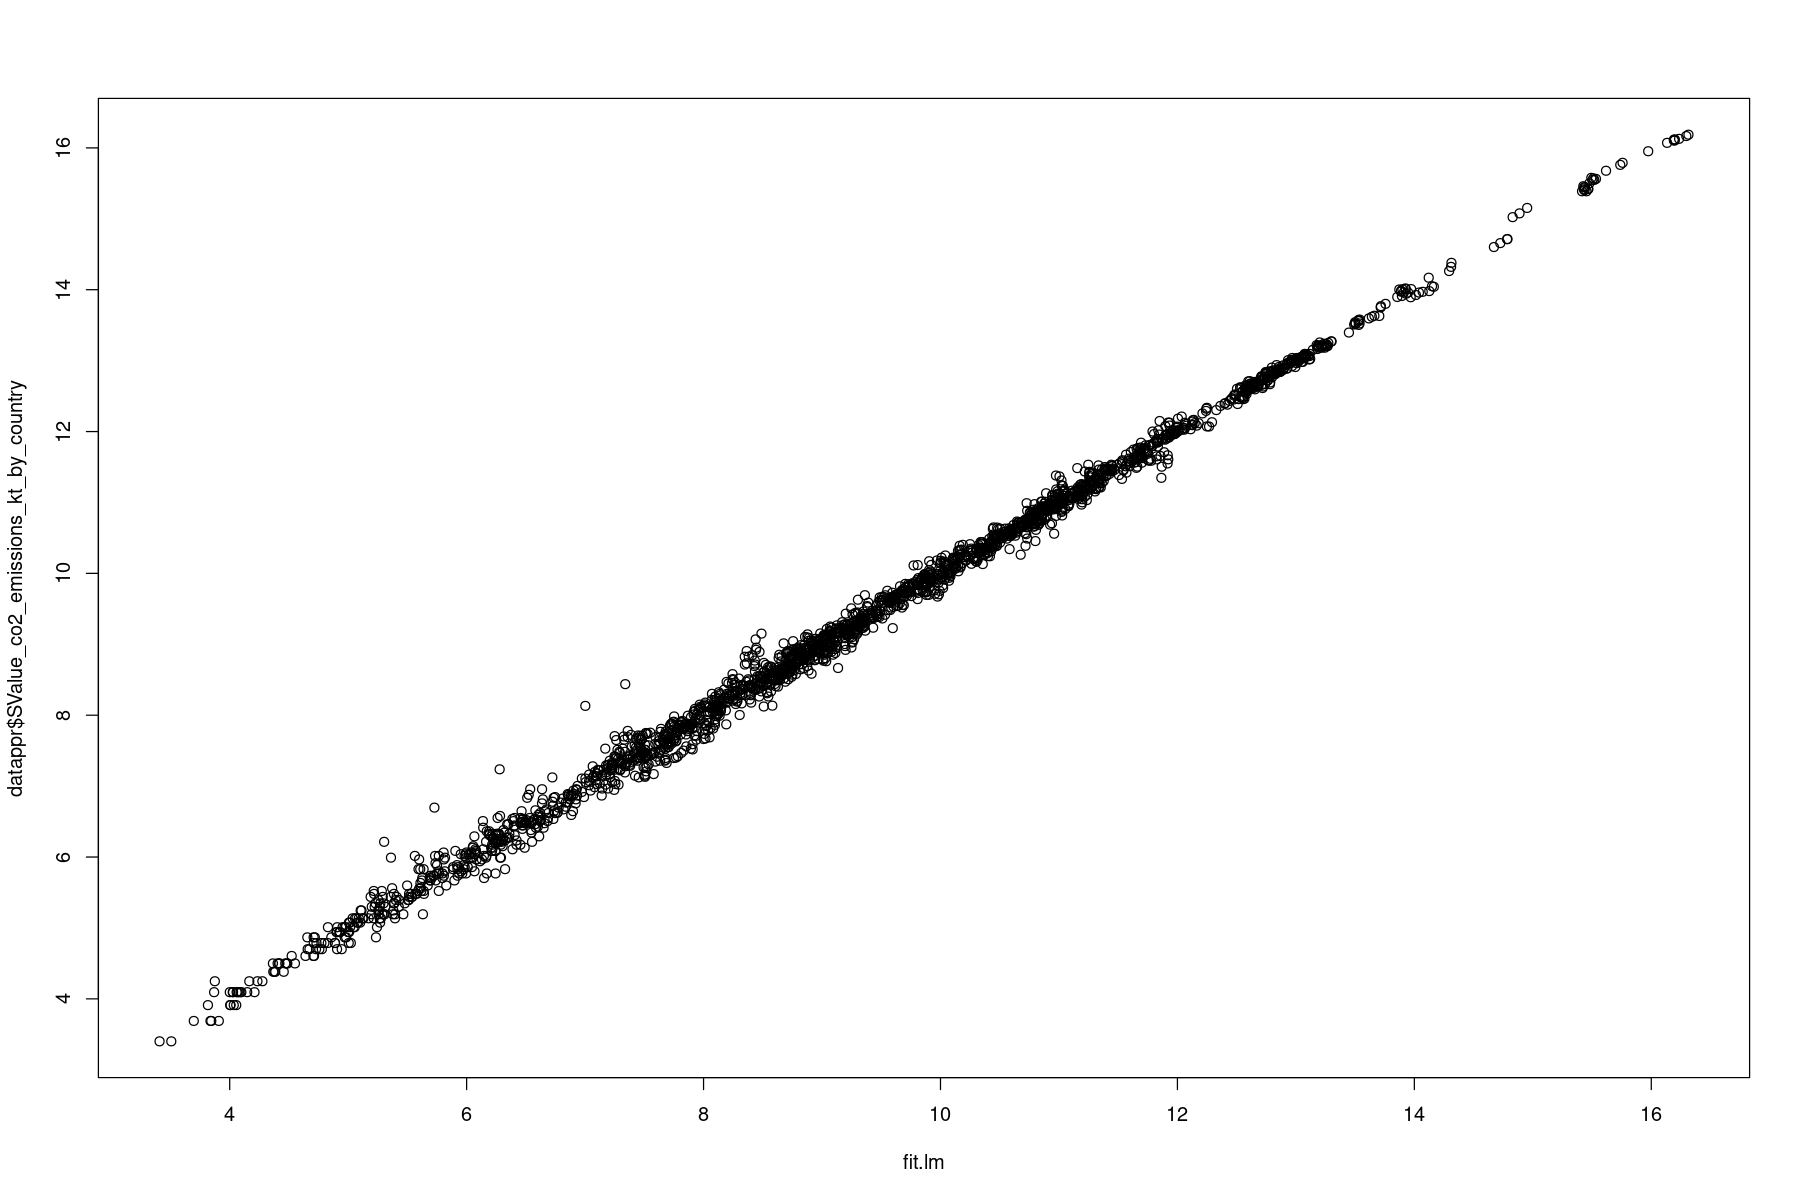

In [69]:
# estimation du modèle sans interaction
reg.lm <-aov(SValue_co2_emissions_kt_by_country ~ . , data = datappr)
# Extraction des résidus et des valeurs ajustées de ce modèle
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

plot(fit.lm,datappr$SValue_co2_emissions_kt_by_country)

##### MSE et R²

In [84]:
MSE = mean((datappr$SValue_co2_emissions_kt_by_country - fit.lm)^2)
paste("MSE =", MSE)

# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2_emissions_kt_by_country - fit.lm)^2)
SS_Total <- sum((datappr$SValue_co2_emissions_kt_by_country - mean(datappr$SValue_co2_emissions_kt_by_country))^2)
R2 <- 1 - (SS_Residual / SS_Total)
paste("R2 =", R2)


[1] "MSE = 0.0179276575194949"

[1] "R2 = 0.996815626869896"

##### Graphe des résidus

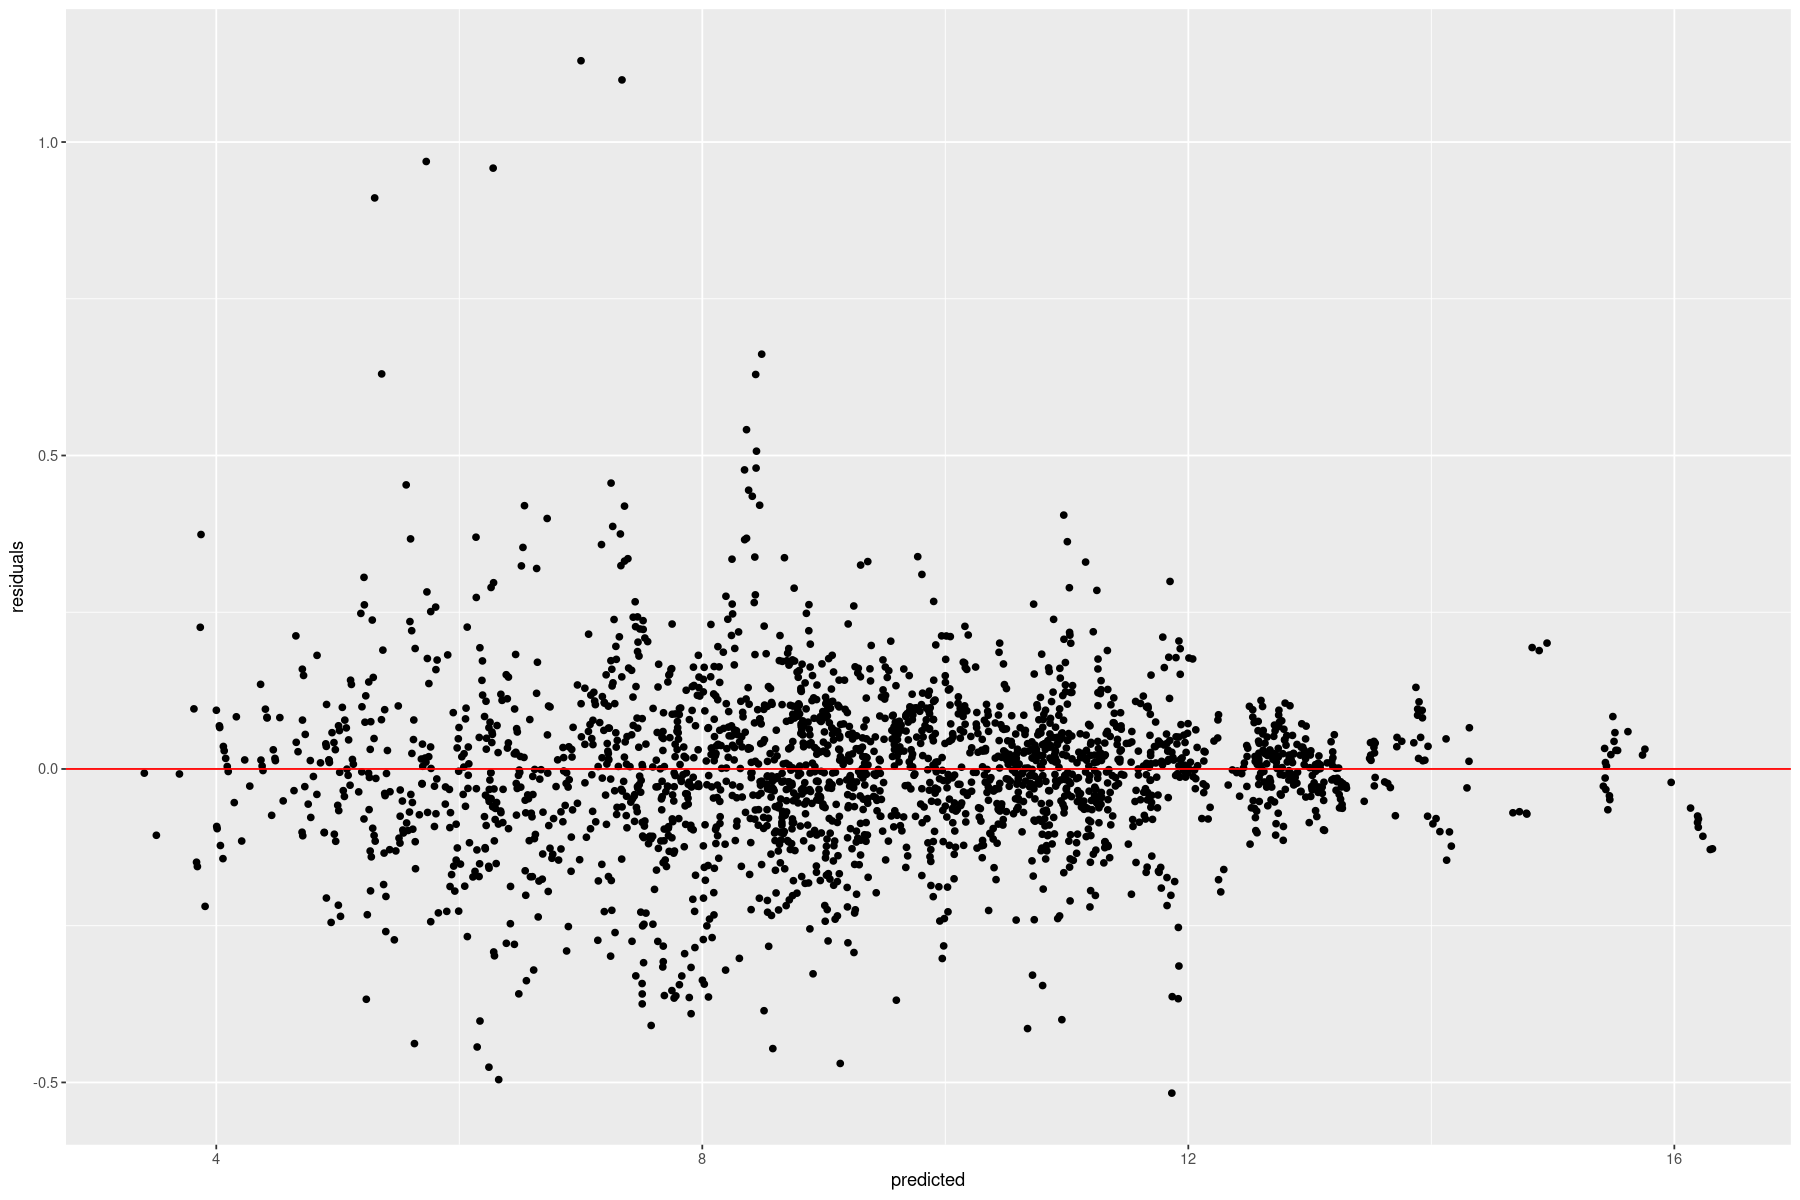

In [66]:
ggplot(data.frame(residuals = res.lm, predicted = fitted(reg.lm)), aes(x = predicted, y = residuals)) +
  geom_point() +
  geom_hline(yintercept = 0 ,color = "red") 

In [ ]:
#summary(reg.lm)
#coef(reg.lm)

#### Avec sélection de variable (LASSO)

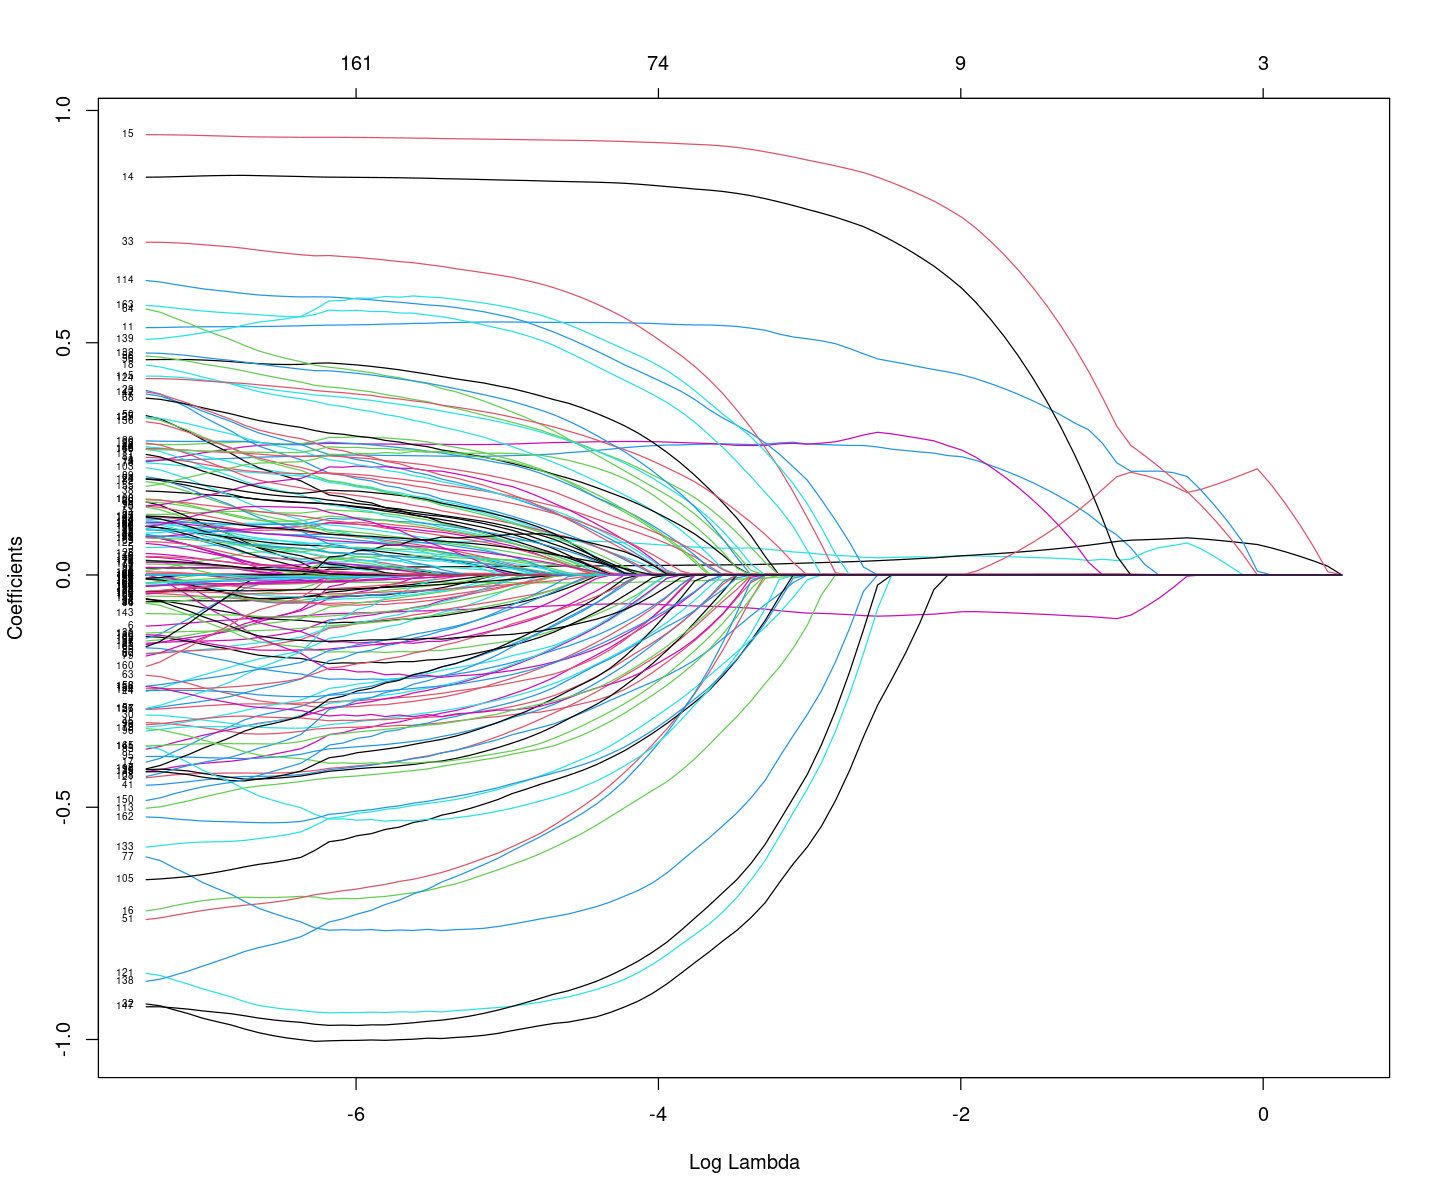

In [98]:
# avec des variables quantitatives seulement
reg.lasso.quanti <- glmnet(y = datappr[, 16],
                           x = as.matrix(datappr[,-16]))
# avec toutes les variables, créer d'abord la matrice d'expériences 
# avec 'model.matrix' (penser à retirer l'intercept du modèle)
x.mat <- model.matrix(SValue_co2_emissions_kt_by_country ~ . - 1, data = datappr)
reg.lasso <- glmnet(y = datappr$SValue_co2_emissions_kt_by_country, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)

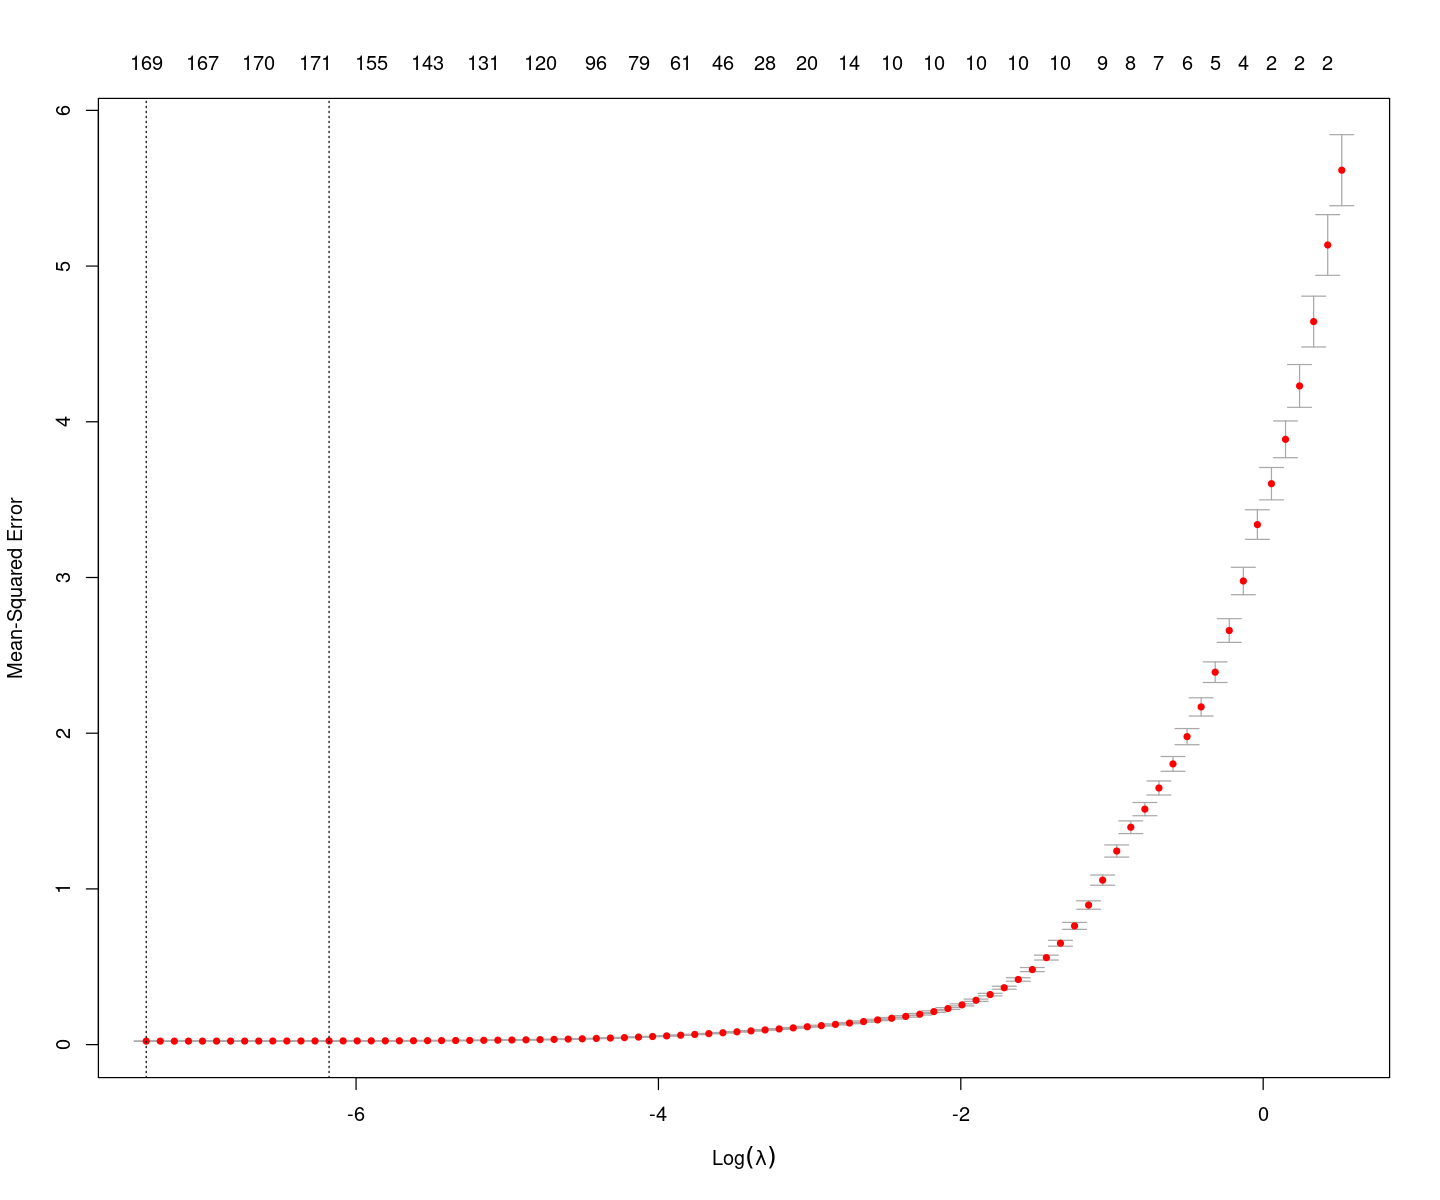

In [99]:
reg.lasso.cv = cv.glmnet(y = datappr[, 16], x = x.mat)
#plot(reg.lasso.cv)
plot(reg.lasso.cv)

In [100]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
#coef(reg.lasso.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 0.002"

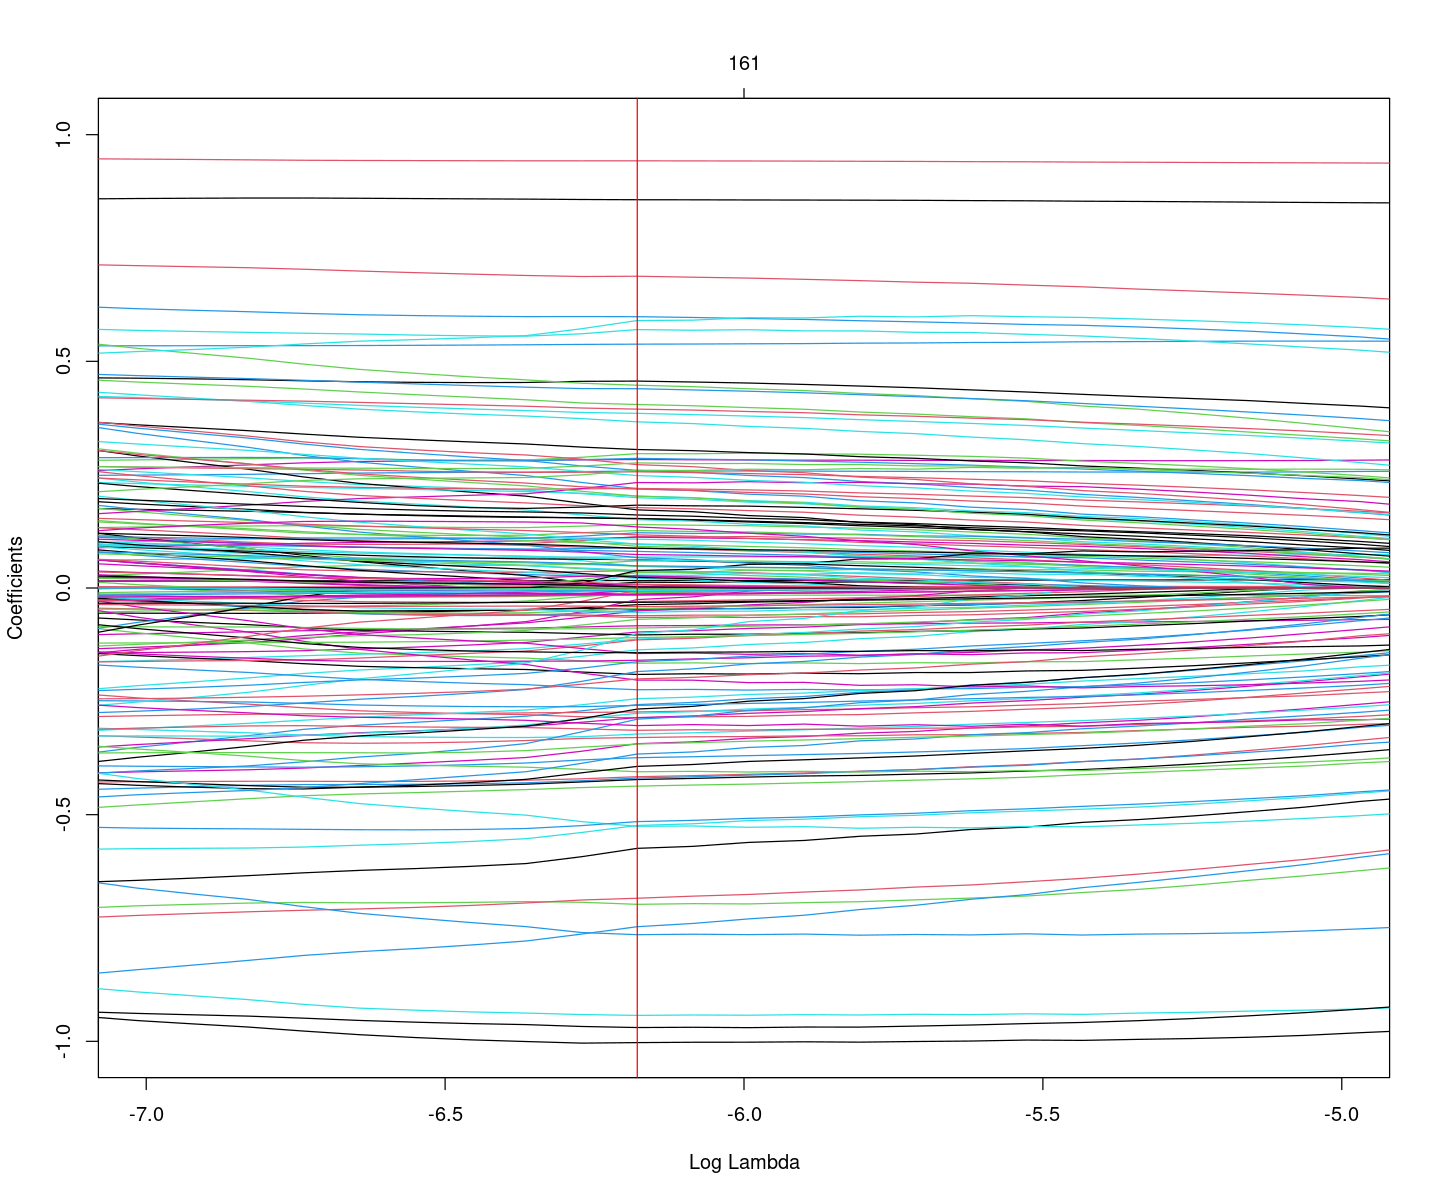

In [101]:
plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(-7,-5),ylim=c(-1,1))
abline(v=log(reg.lasso.cv$lambda.1se),col="red")

In [104]:
# Extraction des valeurs ajustées et des résidus

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- datappr$SValue_co2_emissions_kt_by_country - fit.lasso.1se 

##### MSE et R²

In [105]:
MSE = mean((datappr$SValue_co2_emissions_kt_by_country - fit.lasso.1se)^2)
paste("MSE =", MSE)

# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2_emissions_kt_by_country - fit.lasso.1se)^2)
SS_Total <- sum((datappr$SValue_co2_emissions_kt_by_country - mean(datappr$SValue_co2_emissions_kt_by_country))^2)
R2 <- 1 - (SS_Residual / SS_Total)
paste("R2 =", R2)

[1] "MSE = 0.0200498607361059"

[1] "R2 = 0.996438673724052"

##### Graphe des résidus

In [103]:

ggplot(data.frame(residuals = res.lasso.1se, predicted = fit.lasso.1se), aes(x = predicted, y = residuals)) +
  geom_point() +
  geom_hline(yintercept = 0 ,color = "red") +
  ggtitle("LASSO 1se")

ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! objet 'predicted' introuvable

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_han

### SVM

On enlève l'année 2020 parce qu'il n'y a jamais aucune donnée dedans

In [ ]:
datappr <- datappr[, !names(data) %in% "Year2020"]

In [ ]:
svm.reg0 = svm(SValue_co2_emissions_kt_by_country ~ ., data = datappr)
summary(svm.reg0)

#### Choix du meilleur noyau SVM

In [ ]:
svm.reg.tune = tune.svm(SValue_co2_emissions_kt_by_country ~ ., data = datappr, cost = seq(1, 4, by = 0.5), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.reg.tune)

In [ ]:
#set.seed(2021)
svm.reg = svm(SValue_co2_emissions_kt_by_country ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma, epsilon = 0.25)
summary(svm.reg)

#### Résidus

In [ ]:
fit.svmr=svm.reg$fitted
res.svmr=fit.svmr-datappr[,"SValue_co2_emissions_kt_by_country"]
gplot.res(fit.svmr,res.svmr,titre="")

### Arbre

In [ ]:
tree.reg=rpart(SValue_co2_emissions_kt_by_country~.,data=datappr,control=rpart.control(cp=0.001))

In [ ]:
library(rpart.plot)
options(repr.plot.width = 15, repr.plot.height = 10)
rpart.plot(tree.reg)

In [ ]:
xmat<-xpred.rpart(tree.reg,xval=10) 
# one row for each observation and one column for each complexity value

# Cross-validation error par valeur de CP
CVerr<-apply((xmat-datappr[,"SValue_co2_emissions_kt_by_country"])^2,2,sum)

plotcp(tree.reg)

In [ ]:
as.numeric(attributes(which.min(CVerr))$names)
tree.reg=rpart(SValue_co2_emissions_kt_by_country~.,data=datappr,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))
rpart.plot(tree.reg,type=5,extra=101)

In [ ]:
library(partykit)
plot(as.party(tree.reg), type="simple")

In [ ]:
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"SValue_co2_emissions_kt_by_country"]

options(repr.plot.width = 12, repr.plot.height = 4)
par(mfrow = c(1, 3))
ggplot(data.frame(residuals = res.tree, predicted = fit.tree), aes(x = predicted, y = residuals)) +
  geom_point() +
  geom_hline(yintercept = 0 ,color = "red") +
  ggtitle("Tree")

### Random Forest

In [ ]:
rf.reg=randomForest(SValue_co2_emissions_kt_by_country~., data=datappr,xtest=datestr[,-16],ytest=datestr[,"SValue_co2_emissions_kt_by_country"],
   ntree=500,do.trace=50,importance=TRUE)
attributes(rf.reg)
rf.reg$mtry